

Open AI CartPole-v1

In [1]:
%env KMP_DUPLICATE_LIB_OK = True

env: KMP_DUPLICATE_LIB_OK=True


In [2]:
import numpy as np
import random
import pickle
import copy
import itertools

import pandas as pd
import torch

import matplotlib.pyplot as plt
import seaborn as sns
from skimage import io
from torch.utils import data

%matplotlib inline
import matplotlib as mpl
mpl.rc("figure", figsize=(16, 9))

In [3]:
def do_seeds(sn):
    np.random.seed(sn)
    torch.manual_seed(sn)
    random.seed(sn)
do_seeds(0)

In [4]:
def ttf(np_arr):
    return torch.tensor(np_arr, dtype=torch.float, requires_grad=False)
def ttl(np_arr):
    return torch.tensor(np_arr, dtype=torch.long, requires_grad=False)

In [5]:
devv = torch.device('cpu')
#devv = torch.device('cuda')

In [37]:
import gym
from rl.agent import Memory, Agent

In [28]:
from rl.dqn import QPolicy

Note: the DQN algorithm only works for discrete action spaces. If we want to apply it to continuous action spaces we have to discretize it.

# Using the policy class

## We choose an environment

In [29]:
env_name = 'CartPole-v1'

In [30]:
env = gym.make(env_name)

In [31]:
env.action_space

Discrete(2)

In [32]:
env.observation_space

Box(4,)

In [12]:
env.observation_space.__dict__

{'dtype': dtype('float32'),
 'shape': (4,),
 'low': array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
       dtype=float32),
 'high': array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
       dtype=float32),
 'bounded_below': array([ True,  True,  True,  True]),
 'bounded_above': array([ True,  True,  True,  True]),
 'np_random': RandomState(MT19937) at 0x1A271B26B0}

## We define the Q neural net

In [13]:
def init_f(forw):
    for nam, param in forw.named_parameters():
        if 'weight' in nam:
            torch.nn.init.xavier_normal_(param) 
        else:
            param.data.fill_(0.01)

In [14]:
q_nn1 = torch.nn.Sequential(
    torch.nn.Linear(env.observation_space.shape[0], 32),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(32, 16),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(16, env.action_space.n) # last layer does not have activation, since this is a regression task
).to(devv)

In [15]:
q_nn1

Sequential(
  (0): Linear(in_features=4, out_features=32, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=32, out_features=16, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=16, out_features=2, bias=True)
)

Number of parameters:

In [16]:
sum([np.prod(list(pi.shape)) for pi in q_nn1.parameters()])

722

## We start the agent and the policy

In [17]:
init_f(q_nn1) # we init the 'playing' network
bq_nn1 = copy.deepcopy(q_nn1).to(devv) # we will keep here the best network we find
dqn = QPolicy(q_nn1, env.action_space, pt_dev=devv) # we define our policy
mem = Memory(env, mem_size=50000, pt_dev=devv)
ag = Agent(env, dqn, mem, devv)

##  We train Q

In [18]:
mrw_list = []  # For storing training stats
steps_list = []
max_rw = -1E10

In [47]:
for i in range(10000):
    dqn.eps = (0.05 + 0.95*(0.975**i)) # we let epsilon decay, starting with high exploration and finishing with low exploration
    print('Iteration:', i, 'eps = ', dqn.eps)
    
    rw_i = ag.play(render=False, episode=True) # play for an episode
    mrw_i = np.sum(rw_i[0])/np.sum(rw_i[1]) # the average reward obtained
    mrw_list.append(mrw_i)
    steps_list.append(ag.mem.t_i)
    print('\t Mean rewards:', mrw_i)
    
    mem_data = ag.mem.get_memory()
    print('\t Losses', dqn.train(mem_data, epochs=5)) # train 5 epochs

    if i%10 == 0: # set target network equal to playing network, every 10 iterations
        dqn.copy_q_to(dqn.tq)
        print('\t Target updated!', i)
    if max_rw <= mrw_i: # keep the best network until now
        dqn.copy_q_to(bq_nn1)
        max_rw = mrw_i
        print('\t Best updated!', max_rw)

Iteration: 0 eps =  1.0
	 Mean rewards: 44.0
	 Losses [1.0359466075897217, 1.0124424695968628, 0.9893873333930969, 0.9670028686523438, 0.9451779723167419]
	 Target updated! 0
	 Best updated! 44.0
Iteration: 1 eps =  0.97625
	 Mean rewards: 45.0
	 Losses [1.0423359870910645, 1.0206289291381836, 0.9995293617248535, 0.9787853956222534, 0.9584386348724365]
	 Best updated! 45.0
Iteration: 2 eps =  0.95309375
	 Mean rewards: 21.0
	 Losses [0.9358736872673035, 0.9162873029708862, 0.8970335721969604, 0.8781208992004395, 0.859586775302887]
Iteration: 3 eps =  0.93051640625
	 Mean rewards: 24.0
	 Losses [0.8488922119140625, 0.8307178020477295, 0.8127732872962952, 0.7950611710548401, 0.7776234745979309]
Iteration: 4 eps =  0.9085034960937499
	 Mean rewards: 12.0
	 Losses [0.7499718070030212, 0.7325780987739563, 0.7154189944267273, 0.6985175609588623, 0.6818559765815735]
Iteration: 5 eps =  0.8870409086914062
	 Mean rewards: 13.0
	 Losses [0.6632973551750183, 0.6473411917686462, 0.6315686702728271

	 Mean rewards: 9.0
	 Losses [1.321710467338562, 1.3118070363998413, 1.3026500940322876, 1.2949304580688477, 1.2882215976715088]
Iteration: 67 eps =  0.22419386569485983
	 Mean rewards: 11.0
	 Losses [1.2833573818206787, 1.278211236000061, 1.2736634016036987, 1.2692686319351196, 1.2647091150283813]
Iteration: 68 eps =  0.21983901905248837
	 Mean rewards: 15.0
	 Losses [1.2527499198913574, 1.2475262880325317, 1.2421956062316895, 1.236944317817688, 1.231919527053833]
Iteration: 69 eps =  0.21559304357617615
	 Mean rewards: 11.0
	 Losses [1.229058861732483, 1.225054144859314, 1.221559762954712, 1.218550205230713, 1.2159324884414673]
Iteration: 70 eps =  0.21145321748677176
	 Mean rewards: 9.0
	 Losses [1.2235783338546753, 1.221334457397461, 1.219202995300293, 1.2170788049697876, 1.2148429155349731]
	 Target updated! 70
Iteration: 71 eps =  0.20741688704960243
	 Mean rewards: 11.0
	 Losses [1.844775915145874, 1.81331205368042, 1.760890007019043, 1.6955788135528564, 1.6253341436386108]
Iter

	 Losses [1.42217218875885, 1.421392798423767, 1.42081880569458, 1.4201234579086304, 1.4190776348114014]
Iteration: 119 eps =  0.09669526811890267
	 Mean rewards: 65.0
	 Losses [1.4074969291687012, 1.4055992364883423, 1.4033342599868774, 1.4008312225341797, 1.3982526063919067]
Iteration: 120 eps =  0.0955278864159301
	 Mean rewards: 222.0
	 Losses [1.3390617370605469, 1.3370779752731323, 1.3354476690292358, 1.334149956703186, 1.333091378211975]
	 Target updated! 120
	 Best updated! 222.0
Iteration: 121 eps =  0.09438968925553184
	 Mean rewards: 101.0
	 Losses [2.0110528469085693, 1.9607491493225098, 1.8708795309066772, 1.767136812210083, 1.6725404262542725]
Iteration: 122 eps =  0.09327994702414355
	 Mean rewards: 62.0
	 Losses [1.610971212387085, 1.5718872547149658, 1.561327576637268, 1.570726752281189, 1.5892750024795532]
Iteration: 123 eps =  0.09219794834853996
	 Mean rewards: 312.0
	 Losses [1.550711989402771, 1.5630011558532715, 1.5644879341125488, 1.5560424327850342, 1.540814399

	 Losses [1.527503252029419, 1.5260628461837769, 1.5251939296722412, 1.5246222019195557, 1.5240552425384521]
	 Target updated! 170
Iteration: 171 eps =  0.06251736423667041
	 Mean rewards: 98.0
	 Losses [2.1389126777648926, 2.0661745071411133, 1.9519070386886597, 1.8335278034210205, 1.741628885269165]
Iteration: 172 eps =  0.062204430130753656
	 Mean rewards: 196.0
	 Losses [1.6701817512512207, 1.6631227731704712, 1.6851996183395386, 1.7164742946624756, 1.738767147064209]
Iteration: 173 eps =  0.061899319377484815
	 Mean rewards: 94.0
	 Losses [1.7397041320800781, 1.7226545810699463, 1.692990779876709, 1.6610416173934937, 1.6356992721557617]
Iteration: 174 eps =  0.06160183639304769
	 Mean rewards: 92.0
	 Losses [1.6198220252990723, 1.6160969734191895, 1.6187524795532227, 1.6222528219223022, 1.6220344305038452]
Iteration: 175 eps =  0.0613117904832215
	 Mean rewards: 103.0
	 Losses [1.6111582517623901, 1.6001802682876587, 1.586941123008728, 1.574923038482666, 1.5668913125991821]
Iterat

	 Mean rewards: 343.0
	 Losses [1.1904572248458862, 1.1922006607055664, 1.1926227807998657, 1.1913830041885376, 1.1888495683670044]
Iteration: 219 eps =  0.05371308117018672
	 Mean rewards: 106.0
	 Losses [1.1811755895614624, 1.1783870458602905, 1.1764897108078003, 1.1756025552749634, 1.175432562828064]
Iteration: 220 eps =  0.05362025414093206
	 Mean rewards: 107.0
	 Losses [1.1710842847824097, 1.1708639860153198, 1.1701706647872925, 1.1690177917480469, 1.1676191091537476]
	 Target updated! 220
Iteration: 221 eps =  0.05352974778740875
	 Mean rewards: 162.0
	 Losses [1.6849113702774048, 1.6185013055801392, 1.5036863088607788, 1.3842899799346924, 1.296887755393982]
Iteration: 222 eps =  0.05344150409272353
	 Mean rewards: 83.0
	 Losses [1.2556006908416748, 1.2639639377593994, 1.2977949380874634, 1.3315958976745605, 1.346110463142395]
Iteration: 223 eps =  0.05335546649040544
	 Mean rewards: 91.0
	 Losses [1.331122636795044, 1.3005889654159546, 1.2638585567474365, 1.2338613271713257, 1.

	 Losses [0.9095826148986816, 0.9095732569694519, 0.9121080040931702, 0.9151331782341003, 0.9168409705162048]
Iteration: 268 eps =  0.05107389201335256
	 Mean rewards: 96.0
	 Losses [0.9136599898338318, 0.911319375038147, 0.9081524014472961, 0.9053442478179932, 0.9036368727684021]
Iteration: 269 eps =  0.05104704471301875
	 Mean rewards: 92.0
	 Losses [0.9004541039466858, 0.9005464315414429, 0.9006903171539307, 0.9003879427909851, 0.8995119333267212]
Iteration: 270 eps =  0.05102086859519328
	 Mean rewards: 159.0
	 Losses [0.8963369727134705, 0.8951784372329712, 0.8943747878074646, 0.8939821124076843, 0.893844723701477]
	 Target updated! 270
Iteration: 271 eps =  0.050995346880313444
	 Mean rewards: 412.0
	 Losses [1.3510898351669312, 1.2761279344558716, 1.157731533050537, 1.0449110269546509, 0.9742821455001831]
Iteration: 272 eps =  0.05097046320830561
	 Mean rewards: 500.0
	 Losses [0.9600088596343994, 0.9848801493644714, 1.0235258340835571, 1.0494117736816406, 1.04908287525177]
	 Be

	 Losses [0.8498166799545288, 0.8390786051750183, 0.8308757543563843, 0.8276844024658203, 0.8291809558868408]
Iteration: 317 eps =  0.05031058950868139
	 Mean rewards: 179.0
	 Losses [0.8295562863349915, 0.8327856063842773, 0.833406388759613, 0.8313134908676147, 0.8277832269668579]
Iteration: 318 eps =  0.05030282477096436
	 Mean rewards: 124.0
	 Losses [0.8223140835762024, 0.8202983140945435, 0.8197751045227051, 0.8200453519821167, 0.8201695680618286]
Iteration: 319 eps =  0.05029525415169025
	 Mean rewards: 121.0
	 Losses [0.8170973062515259, 0.8157732486724854, 0.8142320513725281, 0.8130601048469543, 0.812556266784668]
Iteration: 320 eps =  0.050287872797897995
	 Mean rewards: 127.0
	 Losses [0.8102421760559082, 0.8104143142700195, 0.8102577924728394, 0.8095595836639404, 0.8084293603897095]
	 Target updated! 320
Iteration: 321 eps =  0.050280675977950544
	 Mean rewards: 191.0
	 Losses [1.2672713994979858, 1.1708076000213623, 1.0461193323135376, 0.9493358731269836, 0.9113032817840576

	 Mean rewards: 127.0
	 Losses [0.9359883069992065, 0.9162041544914246, 0.8915879726409912, 0.8746451735496521, 0.871928870677948]
Iteration: 365 eps =  0.05009213154099678
	 Mean rewards: 136.0
	 Losses [0.8798166513442993, 0.8918187022209167, 0.8975710868835449, 0.8932828307151794, 0.8817262053489685]
Iteration: 366 eps =  0.05008982825247186
	 Mean rewards: 122.0
	 Losses [0.8682360649108887, 0.8608251810073853, 0.8604361414909363, 0.8648038506507874, 0.8695650100708008]
Iteration: 367 eps =  0.05008758254616007
	 Mean rewards: 146.0
	 Losses [0.8691162467002869, 0.8665878772735596, 0.8616706132888794, 0.8571244478225708, 0.8549391627311707]
Iteration: 368 eps =  0.05008539298250606
	 Mean rewards: 140.0
	 Losses [0.8536074161529541, 0.8552431464195251, 0.8563033938407898, 0.8557313680648804, 0.8537197113037109]
Iteration: 369 eps =  0.050083258157943414
	 Mean rewards: 136.0
	 Losses [0.8500157594680786, 0.8484324216842651, 0.8481426239013672, 0.8487959504127502, 0.8495376110076904

	 Mean rewards: 151.0
	 Losses [1.1650340557098389, 1.2161160707473755, 1.2255266904830933, 1.1905852556228638, 1.1397491693496704]
Iteration: 413 eps =  0.05002732938688908
	 Mean rewards: 230.0
	 Losses [1.101940631866455, 1.098906397819519, 1.1162469387054443, 1.131823182106018, 1.1294569969177246]
Iteration: 414 eps =  0.05002664615221685
	 Mean rewards: 167.0
	 Losses [1.106158971786499, 1.0797761678695679, 1.0634889602661133, 1.0643882751464844, 1.0772788524627686]
Iteration: 415 eps =  0.05002597999841143
	 Mean rewards: 160.0
	 Losses [1.0885833501815796, 1.0903396606445312, 1.0798752307891846, 1.064064621925354, 1.0520864725112915]
Iteration: 416 eps =  0.05002533049845114
	 Mean rewards: 209.0
	 Losses [1.0456393957138062, 1.0502527952194214, 1.0568927526474, 1.0599231719970703, 1.057362675666809]
Iteration: 417 eps =  0.050024697235989866
	 Mean rewards: 160.0
	 Losses [1.047971487045288, 1.0424848794937134, 1.0402296781539917, 1.0411655902862549, 1.0431073904037476]
Iterati

	 Losses [0.8783011436462402, 0.8755619525909424, 0.8735554814338684, 0.8731516599655151, 0.8738347887992859]
Iteration: 460 eps =  0.050008314704641135
	 Mean rewards: 166.0
	 Losses [0.8757573962211609, 0.8754711151123047, 0.8744486570358276, 0.8734252452850342, 0.8729825615882874]
	 Target updated! 460
Iteration: 461 eps =  0.050008106837025106
	 Mean rewards: 154.0
	 Losses [1.2746487855911255, 1.172226905822754, 1.0364551544189453, 0.9608075022697449, 0.9743232727050781]
Iteration: 462 eps =  0.05000790416609948
	 Mean rewards: 306.0
	 Losses [1.029870867729187, 1.0653412342071533, 1.0475960969924927, 0.9985891580581665, 0.9619072675704956]
Iteration: 463 eps =  0.050007706561946995
	 Mean rewards: 164.0
	 Losses [0.9551429152488708, 0.9791022539138794, 0.9961686134338379, 0.9864692687988281, 0.9558064937591553]
Iteration: 464 eps =  0.05000751389789832
	 Mean rewards: 142.0
	 Losses [0.9207045435905457, 0.911897599697113, 0.9249095916748047, 0.9441541433334351, 0.9520618915557861

	 Mean rewards: 136.0
	 Losses [0.8818203210830688, 0.8786478042602539, 0.8728698492050171, 0.8689170479774475, 0.8687657713890076]
Iteration: 508 eps =  0.05000246642764842
	 Mean rewards: 138.0
	 Losses [0.8670018911361694, 0.8682540059089661, 0.8672558665275574, 0.8650082945823669, 0.8635050058364868]
Iteration: 509 eps =  0.05000240476695721
	 Mean rewards: 167.0
	 Losses [0.8613653182983398, 0.8623408079147339, 0.8626225590705872, 0.8615390062332153, 0.8597725629806519]
Iteration: 510 eps =  0.05000234464778328
	 Mean rewards: 157.0
	 Losses [0.860480546951294, 0.8603940606117249, 0.8610144257545471, 0.8614130616188049, 0.8610578775405884]
	 Target updated! 510
Iteration: 511 eps =  0.0500022860315887
	 Mean rewards: 174.0
	 Losses [1.2134246826171875, 1.097456455230713, 0.9821379780769348, 0.949150800704956, 0.9915009140968323]
Iteration: 512 eps =  0.050002228880798985
	 Mean rewards: 167.0
	 Losses [1.016783595085144, 1.013028621673584, 0.9653956294059753, 0.9232531785964966, 0

	 Losses [0.8496952056884766, 0.8650819659233093, 0.8661277890205383, 0.8531739711761475, 0.8410627841949463]
Iteration: 555 eps =  0.05000075038702839
	 Mean rewards: 500.0
	 Losses [0.8595434427261353, 0.8673061728477478, 0.871687114238739, 0.8659882545471191, 0.8546448349952698]
	 Best updated! 500.0
Iteration: 556 eps =  0.05000073162735268
	 Mean rewards: 175.0
	 Losses [0.8462300896644592, 0.8470466136932373, 0.8524565696716309, 0.8552852869033813, 0.8525974750518799]
Iteration: 557 eps =  0.05000071333666886
	 Mean rewards: 137.0
	 Losses [0.8375160098075867, 0.8348404765129089, 0.8357413411140442, 0.8373833298683167, 0.8366578221321106]
Iteration: 558 eps =  0.05000069550325214
	 Mean rewards: 156.0
	 Losses [0.8326643109321594, 0.8296502232551575, 0.8290172815322876, 0.8303771018981934, 0.8315417170524597]
Iteration: 559 eps =  0.05000067811567084
	 Mean rewards: 144.0
	 Losses [0.8267012238502502, 0.8248002529144287, 0.8231816291809082, 0.8227659463882446, 0.8230445384979248]

	 Losses [1.0728802680969238, 0.9793388843536377, 0.887484073638916, 0.8741340041160583, 0.9167894721031189]
Iteration: 602 eps =  0.05000022829807829
	 Mean rewards: 500.0
	 Losses [0.9702556133270264, 0.9419794678688049, 0.8974084258079529, 0.8859887719154358, 0.9122382998466492]
	 Best updated! 500.0
Iteration: 603 eps =  0.050000222590626336
	 Mean rewards: 244.0
	 Losses [0.9641903042793274, 0.9549214839935303, 0.9198758006095886, 0.892550528049469, 0.8924886584281921]
Iteration: 604 eps =  0.050000217025860674
	 Mean rewards: 178.0
	 Losses [0.9013070464134216, 0.9085974097251892, 0.8990736603736877, 0.8850312232971191, 0.8812085390090942]
Iteration: 605 eps =  0.05000021160021416
	 Mean rewards: 143.0
	 Losses [0.8878839015960693, 0.8928390741348267, 0.8875270485877991, 0.8758025169372559, 0.8681389689445496]
Iteration: 606 eps =  0.0500002063102088
	 Mean rewards: 172.0
	 Losses [0.8530344367027283, 0.8585424423217773, 0.8603306412696838, 0.8564266562461853, 0.8513467311859131]

	 Mean rewards: 164.0
	 Losses [1.2660932540893555, 1.265163540840149, 1.2650960683822632, 1.2651288509368896, 1.2644751071929932]
Iteration: 650 eps =  0.050000067721069685
	 Mean rewards: 189.0
	 Losses [1.261156678199768, 1.2600849866867065, 1.25966477394104, 1.259684443473816, 1.2595570087432861]
	 Target updated! 650
Iteration: 651 eps =  0.05000006602804294
	 Mean rewards: 375.0
	 Losses [1.5278949737548828, 1.454395055770874, 1.3805571794509888, 1.3649101257324219, 1.3948811292648315]
Iteration: 652 eps =  0.05000006437734187
	 Mean rewards: 150.0
	 Losses [1.4319555759429932, 1.4144362211227417, 1.3787864446640015, 1.3623018264770508, 1.3741811513900757]
Iteration: 653 eps =  0.05000006276790832
	 Mean rewards: 126.0
	 Losses [1.404991865158081, 1.4016876220703125, 1.380684733390808, 1.3636882305145264, 1.3652725219726562]
Iteration: 654 eps =  0.050000061198710616
	 Mean rewards: 176.0
	 Losses [1.3822906017303467, 1.3875707387924194, 1.3771979808807373, 1.3605490922927856, 1.

	 Losses [2.0031745433807373, 2.0009963512420654, 2.0014455318450928, 2.0014665126800537, 1.998875617980957]
Iteration: 697 eps =  0.05000002060348791
	 Mean rewards: 398.0
	 Losses [2.0145914554595947, 2.0112175941467285, 2.010378837585449, 2.0112838745117188, 2.0118353366851807]
Iteration: 698 eps =  0.050000020088400716
	 Mean rewards: 231.0
	 Losses [2.0241713523864746, 2.02205491065979, 2.0203278064727783, 2.019697666168213, 2.0196259021759033]
Iteration: 699 eps =  0.0500000195861907
	 Mean rewards: 446.0
	 Losses [2.027223825454712, 2.025738477706909, 2.0238747596740723, 2.022458553314209, 2.021834135055542]
Iteration: 700 eps =  0.05000001909653593
	 Mean rewards: 500.0
	 Losses [2.050189256668091, 2.049708127975464, 2.0487687587738037, 2.047621488571167, 2.0466699600219727]
	 Target updated! 700
	 Best updated! 500.0
Iteration: 701 eps =  0.05000001861912253
	 Mean rewards: 224.0
	 Losses [2.2905845642089844, 2.2097010612487793, 2.133563995361328, 2.1164634227752686, 2.1453018

	 Mean rewards: 176.0
	 Losses [2.900273323059082, 2.9117555618286133, 2.930928945541382, 2.940392255783081, 2.927806854248047]
Iteration: 744 eps =  0.05000000626841419
	 Mean rewards: 178.0
	 Losses [2.8997018337249756, 2.8744072914123535, 2.870021343231201, 2.884093999862671, 2.8974993228912354]
Iteration: 745 eps =  0.05000000611170384
	 Mean rewards: 165.0
	 Losses [2.918651580810547, 2.902186155319214, 2.8870232105255127, 2.8836963176727295, 2.889632225036621]
Iteration: 746 eps =  0.05000000595891124
	 Mean rewards: 151.0
	 Losses [2.9015214443206787, 2.9009907245635986, 2.895193099975586, 2.8883543014526367, 2.8834710121154785]
Iteration: 747 eps =  0.050000005809938464
	 Mean rewards: 173.0
	 Losses [2.891807794570923, 2.892096519470215, 2.893768072128296, 2.894645929336548, 2.8928658962249756]
Iteration: 748 eps =  0.05000000566469
	 Mean rewards: 157.0
	 Losses [2.8973352909088135, 2.8941152095794678, 2.8936545848846436, 2.895277500152588, 2.8963847160339355]
Iteration: 749 

	 Losses [3.9824671745300293, 3.8057565689086914, 3.5890841484069824, 3.475714921951294, 3.499011993408203]
Iteration: 792 eps =  0.050000001859427455
	 Mean rewards: 150.0
	 Losses [3.5986106395721436, 3.6741268634796143, 3.674410104751587, 3.5985288619995117, 3.4960646629333496]
Iteration: 793 eps =  0.05000000181294177
	 Mean rewards: 127.0
	 Losses [3.4762978553771973, 3.482722520828247, 3.534379005432129, 3.575503349304199, 3.5709378719329834]
Iteration: 794 eps =  0.05000000176761822
	 Mean rewards: 121.0
	 Losses [3.5324997901916504, 3.4847359657287598, 3.4580724239349365, 3.459156036376953, 3.477625608444214]
Iteration: 795 eps =  0.05000000172342777
	 Mean rewards: 126.0
	 Losses [3.4963481426239014, 3.4969286918640137, 3.4780352115631104, 3.4522974491119385, 3.4366369247436523]
Iteration: 796 eps =  0.05000000168034208
	 Mean rewards: 146.0
	 Losses [3.3662447929382324, 3.3769071102142334, 3.384485960006714, 3.3825809955596924, 3.372980833053589]
Iteration: 797 eps =  0.05000

	 Losses [4.224765777587891, 4.2188720703125, 4.212939262390137, 4.208089828491211, 4.204780101776123]
	 Target updated! 840
Iteration: 841 eps =  0.05000000053778095
	 Mean rewards: 10.0
	 Losses [5.329155445098877, 5.014954090118408, 4.75009298324585, 4.657713890075684, 4.647448539733887]
Iteration: 842 eps =  0.050000000524336424
	 Mean rewards: 11.0
	 Losses [4.716110706329346, 4.791341781616211, 4.842906475067139, 4.76698112487793, 4.601771354675293]
Iteration: 843 eps =  0.050000000511228014
	 Mean rewards: 500.0
	 Losses [4.478715419769287, 4.4558610916137695, 4.481654644012451, 4.50159215927124, 4.50905179977417]
	 Best updated! 500.0
Iteration: 844 eps =  0.050000000498447314
	 Mean rewards: 500.0
	 Losses [4.550532341003418, 4.509994983673096, 4.442966461181641, 4.390714168548584, 4.381735324859619]
	 Best updated! 500.0
Iteration: 845 eps =  0.05000000048598613
	 Mean rewards: 500.0
	 Losses [4.454160213470459, 4.460573673248291, 4.449153900146484, 4.43025016784668, 4.407863

	 Losses [5.768988609313965, 5.764461040496826, 5.736719608306885, 5.717903137207031, 5.722433567047119]
	 Best updated! 500.0
Iteration: 885 eps =  0.05000000017652593
	 Mean rewards: 500.0
	 Losses [5.7119598388671875, 5.7094011306762695, 5.69181489944458, 5.676825046539307, 5.677038192749023]
	 Best updated! 500.0
Iteration: 886 eps =  0.05000000017211278
	 Mean rewards: 500.0
	 Losses [5.729303359985352, 5.732857704162598, 5.725255012512207, 5.714326858520508, 5.70993185043335]
	 Best updated! 500.0
Iteration: 887 eps =  0.05000000016780996
	 Mean rewards: 500.0
	 Losses [5.762302398681641, 5.76462984085083, 5.761557579040527, 5.7553229331970215, 5.751646995544434]
	 Best updated! 500.0
Iteration: 888 eps =  0.050000000163614715
	 Mean rewards: 500.0
	 Losses [5.732195854187012, 5.734030723571777, 5.7328643798828125, 5.728794574737549, 5.725180149078369]
	 Best updated! 500.0
Iteration: 889 eps =  0.05000000015952435
	 Mean rewards: 500.0
	 Losses [5.754032611846924, 5.754809379577

	 Mean rewards: 500.0
	 Losses [7.045836925506592, 7.044245719909668, 7.0427069664001465, 7.042184829711914, 7.04255485534668]
	 Best updated! 500.0
Iteration: 929 eps =  0.050000000057944416
	 Mean rewards: 500.0
	 Losses [7.108036994934082, 7.107670783996582, 7.1067118644714355, 7.105835437774658, 7.105526447296143]
	 Best updated! 500.0
Iteration: 930 eps =  0.05000000005649581
	 Mean rewards: 500.0
	 Losses [7.162079334259033, 7.162148952484131, 7.161837577819824, 7.161206245422363, 7.160610198974609]
	 Target updated! 930
	 Best updated! 500.0
Iteration: 931 eps =  0.05000000005508341
	 Mean rewards: 500.0
	 Losses [7.376250743865967, 7.330321311950684, 7.2901530265808105, 7.2861552238464355, 7.310622692108154]
	 Best updated! 500.0
Iteration: 932 eps =  0.05000000005370633
	 Mean rewards: 500.0
	 Losses [7.4087700843811035, 7.403958797454834, 7.378699779510498, 7.356523036956787, 7.3540143966674805]
	 Best updated! 500.0
Iteration: 933 eps =  0.05000000005236367
	 Mean rewards: 5

	 Mean rewards: 472.0
	 Losses [7.800905227661133, 7.761508941650391, 7.7294535636901855, 7.729493141174316, 7.750733852386475]
Iteration: 972 eps =  0.050000000019507884
	 Mean rewards: 500.0
	 Losses [7.7468719482421875, 7.735641956329346, 7.711376667022705, 7.696418285369873, 7.700131416320801]
	 Best updated! 500.0
Iteration: 973 eps =  0.050000000019020184
	 Mean rewards: 500.0
	 Losses [7.711931228637695, 7.716545581817627, 7.708461284637451, 7.696004390716553, 7.6904826164245605]
	 Best updated! 500.0
Iteration: 974 eps =  0.05000000001854468
	 Mean rewards: 500.0
	 Losses [7.701712608337402, 7.708354473114014, 7.709413528442383, 7.7039008140563965, 7.697465419769287]
	 Best updated! 500.0
Iteration: 975 eps =  0.05000000001808107
	 Mean rewards: 500.0
	 Losses [7.691922664642334, 7.6945905685424805, 7.697432041168213, 7.696676254272461, 7.692779541015625]
	 Best updated! 500.0
Iteration: 976 eps =  0.05000000001762904
	 Mean rewards: 500.0
	 Losses [7.676616191864014, 7.6757616

	 Mean rewards: 500.0
	 Losses [7.204502105712891, 7.205584526062012, 7.204563617706299, 7.201258659362793, 7.198223114013672]
	 Best updated! 500.0
Iteration: 1016 eps =  0.05000000000640344
	 Mean rewards: 500.0
	 Losses [7.189596652984619, 7.190622329711914, 7.191102981567383, 7.1898980140686035, 7.187861442565918]
	 Best updated! 500.0
Iteration: 1017 eps =  0.050000000006243356
	 Mean rewards: 500.0
	 Losses [7.171631336212158, 7.171323776245117, 7.171231269836426, 7.1703362464904785, 7.168645858764648]
	 Best updated! 500.0
Iteration: 1018 eps =  0.05000000000608727
	 Mean rewards: 500.0
	 Losses [7.152031421661377, 7.151088714599609, 7.1506829261779785, 7.1501617431640625, 7.149194240570068]
	 Best updated! 500.0
Iteration: 1019 eps =  0.05000000000593509
	 Mean rewards: 500.0
	 Losses [7.1413373947143555, 7.140438079833984, 7.139973163604736, 7.139621257781982, 7.1390156745910645]
	 Best updated! 500.0
Iteration: 1020 eps =  0.050000000005786714
	 Mean rewards: 500.0
	 Losses [

	 Mean rewards: 500.0
	 Losses [6.13575553894043, 6.135776042938232, 6.1352081298828125, 6.134527683258057, 6.134138107299805]
	 Best updated! 500.0
Iteration: 1059 eps =  0.05000000000215582
	 Mean rewards: 500.0
	 Losses [6.134558200836182, 6.134117603302002, 6.133383750915527, 6.132659912109375, 6.132234573364258]
	 Best updated! 500.0
Iteration: 1060 eps =  0.050000000002101926
	 Mean rewards: 500.0
	 Losses [6.168801784515381, 6.168634414672852, 6.168262481689453, 6.167840003967285, 6.167538642883301]
	 Target updated! 1060
	 Best updated! 500.0
Iteration: 1061 eps =  0.05000000000204938
	 Mean rewards: 500.0
	 Losses [6.200833320617676, 6.179435729980469, 6.1553120613098145, 6.1447062492370605, 6.143499374389648]
	 Best updated! 500.0
Iteration: 1062 eps =  0.05000000000199814
	 Mean rewards: 500.0
	 Losses [6.124181270599365, 6.111654281616211, 6.101739883422852, 6.10309362411499, 6.112227439880371]
	 Best updated! 500.0
Iteration: 1063 eps =  0.05000000000194819
	 Mean rewards:

	 Losses [6.338337421417236, 6.319576263427734, 6.29861307144165, 6.288263320922852, 6.284751892089844]
	 Best updated! 500.0
Iteration: 1102 eps =  0.05000000000072579
	 Mean rewards: 500.0
	 Losses [6.311946392059326, 6.300901412963867, 6.294125556945801, 6.297353744506836, 6.305992603302002]
	 Best updated! 500.0
Iteration: 1103 eps =  0.050000000000707645
	 Mean rewards: 500.0
	 Losses [6.273939609527588, 6.2726969718933105, 6.2694573402404785, 6.268344879150391, 6.268402099609375]
	 Best updated! 500.0
Iteration: 1104 eps =  0.05000000000068996
	 Mean rewards: 500.0
	 Losses [6.314674377441406, 6.3093461990356445, 6.3042144775390625, 6.302412033081055, 6.3033833503723145]
	 Best updated! 500.0
Iteration: 1105 eps =  0.05000000000067271
	 Mean rewards: 500.0
	 Losses [6.303125858306885, 6.302728652954102, 6.302036762237549, 6.302447319030762, 6.303621292114258]
	 Best updated! 500.0
Iteration: 1106 eps =  0.05000000000065589
	 Mean rewards: 500.0
	 Losses [6.298593521118164, 6.2974

	 Losses [6.810492038726807, 6.806206703186035, 6.801660060882568, 6.799338340759277, 6.799753189086914]
	 Best updated! 500.0
Iteration: 1145 eps =  0.05000000000024435
	 Mean rewards: 500.0
	 Losses [6.828887939453125, 6.829676151275635, 6.829601764678955, 6.8295512199401855, 6.829939365386963]
	 Best updated! 500.0
Iteration: 1146 eps =  0.05000000000023824
	 Mean rewards: 500.0
	 Losses [6.834327697753906, 6.833629608154297, 6.83210563659668, 6.830667018890381, 6.829980850219727]
	 Best updated! 500.0
Iteration: 1147 eps =  0.05000000000023229
	 Mean rewards: 500.0
	 Losses [6.887470722198486, 6.887523174285889, 6.887454509735107, 6.8874192237854, 6.88763427734375]
	 Best updated! 500.0
Iteration: 1148 eps =  0.05000000000022648
	 Mean rewards: 500.0
	 Losses [6.902656078338623, 6.9028472900390625, 6.902626991271973, 6.9022111892700195, 6.901878356933594]
	 Best updated! 500.0
Iteration: 1149 eps =  0.05000000000022082
	 Mean rewards: 500.0
	 Losses [6.91555643081665, 6.91538572311

	 Losses [6.828473091125488, 6.829235553741455, 6.82936954498291, 6.829074382781982, 6.828856468200684]
	 Best updated! 500.0
Iteration: 1188 eps =  0.05000000000008226
	 Mean rewards: 500.0
	 Losses [6.7863450050354, 6.786308288574219, 6.7859063148498535, 6.785349369049072, 6.78503942489624]
	 Best updated! 500.0
Iteration: 1189 eps =  0.05000000000008021
	 Mean rewards: 500.0
	 Losses [6.784073352813721, 6.784231185913086, 6.784213542938232, 6.784050464630127, 6.783933639526367]
	 Best updated! 500.0
Iteration: 1190 eps =  0.050000000000078204
	 Mean rewards: 500.0
	 Losses [6.737298011779785, 6.73731803894043, 6.737319469451904, 6.73720645904541, 6.7370285987854]
	 Target updated! 1190
	 Best updated! 500.0
Iteration: 1191 eps =  0.05000000000007625
	 Mean rewards: 500.0
	 Losses [6.749091148376465, 6.734747886657715, 6.716375827789307, 6.704076290130615, 6.6985764503479]
	 Best updated! 500.0
Iteration: 1192 eps =  0.050000000000074346
	 Mean rewards: 500.0
	 Losses [6.650897502899

	 Losses [7.356237888336182, 7.356043815612793, 7.35595703125, 7.355921268463135, 7.355860233306885]
	 Target updated! 1230
	 Best updated! 500.0
Iteration: 1231 eps =  0.050000000000027696
	 Mean rewards: 500.0
	 Losses [7.413074493408203, 7.400242328643799, 7.3851141929626465, 7.376300811767578, 7.374030590057373]
	 Best updated! 500.0
Iteration: 1232 eps =  0.05000000000002701
	 Mean rewards: 500.0
	 Losses [7.420179843902588, 7.417829513549805, 7.4154582023620605, 7.416302680969238, 7.42015266418457]
	 Best updated! 500.0
Iteration: 1233 eps =  0.05000000000002633
	 Mean rewards: 500.0
	 Losses [7.478982925415039, 7.478028297424316, 7.473418235778809, 7.468292713165283, 7.465328693389893]
	 Best updated! 500.0
Iteration: 1234 eps =  0.05000000000002567
	 Mean rewards: 500.0
	 Losses [7.429792404174805, 7.429574966430664, 7.4290289878845215, 7.428502559661865, 7.428854942321777]
	 Best updated! 500.0
Iteration: 1235 eps =  0.05000000000002503
	 Mean rewards: 500.0
	 Losses [7.429734

	 Mean rewards: 441.0
	 Losses [6.750257968902588, 6.750378131866455, 6.749675750732422, 6.749488353729248, 6.750075817108154]
Iteration: 1275 eps =  0.05000000000000909
	 Mean rewards: 500.0
	 Losses [6.735308647155762, 6.7340264320373535, 6.731881141662598, 6.7303361892700195, 6.730143070220947]
	 Best updated! 500.0
Iteration: 1276 eps =  0.050000000000008864
	 Mean rewards: 304.0
	 Losses [6.744860649108887, 6.745132923126221, 6.744807720184326, 6.744356155395508, 6.7441582679748535]
Iteration: 1277 eps =  0.05000000000000864
	 Mean rewards: 214.0
	 Losses [6.802483081817627, 6.80197811126709, 6.8011627197265625, 6.800459384918213, 6.8002119064331055]
Iteration: 1278 eps =  0.05000000000000843
	 Mean rewards: 436.0
	 Losses [6.748789310455322, 6.748823642730713, 6.748706340789795, 6.748411655426025, 6.748091220855713]
Iteration: 1279 eps =  0.05000000000000822
	 Mean rewards: 241.0
	 Losses [6.6660237312316895, 6.665722370147705, 6.6653666496276855, 6.664985656738281, 6.66469383239

	 Losses [4.996060848236084, 4.993156433105469, 5.000361442565918, 5.006765842437744, 5.002773761749268]
Iteration: 1323 eps =  0.0500000000000027
	 Mean rewards: 333.0
	 Losses [4.895411968231201, 4.891772270202637, 4.891698837280273, 4.889142036437988, 4.885563373565674]
Iteration: 1324 eps =  0.05000000000000263
	 Mean rewards: 320.0
	 Losses [4.878793239593506, 4.882090091705322, 4.882628917694092, 4.879395961761475, 4.876509666442871]
Iteration: 1325 eps =  0.05000000000000256
	 Mean rewards: 310.0
	 Losses [4.881990432739258, 4.881229877471924, 4.879249095916748, 4.878185749053955, 4.879075527191162]
Iteration: 1326 eps =  0.0500000000000025
	 Mean rewards: 334.0
	 Losses [4.797092914581299, 4.796103477478027, 4.7945237159729, 4.793862819671631, 4.793553352355957]
Iteration: 1327 eps =  0.05000000000000244
	 Mean rewards: 340.0
	 Losses [4.720462322235107, 4.719480514526367, 4.719418525695801, 4.719807147979736, 4.719603061676025]
Iteration: 1328 eps =  0.050000000000002376
	 Mea

	 Losses [2.8485138416290283, 2.8482437133789062, 2.8477981090545654, 2.8474810123443604, 2.8473145961761475]
	 Target updated! 1370
Iteration: 1371 eps =  0.0500000000000008
	 Mean rewards: 258.0
	 Losses [2.8784244060516357, 2.8583528995513916, 2.85030460357666, 2.8460769653320312, 2.8315205574035645]
Iteration: 1372 eps =  0.05000000000000078
	 Mean rewards: 267.0
	 Losses [2.8026561737060547, 2.812959909439087, 2.8168625831604004, 2.813849687576294, 2.8159663677215576]
Iteration: 1373 eps =  0.050000000000000766
	 Mean rewards: 265.0
	 Losses [2.7853572368621826, 2.776075839996338, 2.7699217796325684, 2.77030873298645, 2.768980026245117]
Iteration: 1374 eps =  0.050000000000000745
	 Mean rewards: 264.0
	 Losses [2.767914056777954, 2.770991802215576, 2.772907257080078, 2.770310401916504, 2.768242835998535]
Iteration: 1375 eps =  0.050000000000000724
	 Mean rewards: 267.0
	 Losses [2.687346935272217, 2.684586524963379, 2.682184934616089, 2.6827237606048584, 2.6833550930023193]
Iterat

	 Losses [1.6070826053619385, 1.6071449518203735, 1.60678231716156, 1.6061235666275024, 1.6057692766189575]
Iteration: 1419 eps =  0.05000000000000024
	 Mean rewards: 245.0
	 Losses [1.5651882886886597, 1.564659833908081, 1.5645759105682373, 1.5644502639770508, 1.5641615390777588]
Iteration: 1420 eps =  0.05000000000000023
	 Mean rewards: 231.0
	 Losses [1.6092382669448853, 1.609009027481079, 1.6085799932479858, 1.6082992553710938, 1.6080152988433838]
	 Target updated! 1420
Iteration: 1421 eps =  0.05000000000000023
	 Mean rewards: 243.0
	 Losses [1.62747061252594, 1.610596776008606, 1.6067179441452026, 1.5947736501693726, 1.5793956518173218]
Iteration: 1422 eps =  0.050000000000000225
	 Mean rewards: 230.0
	 Losses [1.605682134628296, 1.6088647842407227, 1.6076009273529053, 1.6147043704986572, 1.6157808303833008]
Iteration: 1423 eps =  0.05000000000000022
	 Mean rewards: 233.0
	 Losses [1.6018943786621094, 1.5996240377426147, 1.5955934524536133, 1.5890350341796875, 1.5896542072296143]

	 Losses [1.204074501991272, 1.2041517496109009, 1.2038075923919678, 1.2036036252975464, 1.2026269435882568]
Iteration: 1467 eps =  0.05000000000000007
	 Mean rewards: 227.0
	 Losses [1.2472331523895264, 1.2468658685684204, 1.2463874816894531, 1.246374487876892, 1.246622085571289]
Iteration: 1468 eps =  0.05000000000000007
	 Mean rewards: 218.0
	 Losses [1.2193351984024048, 1.2193310260772705, 1.2191489934921265, 1.2187004089355469, 1.218400478363037]
Iteration: 1469 eps =  0.05000000000000007
	 Mean rewards: 223.0
	 Losses [1.247206687927246, 1.246963381767273, 1.246928334236145, 1.2468754053115845, 1.2467972040176392]
Iteration: 1470 eps =  0.050000000000000065
	 Mean rewards: 217.0
	 Losses [1.2047157287597656, 1.2045518159866333, 1.204337477684021, 1.2041550874710083, 1.2039601802825928]
	 Target updated! 1470
Iteration: 1471 eps =  0.050000000000000065
	 Mean rewards: 226.0
	 Losses [1.2713252305984497, 1.2625812292099, 1.2563180923461914, 1.2466905117034912, 1.2387551069259644]
I

	 Losses [1.1140424013137817, 1.1150949001312256, 1.1152875423431396, 1.1150257587432861, 1.1142348051071167]
Iteration: 1515 eps =  0.050000000000000024
	 Mean rewards: 198.0
	 Losses [1.0285054445266724, 1.0274256467819214, 1.026746153831482, 1.0262659788131714, 1.0264520645141602]
Iteration: 1516 eps =  0.050000000000000024
	 Mean rewards: 212.0
	 Losses [1.0947381258010864, 1.0947126150131226, 1.0945125818252563, 1.0939592123031616, 1.0933597087860107]
Iteration: 1517 eps =  0.050000000000000024
	 Mean rewards: 218.0
	 Losses [1.1128524541854858, 1.1124829053878784, 1.1123870611190796, 1.1124109029769897, 1.1124088764190674]
Iteration: 1518 eps =  0.050000000000000024
	 Mean rewards: 216.0
	 Losses [1.050066590309143, 1.0498535633087158, 1.0495644807815552, 1.0492675304412842, 1.048949122428894]
Iteration: 1519 eps =  0.050000000000000024
	 Mean rewards: 202.0
	 Losses [1.1056885719299316, 1.1055845022201538, 1.1054891347885132, 1.1054255962371826, 1.105307698249817]
Iteration: 152

	 Losses [0.8905628323554993, 0.8915791511535645, 0.8929592967033386, 0.8936172723770142, 0.8930478692054749]
Iteration: 1563 eps =  0.05000000000000001
	 Mean rewards: 203.0
	 Losses [0.9365304708480835, 0.9345364570617676, 0.9329133033752441, 0.932123064994812, 0.9321776628494263]
Iteration: 1564 eps =  0.05000000000000001
	 Mean rewards: 192.0
	 Losses [0.9605590105056763, 0.9610648155212402, 0.9611733555793762, 0.9607527852058411, 0.9599465727806091]
Iteration: 1565 eps =  0.05000000000000001
	 Mean rewards: 200.0
	 Losses [0.876882791519165, 0.8761360049247742, 0.8757458329200745, 0.8756653666496277, 0.8757492303848267]
Iteration: 1566 eps =  0.05000000000000001
	 Mean rewards: 192.0
	 Losses [0.9375598430633545, 0.937431812286377, 0.9370970129966736, 0.9366438388824463, 0.9362046718597412]
Iteration: 1567 eps =  0.05000000000000001
	 Mean rewards: 199.0
	 Losses [0.9478145837783813, 0.9476583003997803, 0.9476206302642822, 0.9476190805435181, 0.9475703239440918]
Iteration: 1568 ep

	 Losses [0.7009909152984619, 0.701416552066803, 0.7023292183876038, 0.7024087309837341, 0.7017451524734497]
Iteration: 1613 eps =  0.05
	 Mean rewards: 186.0
	 Losses [0.7414902448654175, 0.7400500178337097, 0.7392083406448364, 0.7388341426849365, 0.7389197945594788]
Iteration: 1614 eps =  0.05
	 Mean rewards: 191.0
	 Losses [0.7772454619407654, 0.7773369550704956, 0.7772511839866638, 0.7767961621284485, 0.776114284992218]
Iteration: 1615 eps =  0.05
	 Mean rewards: 197.0
	 Losses [0.7824633717536926, 0.7820321321487427, 0.781886100769043, 0.7819019556045532, 0.7818819284439087]
Iteration: 1616 eps =  0.05
	 Mean rewards: 186.0
	 Losses [0.6850538849830627, 0.6848217844963074, 0.6845471262931824, 0.684267520904541, 0.6839956045150757]
Iteration: 1617 eps =  0.05
	 Mean rewards: 177.0
	 Losses [0.7342427968978882, 0.734151303768158, 0.7340946793556213, 0.7340511083602905, 0.7339324951171875]
Iteration: 1618 eps =  0.05
	 Mean rewards: 196.0
	 Losses [0.7607293725013733, 0.7605494260787

	 Losses [0.5381159782409668, 0.5376303791999817, 0.5379660725593567, 0.5371387004852295, 0.5368567705154419]
Iteration: 1665 eps =  0.05
	 Mean rewards: 182.0
	 Losses [0.5698975324630737, 0.5694515109062195, 0.5696801543235779, 0.5694522261619568, 0.5694847106933594]
Iteration: 1666 eps =  0.05
	 Mean rewards: 187.0
	 Losses [0.6011008620262146, 0.6007594466209412, 0.6006968021392822, 0.6003841757774353, 0.6002898216247559]
Iteration: 1667 eps =  0.05
	 Mean rewards: 182.0
	 Losses [0.614652156829834, 0.6145159602165222, 0.6145638823509216, 0.6144180297851562, 0.6143256425857544]
Iteration: 1668 eps =  0.05
	 Mean rewards: 180.0
	 Losses [0.5118601322174072, 0.5116240978240967, 0.5115848183631897, 0.5114117860794067, 0.5113590955734253]
Iteration: 1669 eps =  0.05
	 Mean rewards: 187.0
	 Losses [0.5366637110710144, 0.536543607711792, 0.536498486995697, 0.5363526344299316, 0.536253035068512]
Iteration: 1670 eps =  0.05
	 Mean rewards: 181.0
	 Losses [0.5862232446670532, 0.586105406284

	 Losses [0.49604901671409607, 0.49618300795555115, 0.49590346217155457, 0.4956894814968109, 0.49580326676368713]
Iteration: 1717 eps =  0.05
	 Mean rewards: 188.0
	 Losses [0.5158293843269348, 0.5159871578216553, 0.515798032283783, 0.5157190561294556, 0.5156852602958679]
Iteration: 1718 eps =  0.05
	 Mean rewards: 187.0
	 Losses [0.5382811427116394, 0.5382962226867676, 0.5380985736846924, 0.5380539298057556, 0.5379925966262817]
Iteration: 1719 eps =  0.05
	 Mean rewards: 189.0
	 Losses [0.5667133331298828, 0.5666983127593994, 0.56653892993927, 0.5664891600608826, 0.566392719745636]
Iteration: 1720 eps =  0.05
	 Mean rewards: 192.0
	 Losses [0.5803686380386353, 0.5803504586219788, 0.5802555680274963, 0.5802295804023743, 0.5801519155502319]
	 Target updated! 1720
Iteration: 1721 eps =  0.05
	 Mean rewards: 186.0
	 Losses [0.5900459289550781, 0.5866580009460449, 0.5895252227783203, 0.5842136144638062, 0.5866209268569946]
Iteration: 1722 eps =  0.05
	 Mean rewards: 181.0
	 Losses [0.47134

	 Losses [0.4269246459007263, 0.4268029034137726, 0.4266883134841919, 0.42668616771698, 0.42649781703948975]
Iteration: 1769 eps =  0.05
	 Mean rewards: 191.0
	 Losses [0.4448891878128052, 0.4447295665740967, 0.44468286633491516, 0.44461438059806824, 0.44450995326042175]
Iteration: 1770 eps =  0.05
	 Mean rewards: 196.0
	 Losses [0.44781777262687683, 0.44769957661628723, 0.4476783573627472, 0.44759199023246765, 0.4475286304950714]
	 Target updated! 1770
Iteration: 1771 eps =  0.05
	 Mean rewards: 186.0
	 Losses [0.483817994594574, 0.4804321527481079, 0.484016478061676, 0.4788898527622223, 0.4818858504295349]
Iteration: 1772 eps =  0.05
	 Mean rewards: 186.0
	 Losses [0.5100207924842834, 0.5099021196365356, 0.5106915831565857, 0.5082381367683411, 0.510242760181427]
Iteration: 1773 eps =  0.05
	 Mean rewards: 183.0
	 Losses [0.5279382467269897, 0.5289403200149536, 0.5284136533737183, 0.5276882648468018, 0.5286266207695007]
Iteration: 1774 eps =  0.05
	 Mean rewards: 183.0
	 Losses [0.537

	 Losses [0.7851657271385193, 0.7850905656814575, 0.784996747970581, 0.7849096059799194, 0.7848328351974487]
	 Target updated! 1820
Iteration: 1821 eps =  0.05
	 Mean rewards: 217.0
	 Losses [0.7822193503379822, 0.7807982563972473, 0.7819771766662598, 0.7801382541656494, 0.7810307145118713]
Iteration: 1822 eps =  0.05
	 Mean rewards: 211.0
	 Losses [0.7759870886802673, 0.7759088277816772, 0.7758117318153381, 0.7749490737915039, 0.7753961682319641]
Iteration: 1823 eps =  0.05
	 Mean rewards: 219.0
	 Losses [0.7628117799758911, 0.7631552219390869, 0.7625479102134705, 0.7624132037162781, 0.7623100280761719]
Iteration: 1824 eps =  0.05
	 Mean rewards: 221.0
	 Losses [0.7517349123954773, 0.7518982887268066, 0.7513107657432556, 0.7513755559921265, 0.7510027885437012]
Iteration: 1825 eps =  0.05
	 Mean rewards: 225.0
	 Losses [0.7389704585075378, 0.7388681173324585, 0.7385119795799255, 0.7385169267654419, 0.7381695508956909]
Iteration: 1826 eps =  0.05
	 Mean rewards: 214.0
	 Losses [0.730790

	 Losses [1.501110315322876, 1.5009897947311401, 1.5009936094284058, 1.5008227825164795, 1.5008422136306763]
	 Target updated! 1870
	 Best updated! 500.0
Iteration: 1871 eps =  0.05
	 Mean rewards: 500.0
	 Losses [1.7829360961914062, 1.7699706554412842, 1.778581142425537, 1.7624815702438354, 1.7692244052886963]
	 Best updated! 500.0
Iteration: 1872 eps =  0.05
	 Mean rewards: 500.0
	 Losses [1.814163088798523, 1.812747836112976, 1.8189637660980225, 1.8112061023712158, 1.8158371448516846]
	 Best updated! 500.0
Iteration: 1873 eps =  0.05
	 Mean rewards: 500.0
	 Losses [1.9379220008850098, 1.9369574785232544, 1.9381698369979858, 1.9346423149108887, 1.9387178421020508]
	 Best updated! 500.0
Iteration: 1874 eps =  0.05
	 Mean rewards: 500.0
	 Losses [2.17732834815979, 2.1782405376434326, 2.1780827045440674, 2.175616979598999, 2.1769096851348877]
	 Best updated! 500.0
Iteration: 1875 eps =  0.05
	 Mean rewards: 500.0
	 Losses [2.2339584827423096, 2.2347252368927, 2.23478364944458, 2.2340505

	 Mean rewards: 500.0
	 Losses [7.769765853881836, 7.768733024597168, 7.768180847167969, 7.7683491706848145, 7.767627716064453]
	 Best updated! 500.0
Iteration: 1917 eps =  0.05
	 Mean rewards: 500.0
	 Losses [7.891569137573242, 7.891491889953613, 7.890944957733154, 7.890103340148926, 7.889812469482422]
	 Best updated! 500.0
Iteration: 1918 eps =  0.05
	 Mean rewards: 500.0
	 Losses [8.132129669189453, 8.131391525268555, 8.131013870239258, 8.130802154541016, 8.13025188446045]
	 Best updated! 500.0
Iteration: 1919 eps =  0.05
	 Mean rewards: 500.0
	 Losses [8.18511962890625, 8.184920310974121, 8.184515953063965, 8.184037208557129, 8.183760643005371]
	 Best updated! 500.0
Iteration: 1920 eps =  0.05
	 Mean rewards: 500.0
	 Losses [8.310279846191406, 8.309796333312988, 8.309431076049805, 8.309115409851074, 8.308676719665527]
	 Target updated! 1920
	 Best updated! 500.0
Iteration: 1921 eps =  0.05
	 Mean rewards: 19.0
	 Losses [8.415349006652832, 8.407256126403809, 8.407039642333984, 8.408

	 Mean rewards: 500.0
	 Losses [13.463302612304688, 13.462328910827637, 13.461372375488281, 13.460457801818848, 13.459565162658691]
	 Best updated! 500.0
Iteration: 1963 eps =  0.05
	 Mean rewards: 27.0
	 Losses [13.545442581176758, 13.544437408447266, 13.543500900268555, 13.542630195617676, 13.541754722595215]
Iteration: 1964 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.617230415344238, 13.61641788482666, 13.615638732910156, 13.614870071411133, 13.614116668701172]
	 Best updated! 500.0
Iteration: 1965 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.676806449890137, 13.676115036010742, 13.675447463989258, 13.674802780151367, 13.674184799194336]
	 Best updated! 500.0
Iteration: 1966 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.780473709106445, 13.779892921447754, 13.779330253601074, 13.778779983520508, 13.77824878692627]
	 Best updated! 500.0
Iteration: 1967 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.875359535217285, 13.874850273132324, 13.874342918395996, 13.873860359191895, 13.

	 Losses [11.322154998779297, 11.321992874145508, 11.321831703186035, 11.321723937988281, 11.321608543395996]
	 Target updated! 2010
Iteration: 2011 eps =  0.05
	 Mean rewards: 340.0
	 Losses [11.247481346130371, 11.238123893737793, 11.236327171325684, 11.240925788879395, 11.239145278930664]
Iteration: 2012 eps =  0.05
	 Mean rewards: 286.0
	 Losses [11.139123916625977, 11.1384916305542, 11.142085075378418, 11.141040802001953, 11.13686466217041]
Iteration: 2013 eps =  0.05
	 Mean rewards: 254.0
	 Losses [11.137941360473633, 11.139928817749023, 11.138436317443848, 11.135676383972168, 11.13603401184082]
Iteration: 2014 eps =  0.05
	 Mean rewards: 225.0
	 Losses [11.02315616607666, 11.022238731384277, 11.02063274383545, 11.020895957946777, 11.021461486816406]
Iteration: 2015 eps =  0.05
	 Mean rewards: 246.0
	 Losses [11.016153335571289, 11.01483154296875, 11.014961242675781, 11.015215873718262, 11.014398574829102]
Iteration: 2016 eps =  0.05
	 Mean rewards: 280.0
	 Losses [10.88872623443

	 Best updated! 500.0
Iteration: 2059 eps =  0.05
	 Mean rewards: 500.0
	 Losses [6.798213005065918, 6.797461032867432, 6.797297954559326, 6.797538757324219, 6.796688079833984]
	 Best updated! 500.0
Iteration: 2060 eps =  0.05
	 Mean rewards: 500.0
	 Losses [6.68357515335083, 6.682895183563232, 6.682891845703125, 6.682809829711914, 6.682370185852051]
	 Target updated! 2060
	 Best updated! 500.0
Iteration: 2061 eps =  0.05
	 Mean rewards: 500.0
	 Losses [6.707653045654297, 6.6515889167785645, 6.714877605438232, 6.644113540649414, 6.6853156089782715]
	 Best updated! 500.0
Iteration: 2062 eps =  0.05
	 Mean rewards: 500.0
	 Losses [6.555111408233643, 6.541534900665283, 6.568037986755371, 6.527128219604492, 6.559144973754883]
	 Best updated! 500.0
Iteration: 2063 eps =  0.05
	 Mean rewards: 500.0
	 Losses [6.425806045532227, 6.431310653686523, 6.4366374015808105, 6.418475151062012, 6.438014507293701]
	 Best updated! 500.0
Iteration: 2064 eps =  0.05
	 Mean rewards: 500.0
	 Losses [6.307157

	 Losses [5.511839389801025, 5.512555122375488, 5.500301837921143, 5.51162052154541, 5.5042924880981445]
	 Best updated! 500.0
Iteration: 2106 eps =  0.05
	 Mean rewards: 500.0
	 Losses [5.614439964294434, 5.621209144592285, 5.612648963928223, 5.616133689880371, 5.616793632507324]
	 Best updated! 500.0
Iteration: 2107 eps =  0.05
	 Mean rewards: 500.0
	 Losses [5.694965839385986, 5.699582576751709, 5.696630477905273, 5.695211410522461, 5.698216915130615]
	 Best updated! 500.0
Iteration: 2108 eps =  0.05
	 Mean rewards: 500.0
	 Losses [5.85766077041626, 5.85879373550415, 5.859400749206543, 5.85675573348999, 5.858582019805908]
	 Best updated! 500.0
Iteration: 2109 eps =  0.05
	 Mean rewards: 500.0
	 Losses [5.913984775543213, 5.913063049316406, 5.914374351501465, 5.912952899932861, 5.9131951332092285]
	 Best updated! 500.0
Iteration: 2110 eps =  0.05
	 Mean rewards: 500.0
	 Losses [6.0771355628967285, 6.07595682144165, 6.07660436630249, 6.076316833496094, 6.075706958770752]
	 Target upda

	 Losses [10.318010330200195, 10.293150901794434, 10.2900390625, 10.299481391906738, 10.288503646850586]
	 Best updated! 500.0
Iteration: 2152 eps =  0.05
	 Mean rewards: 500.0
	 Losses [10.355222702026367, 10.359856605529785, 10.36673641204834, 10.359074592590332, 10.353599548339844]
	 Best updated! 500.0
Iteration: 2153 eps =  0.05
	 Mean rewards: 500.0
	 Losses [10.427632331848145, 10.429929733276367, 10.422951698303223, 10.41988468170166, 10.423078536987305]
	 Best updated! 500.0
Iteration: 2154 eps =  0.05
	 Mean rewards: 500.0
	 Losses [10.488982200622559, 10.48318862915039, 10.482111930847168, 10.484498977661133, 10.483179092407227]
	 Best updated! 500.0
Iteration: 2155 eps =  0.05
	 Mean rewards: 500.0
	 Losses [10.544618606567383, 10.545390129089355, 10.547179222106934, 10.545934677124023, 10.544204711914062]
	 Best updated! 500.0
Iteration: 2156 eps =  0.05
	 Mean rewards: 500.0
	 Losses [10.599294662475586, 10.599781036376953, 10.598219871520996, 10.59703254699707, 10.597463

	 Mean rewards: 500.0
	 Losses [11.212169647216797, 11.212153434753418, 11.21256160736084, 11.21199893951416, 11.211159706115723]
	 Best updated! 500.0
Iteration: 2197 eps =  0.05
	 Mean rewards: 500.0
	 Losses [11.160360336303711, 11.160545349121094, 11.160083770751953, 11.159468650817871, 11.159402847290039]
	 Best updated! 500.0
Iteration: 2198 eps =  0.05
	 Mean rewards: 500.0
	 Losses [11.118002891540527, 11.117612838745117, 11.117162704467773, 11.117070198059082, 11.117033958435059]
	 Best updated! 500.0
Iteration: 2199 eps =  0.05
	 Mean rewards: 500.0
	 Losses [11.074250221252441, 11.073904991149902, 11.073787689208984, 11.073677062988281, 11.073392868041992]
	 Best updated! 500.0
Iteration: 2200 eps =  0.05
	 Mean rewards: 500.0
	 Losses [11.037087440490723, 11.036938667297363, 11.036816596984863, 11.0365629196167, 11.03632640838623]
	 Target updated! 2200
	 Best updated! 500.0
Iteration: 2201 eps =  0.05
	 Mean rewards: 370.0
	 Losses [11.03464126586914, 11.018316268920898, 1

	 Losses [9.820541381835938, 9.824447631835938, 9.831613540649414, 9.823016166687012, 9.815881729125977]
	 Best updated! 500.0
Iteration: 2243 eps =  0.05
	 Mean rewards: 500.0
	 Losses [9.82230281829834, 9.824270248413086, 9.816753387451172, 9.814992904663086, 9.819722175598145]
	 Best updated! 500.0
Iteration: 2244 eps =  0.05
	 Mean rewards: 500.0
	 Losses [9.821635246276855, 9.816263198852539, 9.816728591918945, 9.819196701049805, 9.816532135009766]
	 Best updated! 500.0
Iteration: 2245 eps =  0.05
	 Mean rewards: 500.0
	 Losses [9.820876121520996, 9.822202682495117, 9.822815895080566, 9.820302963256836, 9.81917667388916]
	 Best updated! 500.0
Iteration: 2246 eps =  0.05
	 Mean rewards: 500.0
	 Losses [9.819565773010254, 9.819331169128418, 9.817607879638672, 9.817435264587402, 9.818191528320312]
	 Best updated! 500.0
Iteration: 2247 eps =  0.05
	 Mean rewards: 500.0
	 Losses [9.816360473632812, 9.815301895141602, 9.815454483032227, 9.815674781799316, 9.81489372253418]
	 Best update

	 Losses [11.38051986694336, 11.380005836486816, 11.379728317260742, 11.37962532043457, 11.37934398651123]
	 Best updated! 500.0
Iteration: 2289 eps =  0.05
	 Mean rewards: 500.0
	 Losses [11.426774978637695, 11.426552772521973, 11.426413536071777, 11.426166534423828, 11.42586612701416]
	 Best updated! 500.0
Iteration: 2290 eps =  0.05
	 Mean rewards: 500.0
	 Losses [11.46943473815918, 11.469287872314453, 11.46906852722168, 11.468814849853516, 11.46863079071045]
	 Target updated! 2290
	 Best updated! 500.0
Iteration: 2291 eps =  0.05
	 Mean rewards: 500.0
	 Losses [11.549969673156738, 11.545069694519043, 11.544502258300781, 11.546930313110352, 11.545720100402832]
	 Best updated! 500.0
Iteration: 2292 eps =  0.05
	 Mean rewards: 500.0
	 Losses [11.582792282104492, 11.582332611083984, 11.583902359008789, 11.582901000976562, 11.580466270446777]
	 Best updated! 500.0
Iteration: 2293 eps =  0.05
	 Mean rewards: 500.0
	 Losses [11.619287490844727, 11.620201110839844, 11.619053840637207, 11.6

	 Losses [12.55615234375, 12.555981636047363, 12.555846214294434, 12.555734634399414, 12.555627822875977]
	 Best updated! 500.0
Iteration: 2334 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.560367584228516, 12.560246467590332, 12.5601224899292, 12.560003280639648, 12.559882164001465]
	 Best updated! 500.0
Iteration: 2335 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.5556001663208, 12.555464744567871, 12.555315971374512, 12.555173873901367, 12.555052757263184]
	 Best updated! 500.0
Iteration: 2336 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.547968864440918, 12.547856330871582, 12.54774284362793, 12.547623634338379, 12.547502517700195]
	 Best updated! 500.0
Iteration: 2337 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.494149208068848, 12.493985176086426, 12.493833541870117, 12.493707656860352, 12.4935884475708]
	 Best updated! 500.0
Iteration: 2338 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.48433780670166, 12.4841947555542, 12.484073638916016, 12.483959197998047, 12.48384857177

	 Losses [12.592061042785645, 12.591957092285156, 12.591843605041504, 12.591718673706055, 12.591623306274414]
	 Best updated! 500.0
Iteration: 2379 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.605707168579102, 12.605622291564941, 12.605514526367188, 12.605399131774902, 12.605290412902832]
	 Best updated! 500.0
Iteration: 2380 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.6221284866333, 12.622039794921875, 12.621965408325195, 12.621892929077148, 12.62180233001709]
	 Target updated! 2380
	 Best updated! 500.0
Iteration: 2381 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.639087677001953, 12.63855266571045, 12.638238906860352, 12.63819408416748, 12.637917518615723]
	 Best updated! 500.0
Iteration: 2382 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.649435997009277, 12.64904499053955, 12.648971557617188, 12.648847579956055, 12.648530960083008]
	 Best updated! 500.0
Iteration: 2383 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.66810131072998, 12.668067932128906, 12.667956352233887, 12.6

	 Losses [13.150312423706055, 13.150148391723633, 13.149906158447266, 13.149576187133789, 13.149295806884766]
	 Best updated! 500.0
Iteration: 2425 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.1528959274292, 13.152629852294922, 13.152334213256836, 13.152069091796875, 13.15183162689209]
	 Best updated! 500.0
Iteration: 2426 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.162193298339844, 13.161845207214355, 13.16153621673584, 13.161311149597168, 13.161104202270508]
	 Best updated! 500.0
Iteration: 2427 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.168712615966797, 13.16846752166748, 13.168221473693848, 13.167991638183594, 13.167780876159668]
	 Best updated! 500.0
Iteration: 2428 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.183769226074219, 13.18359661102295, 13.183432579040527, 13.183250427246094, 13.1830415725708]
	 Best updated! 500.0
Iteration: 2429 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.19554328918457, 13.195381164550781, 13.195231437683105, 13.195067405700684, 13.194899

	 Losses [13.884401321411133, 13.884208679199219, 13.884016036987305, 13.883831024169922, 13.883647918701172]
	 Best updated! 500.0
Iteration: 2470 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.90652084350586, 13.906315803527832, 13.906111717224121, 13.905920028686523, 13.905744552612305]
	 Target updated! 2470
	 Best updated! 500.0
Iteration: 2471 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.91129207611084, 13.910417556762695, 13.909391403198242, 13.908390045166016, 13.907323837280273]
	 Best updated! 500.0
Iteration: 2472 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.930816650390625, 13.929767608642578, 13.928885459899902, 13.928119659423828, 13.927409172058105]
	 Best updated! 500.0
Iteration: 2473 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.954537391662598, 13.954073905944824, 13.953776359558105, 13.953502655029297, 13.953177452087402]
	 Best updated! 500.0
Iteration: 2474 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.976941108703613, 13.976627349853516, 13.976287841796875,

	 Mean rewards: 500.0
	 Losses [14.176422119140625, 14.175962448120117, 14.175748825073242, 14.175415992736816, 14.174869537353516]
	 Best updated! 500.0
Iteration: 2515 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.194544792175293, 14.194106101989746, 14.19372272491455, 14.193195343017578, 14.192536354064941]
	 Best updated! 500.0
Iteration: 2516 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.209379196166992, 14.208913803100586, 14.20842456817627, 14.207855224609375, 14.207295417785645]
	 Best updated! 500.0
Iteration: 2517 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.221307754516602, 14.220913887023926, 14.220507621765137, 14.220072746276855, 14.219661712646484]
	 Best updated! 500.0
Iteration: 2518 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.237632751464844, 14.237322807312012, 14.236989974975586, 14.23666000366211, 14.236351013183594]
	 Best updated! 500.0
Iteration: 2519 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.253702163696289, 14.253416061401367, 14.25311279296875, 14

	 Mean rewards: 500.0
	 Losses [14.099703788757324, 14.099614143371582, 14.099534034729004, 14.09946346282959, 14.099393844604492]
	 Best updated! 500.0
Iteration: 2560 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.076213836669922, 14.076141357421875, 14.076068878173828, 14.0759916305542, 14.075911521911621]
	 Target updated! 2560
	 Best updated! 500.0
Iteration: 2561 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.043009757995605, 14.041977882385254, 14.04032039642334, 14.038201332092285, 14.035815238952637]
	 Best updated! 500.0
Iteration: 2562 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.015093803405762, 14.01266860961914, 14.010438919067383, 14.008487701416016, 14.006861686706543]
	 Best updated! 500.0
Iteration: 2563 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.9874849319458, 13.986579895019531, 13.985995292663574, 13.985669136047363, 13.985557556152344]
	 Best updated! 500.0
Iteration: 2564 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.967676162719727, 13.967819213867188, 13

	 Losses [13.185298919677734, 13.185317039489746, 13.185419082641602, 13.185296058654785, 13.185070991516113]
	 Best updated! 500.0
Iteration: 2605 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.182520866394043, 13.182580947875977, 13.182503700256348, 13.182306289672852, 13.18216609954834]
	 Best updated! 500.0
Iteration: 2606 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.187344551086426, 13.187273979187012, 13.18709659576416, 13.186908721923828, 13.186793327331543]
	 Best updated! 500.0
Iteration: 2607 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.187150955200195, 13.187005043029785, 13.186835289001465, 13.1867036819458, 13.18660831451416]
	 Best updated! 500.0
Iteration: 2608 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.18021297454834, 13.180073738098145, 13.179944038391113, 13.179856300354004, 13.17977237701416]
	 Best updated! 500.0
Iteration: 2609 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.171507835388184, 13.17140007019043, 13.171311378479004, 13.171243667602539, 13.17116

	 Losses [12.888850212097168, 12.888798713684082, 12.888752937316895, 12.888703346252441, 12.888648986816406]
	 Best updated! 500.0
Iteration: 2650 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.886991500854492, 12.886946678161621, 12.886902809143066, 12.886857032775879, 12.886802673339844]
	 Target updated! 2650
	 Best updated! 500.0
Iteration: 2651 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.869610786437988, 12.868656158447266, 12.868059158325195, 12.868246078491211, 12.868247032165527]
	 Best updated! 500.0
Iteration: 2652 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.863459587097168, 12.862713813781738, 12.86254596710205, 12.862569808959961, 12.862207412719727]
	 Best updated! 500.0
Iteration: 2653 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.860729217529297, 12.860513687133789, 12.86058235168457, 12.860505104064941, 12.86021900177002]
	 Best updated! 500.0
Iteration: 2654 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.855652809143066, 12.855705261230469, 12.855735778808594, 

	 Losses [12.298548698425293, 12.298617362976074, 12.298666000366211, 12.298540115356445, 12.298383712768555]
	 Best updated! 500.0
Iteration: 2695 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.274120330810547, 12.274094581604004, 12.273956298828125, 12.273754119873047, 12.27361011505127]
	 Best updated! 500.0
Iteration: 2696 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.255146026611328, 12.255012512207031, 12.254839897155762, 12.254682540893555, 12.254556655883789]
	 Best updated! 500.0
Iteration: 2697 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.237452507019043, 12.237297058105469, 12.237138748168945, 12.237027168273926, 12.236947059631348]
	 Best updated! 500.0
Iteration: 2698 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.222633361816406, 12.222526550292969, 12.222434997558594, 12.222355842590332, 12.222269058227539]
	 Best updated! 500.0
Iteration: 2699 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.205742835998535, 12.20565128326416, 12.205577850341797, 12.205510139465332, 12

	 Losses [12.105413436889648, 12.105339050292969, 12.105263710021973, 12.105195999145508, 12.10512638092041]
	 Best updated! 500.0
Iteration: 2740 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.107396125793457, 12.107324600219727, 12.107257843017578, 12.107198715209961, 12.107123374938965]
	 Target updated! 2740
	 Best updated! 500.0
Iteration: 2741 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.093791007995605, 12.093244552612305, 12.092779159545898, 12.092584609985352, 12.092293739318848]
	 Best updated! 500.0
Iteration: 2742 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.095640182495117, 12.0951566696167, 12.0949125289917, 12.094732284545898, 12.094430923461914]
	 Best updated! 500.0
Iteration: 2743 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.09974479675293, 12.099610328674316, 12.09959602355957, 12.099532127380371, 12.09940242767334]
	 Best updated! 500.0
Iteration: 2744 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.108606338500977, 12.108601570129395, 12.108558654785156, 12.10

	 Mean rewards: 500.0
	 Losses [12.685037612915039, 12.684957504272461, 12.684837341308594, 12.684720039367676, 12.68462085723877]
	 Best updated! 500.0
Iteration: 2786 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.70087718963623, 12.70075511932373, 12.7006196975708, 12.70051383972168, 12.700420379638672]
	 Best updated! 500.0
Iteration: 2787 eps =  0.05
	 Mean rewards: 102.0
	 Losses [12.838757514953613, 12.838652610778809, 12.838545799255371, 12.838434219360352, 12.838321685791016]
Iteration: 2788 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.865833282470703, 12.865735054016113, 12.86563777923584, 12.865537643432617, 12.865426063537598]
	 Best updated! 500.0
Iteration: 2789 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.884127616882324, 12.884002685546875, 12.883886337280273, 12.883773803710938, 12.883652687072754]
	 Best updated! 500.0
Iteration: 2790 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.897955894470215, 12.897841453552246, 12.897720336914062, 12.89759635925293, 12.89748

	 Losses [13.24363899230957, 13.243497848510742, 13.243363380432129, 13.243221282958984, 13.243081092834473]
	 Target updated! 2830
	 Best updated! 500.0
Iteration: 2831 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.226893424987793, 13.22638988494873, 13.226051330566406, 13.226057052612305, 13.225987434387207]
	 Best updated! 500.0
Iteration: 2832 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.215723991394043, 13.215359687805176, 13.215241432189941, 13.215160369873047, 13.214893341064453]
	 Best updated! 500.0
Iteration: 2833 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.20613956451416, 13.205967903137207, 13.205885887145996, 13.20571231842041, 13.205450057983398]
	 Best updated! 500.0
Iteration: 2834 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.189949989318848, 13.189840316772461, 13.189692497253418, 13.189470291137695, 13.189269065856934]
	 Best updated! 500.0
Iteration: 2835 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.176315307617188, 13.176148414611816, 13.175923347473145, 1

	 Losses [12.49181079864502, 12.491703987121582, 12.491604804992676, 12.491506576538086, 12.49143123626709]
	 Best updated! 500.0
Iteration: 2876 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.477585792541504, 12.477495193481445, 12.477404594421387, 12.477319717407227, 12.477237701416016]
	 Best updated! 500.0
Iteration: 2877 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.46203899383545, 12.461962699890137, 12.461881637573242, 12.461801528930664, 12.461718559265137]
	 Best updated! 500.0
Iteration: 2878 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.44985580444336, 12.449776649475098, 12.449694633483887, 12.449612617492676, 12.449527740478516]
	 Best updated! 500.0
Iteration: 2879 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.440919876098633, 12.440823554992676, 12.440726280212402, 12.440637588500977, 12.44055461883545]
	 Best updated! 500.0
Iteration: 2880 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.424690246582031, 12.424613952636719, 12.424532890319824, 12.42444896697998, 12.424

	 Losses [11.005516052246094, 11.005441665649414, 11.005363464355469, 11.005281448364258, 11.005200386047363]
	 Target updated! 2920
	 Best updated! 500.0
Iteration: 2921 eps =  0.05
	 Mean rewards: 500.0
	 Losses [11.001270294189453, 11.00056266784668, 11.000176429748535, 11.000211715698242, 10.999879837036133]
	 Best updated! 500.0
Iteration: 2922 eps =  0.05
	 Mean rewards: 500.0
	 Losses [10.9783353805542, 10.97780704498291, 10.977731704711914, 10.977585792541504, 10.977166175842285]
	 Best updated! 500.0
Iteration: 2923 eps =  0.05
	 Mean rewards: 500.0
	 Losses [10.955218315124512, 10.955290794372559, 10.9552583694458, 10.95504379272461, 10.954907417297363]
	 Best updated! 500.0
Iteration: 2924 eps =  0.05
	 Mean rewards: 500.0
	 Losses [10.929780960083008, 10.92971420288086, 10.929503440856934, 10.929256439208984, 10.929084777832031]
	 Best updated! 500.0
Iteration: 2925 eps =  0.05
	 Mean rewards: 500.0
	 Losses [10.905521392822266, 10.905336380004883, 10.905134201049805, 10.90

	 Losses [10.329558372497559, 10.329285621643066, 10.329176902770996, 10.32911491394043, 10.328963279724121]
	 Best updated! 500.0
Iteration: 2966 eps =  0.05
	 Mean rewards: 500.0
	 Losses [10.31264591217041, 10.312568664550781, 10.312589645385742, 10.312533378601074, 10.312408447265625]
	 Best updated! 500.0
Iteration: 2967 eps =  0.05
	 Mean rewards: 500.0
	 Losses [10.297986030578613, 10.29797649383545, 10.297896385192871, 10.297795295715332, 10.297747611999512]
	 Best updated! 500.0
Iteration: 2968 eps =  0.05
	 Mean rewards: 500.0
	 Losses [10.288740158081055, 10.288667678833008, 10.288593292236328, 10.288562774658203, 10.288544654846191]
	 Best updated! 500.0
Iteration: 2969 eps =  0.05
	 Mean rewards: 500.0
	 Losses [10.285264015197754, 10.285205841064453, 10.285161018371582, 10.285126686096191, 10.28508472442627]
	 Best updated! 500.0
Iteration: 2970 eps =  0.05
	 Mean rewards: 500.0
	 Losses [10.275924682617188, 10.275895118713379, 10.275862693786621, 10.275806427001953, 10.2

	 Losses [12.07298755645752, 12.07094955444336, 12.070008277893066, 12.067645072937012, 12.064972877502441]
Iteration: 3013 eps =  0.05
	 Mean rewards: 10.0
	 Losses [12.23707103729248, 12.23643970489502, 12.234758377075195, 12.233256340026855, 12.232922554016113]
Iteration: 3014 eps =  0.05
	 Mean rewards: 11.0
	 Losses [12.412561416625977, 12.411358833312988, 12.41020393371582, 12.409564018249512, 12.40884780883789]
Iteration: 3015 eps =  0.05
	 Mean rewards: 57.0
	 Losses [12.503466606140137, 12.502113342285156, 12.501052856445312, 12.49990463256836, 12.49848747253418]
Iteration: 3016 eps =  0.05
	 Mean rewards: 13.0
	 Losses [12.686052322387695, 12.685040473937988, 12.683931350708008, 12.68265151977539, 12.681501388549805]
Iteration: 3017 eps =  0.05
	 Mean rewards: 11.0
	 Losses [12.854713439941406, 12.853619575500488, 12.852479934692383, 12.85151481628418, 12.850627899169922]
Iteration: 3018 eps =  0.05
	 Mean rewards: 11.0
	 Losses [13.013936042785645, 13.012747764587402, 13.011

	 Losses [16.051055908203125, 16.049930572509766, 16.048969268798828, 16.04806900024414, 16.047128677368164]
	 Target updated! 3060
	 Best updated! 500.0
Iteration: 3061 eps =  0.05
	 Mean rewards: 500.0
	 Losses [16.271591186523438, 16.25647735595703, 16.248899459838867, 16.249563217163086, 16.244340896606445]
	 Best updated! 500.0
Iteration: 3062 eps =  0.05
	 Mean rewards: 500.0
	 Losses [16.40920066833496, 16.402925491333008, 16.402828216552734, 16.399250030517578, 16.390949249267578]
	 Best updated! 500.0
Iteration: 3063 eps =  0.05
	 Mean rewards: 500.0
	 Losses [16.553953170776367, 16.55498695373535, 16.55451202392578, 16.54985809326172, 16.545787811279297]
	 Best updated! 500.0
Iteration: 3064 eps =  0.05
	 Mean rewards: 500.0
	 Losses [16.705799102783203, 16.704444885253906, 16.700733184814453, 16.697265625, 16.69586181640625]
	 Best updated! 500.0
Iteration: 3065 eps =  0.05
	 Mean rewards: 500.0
	 Losses [16.75005531311035, 16.745817184448242, 16.74190330505371, 16.740818023

	 Mean rewards: 500.0
	 Losses [17.957515716552734, 17.956573486328125, 17.955577850341797, 17.95445442199707, 17.953224182128906]
	 Best updated! 500.0
Iteration: 3108 eps =  0.05
	 Mean rewards: 500.0
	 Losses [17.984146118164062, 17.9829158782959, 17.981800079345703, 17.980844497680664, 17.97994613647461]
	 Best updated! 500.0
Iteration: 3109 eps =  0.05
	 Mean rewards: 500.0
	 Losses [17.929006576538086, 17.927902221679688, 17.926776885986328, 17.92574691772461, 17.924821853637695]
	 Best updated! 500.0
Iteration: 3110 eps =  0.05
	 Mean rewards: 482.0
	 Losses [17.903287887573242, 17.902219772338867, 17.90114974975586, 17.900068283081055, 17.898998260498047]
	 Target updated! 3110
Iteration: 3111 eps =  0.05
	 Mean rewards: 500.0
	 Losses [17.850933074951172, 17.844263076782227, 17.836103439331055, 17.830486297607422, 17.82774543762207]
	 Best updated! 500.0
Iteration: 3112 eps =  0.05
	 Mean rewards: 500.0
	 Losses [17.85395622253418, 17.852386474609375, 17.850414276123047, 17.84

	 Best updated! 500.0
Iteration: 3153 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.08790397644043, 13.082953453063965, 13.079496383666992, 13.076950073242188, 13.074009895324707]
	 Best updated! 500.0
Iteration: 3154 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.036009788513184, 13.033135414123535, 13.031181335449219, 13.029555320739746, 13.027628898620605]
	 Best updated! 500.0
Iteration: 3155 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.949129104614258, 12.947649955749512, 12.946502685546875, 12.945287704467773, 12.943802833557129]
	 Best updated! 500.0
Iteration: 3156 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.906656265258789, 12.905312538146973, 12.904109954833984, 12.90279769897461, 12.901362419128418]
	 Best updated! 500.0
Iteration: 3157 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.88749885559082, 12.886272430419922, 12.885093688964844, 12.883845329284668, 12.882563591003418]
	 Best updated! 500.0
Iteration: 3158 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.87358665

	 Losses [9.242091178894043, 9.241661071777344, 9.241238594055176, 9.240829467773438, 9.240418434143066]
	 Best updated! 500.0
Iteration: 3199 eps =  0.05
	 Mean rewards: 500.0
	 Losses [9.193559646606445, 9.193169593811035, 9.192769050598145, 9.192363739013672, 9.191939353942871]
	 Best updated! 500.0
Iteration: 3200 eps =  0.05
	 Mean rewards: 500.0
	 Losses [9.250340461730957, 9.249909400939941, 9.249476432800293, 9.24904727935791, 9.248620986938477]
	 Target updated! 3200
	 Best updated! 500.0
Iteration: 3201 eps =  0.05
	 Mean rewards: 500.0
	 Losses [9.255322456359863, 9.253678321838379, 9.25159740447998, 9.24929141998291, 9.246773719787598]
	 Best updated! 500.0
Iteration: 3202 eps =  0.05
	 Mean rewards: 500.0
	 Losses [9.288150787353516, 9.285572052001953, 9.283249855041504, 9.281159400939941, 9.279205322265625]
	 Best updated! 500.0
Iteration: 3203 eps =  0.05
	 Mean rewards: 500.0
	 Losses [9.225852012634277, 9.224377632141113, 9.223145484924316, 9.222062110900879, 9.2210502

	 Losses [9.481622695922852, 9.48142147064209, 9.480914115905762, 9.480359077453613, 9.48004150390625]
	 Best updated! 500.0
Iteration: 3245 eps =  0.05
	 Mean rewards: 500.0
	 Losses [9.423294067382812, 9.422956466674805, 9.42261791229248, 9.422492980957031, 9.422452926635742]
	 Best updated! 500.0
Iteration: 3246 eps =  0.05
	 Mean rewards: 500.0
	 Losses [9.397245407104492, 9.397101402282715, 9.39704704284668, 9.397026062011719, 9.396920204162598]
	 Best updated! 500.0
Iteration: 3247 eps =  0.05
	 Mean rewards: 500.0
	 Losses [9.461711883544922, 9.4616060256958, 9.461531639099121, 9.461413383483887, 9.461251258850098]
	 Best updated! 500.0
Iteration: 3248 eps =  0.05
	 Mean rewards: 500.0
	 Losses [9.512580871582031, 9.512490272521973, 9.512385368347168, 9.512262344360352, 9.512167930603027]
	 Best updated! 500.0
Iteration: 3249 eps =  0.05
	 Mean rewards: 500.0
	 Losses [9.47656536102295, 9.47650146484375, 9.47641658782959, 9.476336479187012, 9.476269721984863]
	 Best updated! 500

	 Losses [10.252531051635742, 10.252474784851074, 10.252432823181152, 10.252372741699219, 10.252307891845703]
	 Target updated! 3290
	 Best updated! 500.0
Iteration: 3291 eps =  0.05
	 Mean rewards: 500.0
	 Losses [10.273977279663086, 10.272650718688965, 10.27256965637207, 10.273265838623047, 10.272905349731445]
	 Best updated! 500.0
Iteration: 3292 eps =  0.05
	 Mean rewards: 500.0
	 Losses [10.305259704589844, 10.305129051208496, 10.305549621582031, 10.305264472961426, 10.30457878112793]
	 Best updated! 500.0
Iteration: 3293 eps =  0.05
	 Mean rewards: 500.0
	 Losses [10.313268661499023, 10.313522338867188, 10.313257217407227, 10.312808990478516, 10.312797546386719]
	 Best updated! 500.0
Iteration: 3294 eps =  0.05
	 Mean rewards: 500.0
	 Losses [10.345728874206543, 10.345561981201172, 10.345263481140137, 10.345205307006836, 10.345227241516113]
	 Best updated! 500.0
Iteration: 3295 eps =  0.05
	 Mean rewards: 500.0
	 Losses [10.372267723083496, 10.372001647949219, 10.371889114379883,

	 Losses [10.534225463867188, 10.53402328491211, 10.534052848815918, 10.534049034118652, 10.533860206604004]
	 Best updated! 500.0
Iteration: 3336 eps =  0.05
	 Mean rewards: 500.0
	 Losses [10.542040824890137, 10.542064666748047, 10.542030334472656, 10.54189395904541, 10.541833877563477]
	 Best updated! 500.0
Iteration: 3337 eps =  0.05
	 Mean rewards: 500.0
	 Losses [10.540590286254883, 10.540550231933594, 10.540453910827637, 10.540399551391602, 10.540398597717285]
	 Best updated! 500.0
Iteration: 3338 eps =  0.05
	 Mean rewards: 500.0
	 Losses [10.540217399597168, 10.54013729095459, 10.54010009765625, 10.540080070495605, 10.540032386779785]
	 Best updated! 500.0
Iteration: 3339 eps =  0.05
	 Mean rewards: 500.0
	 Losses [10.546165466308594, 10.546122550964355, 10.54609489440918, 10.546049118041992, 10.545998573303223]
	 Best updated! 500.0
Iteration: 3340 eps =  0.05
	 Mean rewards: 500.0
	 Losses [10.550275802612305, 10.550241470336914, 10.55019474029541, 10.550137519836426, 10.550

	 Losses [13.009143829345703, 13.001642227172852, 12.99407958984375, 12.98705768585205, 12.980774879455566]
Iteration: 3384 eps =  0.05
	 Mean rewards: 57.0
	 Losses [13.11332893371582, 13.107263565063477, 13.101723670959473, 13.096206665039062, 13.09073543548584]
Iteration: 3385 eps =  0.05
	 Mean rewards: 51.0
	 Losses [13.189974784851074, 13.184207916259766, 13.178712844848633, 13.173460006713867, 13.16847038269043]
Iteration: 3386 eps =  0.05
	 Mean rewards: 45.0
	 Losses [13.256280899047852, 13.25105094909668, 13.24603271484375, 13.24131965637207, 13.236942291259766]
Iteration: 3387 eps =  0.05
	 Mean rewards: 48.0
	 Losses [13.376888275146484, 13.372734069824219, 13.368724822998047, 13.364863395690918, 13.361190795898438]
Iteration: 3388 eps =  0.05
	 Mean rewards: 47.0
	 Losses [13.481990814208984, 13.478461265563965, 13.475113868713379, 13.471948623657227, 13.468947410583496]
Iteration: 3389 eps =  0.05
	 Mean rewards: 54.0
	 Losses [13.603102684020996, 13.600330352783203, 13.5

	 Mean rewards: 500.0
	 Losses [13.791082382202148, 13.789568901062012, 13.788140296936035, 13.786702156066895, 13.785222053527832]
	 Target updated! 3430
	 Best updated! 500.0
Iteration: 3431 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.867053985595703, 13.855412483215332, 13.842914581298828, 13.836014747619629, 13.834088325500488]
	 Best updated! 500.0
Iteration: 3432 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.794312477111816, 13.789311408996582, 13.781000137329102, 13.772046089172363, 13.765400886535645]
	 Best updated! 500.0
Iteration: 3433 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.691076278686523, 13.688836097717285, 13.68529224395752, 13.679425239562988, 13.672842025756836]
	 Best updated! 500.0
Iteration: 3434 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.610361099243164, 13.607776641845703, 13.606657028198242, 13.6053466796875, 13.603184700012207]
	 Best updated! 500.0
Iteration: 3435 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.574797630310059, 13.572371482849121

	 Losses [11.54337215423584, 11.541996002197266, 11.541435241699219, 11.540764808654785, 11.539369583129883]
	 Best updated! 500.0
Iteration: 3476 eps =  0.05
	 Mean rewards: 500.0
	 Losses [11.47655963897705, 11.475701332092285, 11.474780082702637, 11.473453521728516, 11.472262382507324]
	 Best updated! 500.0
Iteration: 3477 eps =  0.05
	 Mean rewards: 500.0
	 Losses [11.416792869567871, 11.415956497192383, 11.41481876373291, 11.413716316223145, 11.41283130645752]
	 Best updated! 500.0
Iteration: 3478 eps =  0.05
	 Mean rewards: 500.0
	 Losses [11.365638732910156, 11.36451530456543, 11.363454818725586, 11.36249828338623, 11.361431121826172]
	 Best updated! 500.0
Iteration: 3479 eps =  0.05
	 Mean rewards: 500.0
	 Losses [11.3264741897583, 11.3251371383667, 11.32406234741211, 11.323036193847656, 11.322115898132324]
	 Best updated! 500.0
Iteration: 3480 eps =  0.05
	 Mean rewards: 500.0
	 Losses [11.279093742370605, 11.278718948364258, 11.278180122375488, 11.277493476867676, 11.27673149

	 Losses [8.002484321594238, 7.984491348266602, 7.982121467590332, 7.989687442779541, 7.981247901916504]
	 Best updated! 500.0
Iteration: 3522 eps =  0.05
	 Mean rewards: 500.0
	 Losses [7.9762091636657715, 7.979701995849609, 7.9833478927612305, 7.976437568664551, 7.973738670349121]
	 Best updated! 500.0
Iteration: 3523 eps =  0.05
	 Mean rewards: 500.0
	 Losses [8.043082237243652, 8.043310165405273, 8.038162231445312, 8.038434028625488, 8.040947914123535]
	 Best updated! 500.0
Iteration: 3524 eps =  0.05
	 Mean rewards: 500.0
	 Losses [8.07288646697998, 8.0691556930542, 8.069893836975098, 8.070006370544434, 8.066950798034668]
	 Best updated! 500.0
Iteration: 3525 eps =  0.05
	 Mean rewards: 500.0
	 Losses [8.07206916809082, 8.073296546936035, 8.072710037231445, 8.070883750915527, 8.070990562438965]
	 Best updated! 500.0
Iteration: 3526 eps =  0.05
	 Mean rewards: 500.0
	 Losses [8.116802215576172, 8.115534782409668, 8.114248275756836, 8.11427116394043, 8.11383056640625]
	 Best updated

	 Losses [9.71483039855957, 9.714694023132324, 9.714550018310547, 9.714041709899902, 9.71364688873291]
	 Best updated! 500.0
Iteration: 3569 eps =  0.05
	 Mean rewards: 500.0
	 Losses [9.746599197387695, 9.746346473693848, 9.74587631225586, 9.745555877685547, 9.745372772216797]
	 Best updated! 500.0
Iteration: 3570 eps =  0.05
	 Mean rewards: 500.0
	 Losses [9.753942489624023, 9.75353717803955, 9.753270149230957, 9.753047943115234, 9.752732276916504]
	 Target updated! 3570
	 Best updated! 500.0
Iteration: 3571 eps =  0.05
	 Mean rewards: 500.0
	 Losses [9.83463191986084, 9.822888374328613, 9.820046424865723, 9.824751853942871, 9.819976806640625]
	 Best updated! 500.0
Iteration: 3572 eps =  0.05
	 Mean rewards: 500.0
	 Losses [9.849385261535645, 9.848915100097656, 9.85177230834961, 9.847818374633789, 9.843483924865723]
	 Best updated! 500.0
Iteration: 3573 eps =  0.05
	 Mean rewards: 500.0
	 Losses [9.90184211730957, 9.903799057006836, 9.900842666625977, 9.899089813232422, 9.90094089508

	 Losses [11.660097122192383, 11.66015911102295, 11.659894943237305, 11.659453392028809, 11.65932846069336]
	 Best updated! 500.0
Iteration: 3614 eps =  0.05
	 Mean rewards: 500.0
	 Losses [11.69186782836914, 11.691658973693848, 11.691289901733398, 11.691072463989258, 11.690950393676758]
	 Best updated! 500.0
Iteration: 3615 eps =  0.05
	 Mean rewards: 500.0
	 Losses [11.747038841247559, 11.7466402053833, 11.746395111083984, 11.746253967285156, 11.746027946472168]
	 Best updated! 500.0
Iteration: 3616 eps =  0.05
	 Mean rewards: 500.0
	 Losses [11.777435302734375, 11.777260780334473, 11.777129173278809, 11.776954650878906, 11.776748657226562]
	 Best updated! 500.0
Iteration: 3617 eps =  0.05
	 Mean rewards: 500.0
	 Losses [11.809618949890137, 11.809514045715332, 11.809366226196289, 11.809194564819336, 11.809052467346191]
	 Best updated! 500.0
Iteration: 3618 eps =  0.05
	 Mean rewards: 500.0
	 Losses [11.847813606262207, 11.847664833068848, 11.847494125366211, 11.847355842590332, 11.84

	 Losses [12.813200950622559, 12.813051223754883, 12.812895774841309, 12.812745094299316, 12.812592506408691]
	 Best updated! 500.0
Iteration: 3659 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.822831153869629, 12.822693824768066, 12.822562217712402, 12.822436332702637, 12.822310447692871]
	 Best updated! 500.0
Iteration: 3660 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.837111473083496, 12.836995124816895, 12.836883544921875, 12.836772918701172, 12.836665153503418]
	 Target updated! 3660
	 Best updated! 500.0
Iteration: 3661 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.851212501525879, 12.850930213928223, 12.850600242614746, 12.850262641906738, 12.849869728088379]
	 Best updated! 500.0
Iteration: 3662 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.872666358947754, 12.872243881225586, 12.87183952331543, 12.871438980102539, 12.871050834655762]
	 Best updated! 500.0
Iteration: 3663 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.900588989257812, 12.90027904510498, 12.89999771118164, 

	 Losses [13.405043601989746, 13.40501880645752, 13.405115127563477, 13.405037879943848, 13.404821395874023]
	 Best updated! 500.0
Iteration: 3704 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.407771110534668, 13.407812118530273, 13.407781600952148, 13.40762996673584, 13.407520294189453]
	 Best updated! 500.0
Iteration: 3705 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.407894134521484, 13.407875061035156, 13.407773971557617, 13.407665252685547, 13.407629013061523]
	 Best updated! 500.0
Iteration: 3706 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.409696578979492, 13.409640312194824, 13.409553527832031, 13.409492492675781, 13.409469604492188]
	 Best updated! 500.0
Iteration: 3707 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.413064956665039, 13.413007736206055, 13.412940979003906, 13.412900924682617, 13.412848472595215]
	 Best updated! 500.0
Iteration: 3708 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.415417671203613, 13.41535472869873, 13.415321350097656, 13.415290832519531, 13.

	 Losses [13.49288272857666, 13.49282169342041, 13.49279499053955, 13.492795944213867, 13.49277400970459]
	 Best updated! 500.0
Iteration: 3749 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.493696212768555, 13.493653297424316, 13.493634223937988, 13.493616104125977, 13.493583679199219]
	 Best updated! 500.0
Iteration: 3750 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.491497039794922, 13.491483688354492, 13.491462707519531, 13.491422653198242, 13.491385459899902]
	 Target updated! 3750
	 Best updated! 500.0
Iteration: 3751 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.482894897460938, 13.48249340057373, 13.482251167297363, 13.482446670532227, 13.482596397399902]
	 Best updated! 500.0
Iteration: 3752 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.481606483459473, 13.481348991394043, 13.481366157531738, 13.481485366821289, 13.481406211853027]
	 Best updated! 500.0
Iteration: 3753 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.477617263793945, 13.477559089660645, 13.477628707885742, 13

	 Losses [13.295100212097168, 13.295080184936523, 13.295293807983398, 13.29525375366211, 13.294977188110352]
	 Best updated! 500.0
Iteration: 3794 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.289883613586426, 13.290008544921875, 13.290035247802734, 13.289870262145996, 13.28974723815918]
	 Best updated! 500.0
Iteration: 3795 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.28750991821289, 13.287529945373535, 13.287424087524414, 13.287297248840332, 13.287287712097168]
	 Best updated! 500.0
Iteration: 3796 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.283527374267578, 13.283495903015137, 13.283432960510254, 13.28338623046875, 13.283401489257812]
	 Best updated! 500.0
Iteration: 3797 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.276305198669434, 13.276241302490234, 13.276202201843262, 13.276198387145996, 13.276182174682617]
	 Best updated! 500.0
Iteration: 3798 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.27391529083252, 13.273860931396484, 13.273833274841309, 13.273828506469727, 13.27

	 Losses [13.1396484375, 13.139612197875977, 13.139610290527344, 13.139606475830078, 13.139571189880371]
	 Best updated! 500.0
Iteration: 3839 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.141168594360352, 13.141122817993164, 13.141092300415039, 13.141064643859863, 13.14103889465332]
	 Best updated! 500.0
Iteration: 3840 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.139759063720703, 13.139751434326172, 13.139737129211426, 13.1397066116333, 13.139687538146973]
	 Target updated! 3840
	 Best updated! 500.0
Iteration: 3841 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.133387565612793, 13.132372856140137, 13.131882667541504, 13.132397651672363, 13.132682800292969]
	 Best updated! 500.0
Iteration: 3842 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.132437705993652, 13.132017135620117, 13.132245063781738, 13.132526397705078, 13.132298469543457]
	 Best updated! 500.0
Iteration: 3843 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.132314682006836, 13.132294654846191, 13.132530212402344, 13.13

	 Losses [13.166254997253418, 13.1662015914917, 13.166495323181152, 13.166540145874023, 13.166245460510254]
	 Best updated! 500.0
Iteration: 3884 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.164121627807617, 13.164274215698242, 13.164335250854492, 13.164164543151855, 13.164010047912598]
	 Best updated! 500.0
Iteration: 3885 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.165051460266113, 13.165117263793945, 13.165013313293457, 13.164875984191895, 13.164878845214844]
	 Best updated! 500.0
Iteration: 3886 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.16532039642334, 13.165305137634277, 13.165231704711914, 13.165197372436523, 13.16522216796875]
	 Best updated! 500.0
Iteration: 3887 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.166308403015137, 13.166241645812988, 13.166189193725586, 13.166181564331055, 13.166175842285156]
	 Best updated! 500.0
Iteration: 3888 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.164177894592285, 13.164121627807617, 13.164107322692871, 13.164111137390137, 13.1

	 Mean rewards: 500.0
	 Losses [13.292070388793945, 13.29204273223877, 13.29201602935791, 13.291977882385254, 13.291915893554688]
	 Best updated! 500.0
Iteration: 3930 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.290189743041992, 13.29014778137207, 13.290116310119629, 13.290088653564453, 13.290048599243164]
	 Target updated! 3930
	 Best updated! 500.0
Iteration: 3931 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.287062644958496, 13.286238670349121, 13.285784721374512, 13.286176681518555, 13.28642749786377]
	 Best updated! 500.0
Iteration: 3932 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.287915229797363, 13.287474632263184, 13.287602424621582, 13.287854194641113, 13.287673950195312]
	 Best updated! 500.0
Iteration: 3933 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.288993835449219, 13.288947105407715, 13.289131164550781, 13.289114952087402, 13.28886890411377]
	 Best updated! 500.0
Iteration: 3934 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.288415908813477, 13.288512229919434, 

	 Mean rewards: 500.0
	 Losses [13.46800422668457, 13.467982292175293, 13.467933654785156, 13.467825889587402, 13.467743873596191]
	 Best updated! 500.0
Iteration: 3975 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.474020957946777, 13.474004745483398, 13.473947525024414, 13.473882675170898, 13.473846435546875]
	 Best updated! 500.0
Iteration: 3976 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.475519180297852, 13.475468635559082, 13.475399017333984, 13.475348472595215, 13.475320816040039]
	 Best updated! 500.0
Iteration: 3977 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.477926254272461, 13.477863311767578, 13.47779369354248, 13.477740287780762, 13.477681159973145]
	 Best updated! 500.0
Iteration: 3978 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.480915069580078, 13.480857849121094, 13.480809211730957, 13.480761528015137, 13.480703353881836]
	 Best updated! 500.0
Iteration: 3979 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.484886169433594, 13.484830856323242, 13.484790802001953, 

	 Losses [13.740870475769043, 13.740822792053223, 13.740779876708984, 13.740739822387695, 13.740702629089355]
	 Best updated! 500.0
Iteration: 4020 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.747347831726074, 13.747304916381836, 13.747265815734863, 13.747227668762207, 13.7471923828125]
	 Target updated! 4020
	 Best updated! 500.0
Iteration: 4021 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.763957023620605, 13.763443946838379, 13.763127326965332, 13.763226509094238, 13.763246536254883]
	 Best updated! 500.0
Iteration: 4022 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.772539138793945, 13.772114753723145, 13.772066116333008, 13.772163391113281, 13.772032737731934]
	 Best updated! 500.0
Iteration: 4023 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.7858247756958, 13.785760879516602, 13.785812377929688, 13.785767555236816, 13.785619735717773]
	 Best updated! 500.0
Iteration: 4024 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.795178413391113, 13.795167922973633, 13.795185089111328, 1

	 Losses [14.120089530944824, 14.119867324829102, 14.119867324829102, 14.119621276855469, 14.119126319885254]
	 Best updated! 500.0
Iteration: 4065 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.1419038772583, 14.141796112060547, 14.141632080078125, 14.141287803649902, 14.140965461730957]
	 Best updated! 500.0
Iteration: 4066 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.163330078125, 14.163208961486816, 14.1630220413208, 14.162755966186523, 14.162545204162598]
	 Best updated! 500.0
Iteration: 4067 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.182792663574219, 14.182656288146973, 14.182437896728516, 14.182229995727539, 14.182087898254395]
	 Best updated! 500.0
Iteration: 4068 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.20616626739502, 14.206016540527344, 14.205840110778809, 14.205695152282715, 14.20556640625]
	 Best updated! 500.0
Iteration: 4069 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.22650146484375, 14.226348876953125, 14.22618579864502, 14.226068496704102, 14.22596454620

	 Losses [14.74068546295166, 14.740273475646973, 14.739873886108398, 14.739497184753418, 14.739163398742676]
	 Best updated! 500.0
Iteration: 4110 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.740828514099121, 14.740496635437012, 14.740160942077637, 14.739856719970703, 14.73957633972168]
	 Target updated! 4110
	 Best updated! 500.0
Iteration: 4111 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.688944816589355, 14.687294006347656, 14.68600082397461, 14.68570327758789, 14.68543529510498]
	 Best updated! 500.0
Iteration: 4112 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.688743591308594, 14.687804222106934, 14.687299728393555, 14.686964988708496, 14.686269760131836]
	 Best updated! 500.0
Iteration: 4113 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.68561840057373, 14.68478775024414, 14.68445110321045, 14.684187889099121, 14.683587074279785]
	 Best updated! 500.0
Iteration: 4114 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.68463134765625, 14.684048652648926, 14.683701515197754, 14.683

	 Mean rewards: 500.0
	 Losses [14.44654369354248, 14.446341514587402, 14.446162223815918, 14.446005821228027, 14.445876121520996]
	 Best updated! 500.0
Iteration: 4156 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.4329833984375, 14.432873725891113, 14.432744026184082, 14.432615280151367, 14.432502746582031]
	 Best updated! 500.0
Iteration: 4157 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.422262191772461, 14.422176361083984, 14.422093391418457, 14.422006607055664, 14.421928405761719]
	 Best updated! 500.0
Iteration: 4158 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.4129638671875, 14.41287899017334, 14.41279411315918, 14.412710189819336, 14.412632942199707]
	 Best updated! 500.0
Iteration: 4159 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.401032447814941, 14.400952339172363, 14.400875091552734, 14.400798797607422, 14.400732040405273]
	 Best updated! 500.0
Iteration: 4160 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.403072357177734, 14.40296459197998, 14.40285587310791, 14.4027

	 Losses [13.854181289672852, 13.854104995727539, 13.854037284851074, 13.85398006439209, 13.853915214538574]
	 Target updated! 4200
	 Best updated! 500.0
Iteration: 4201 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.832276344299316, 13.83047103881836, 13.829536437988281, 13.830349922180176, 13.830987930297852]
	 Best updated! 500.0
Iteration: 4202 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.827546119689941, 13.826480865478516, 13.826507568359375, 13.827115058898926, 13.827054977416992]
	 Best updated! 500.0
Iteration: 4203 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.821349143981934, 13.820868492126465, 13.821150779724121, 13.8214111328125, 13.821048736572266]
	 Best updated! 500.0
Iteration: 4204 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.820192337036133, 13.820128440856934, 13.820333480834961, 13.820266723632812, 13.819913864135742]
	 Best updated! 500.0
Iteration: 4205 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.818690299987793, 13.818772315979004, 13.818803787231445, 1

	 Losses [13.872032165527344, 13.87213134765625, 13.872183799743652, 13.872037887573242, 13.871862411499023]
	 Best updated! 500.0
Iteration: 4246 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.87112045288086, 13.87120246887207, 13.871186256408691, 13.87108039855957, 13.871021270751953]
	 Best updated! 500.0
Iteration: 4247 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.880916595458984, 13.880937576293945, 13.880881309509277, 13.880802154541016, 13.880772590637207]
	 Best updated! 500.0
Iteration: 4248 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.882967948913574, 13.88294792175293, 13.882882118225098, 13.882842063903809, 13.882829666137695]
	 Best updated! 500.0
Iteration: 4249 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.889650344848633, 13.889615058898926, 13.889567375183105, 13.889537811279297, 13.889512062072754]
	 Best updated! 500.0
Iteration: 4250 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.905637741088867, 13.905563354492188, 13.905508995056152, 13.905481338500977, 13.90

	 Mean rewards: 500.0
	 Losses [14.539194107055664, 14.537458419799805, 14.53558349609375, 14.53355598449707, 14.531471252441406]
	 Best updated! 500.0
Iteration: 4293 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.524140357971191, 14.52216625213623, 14.520326614379883, 14.518518447875977, 14.516677856445312]
	 Best updated! 500.0
Iteration: 4294 eps =  0.05
	 Mean rewards: 275.0
	 Losses [14.621278762817383, 14.619521141052246, 14.617940902709961, 14.616527557373047, 14.615256309509277]
Iteration: 4295 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.605646133422852, 14.60448169708252, 14.603365898132324, 14.602346420288086, 14.601418495178223]
	 Best updated! 500.0
Iteration: 4296 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.59488582611084, 14.594036102294922, 14.593228340148926, 14.592455863952637, 14.591715812683105]
	 Best updated! 500.0
Iteration: 4297 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.58627986907959, 14.585620880126953, 14.585006713867188, 14.584421157836914, 14.583

	 Losses [14.502360343933105, 14.501890182495117, 14.501387596130371, 14.500905990600586, 14.50045108795166]
	 Best updated! 500.0
Iteration: 4338 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.492754936218262, 14.492273330688477, 14.491796493530273, 14.491331100463867, 14.49087905883789]
	 Best updated! 500.0
Iteration: 4339 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.483099937438965, 14.482624053955078, 14.48215103149414, 14.481697082519531, 14.48124885559082]
	 Best updated! 500.0
Iteration: 4340 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.473642349243164, 14.473187446594238, 14.472733497619629, 14.47228717803955, 14.471850395202637]
	 Target updated! 4340
	 Best updated! 500.0
Iteration: 4341 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.485513687133789, 14.484370231628418, 14.483348846435547, 14.482810020446777, 14.482279777526855]
	 Best updated! 500.0
Iteration: 4342 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.476313591003418, 14.475300788879395, 14.474523544311523, 14

	 Losses [14.04491901397705, 14.0438871383667, 14.04290771484375, 14.041974067687988, 14.041082382202148]
	 Best updated! 500.0
Iteration: 4383 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.023842811584473, 14.023002624511719, 14.022205352783203, 14.021434783935547, 14.020705223083496]
	 Best updated! 500.0
Iteration: 4384 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.910542488098145, 13.90996265411377, 13.909396171569824, 13.908833503723145, 13.90827751159668]
	 Best updated! 500.0
Iteration: 4385 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.81147289276123, 13.810942649841309, 13.810417175292969, 13.809897422790527, 13.809386253356934]
	 Best updated! 500.0
Iteration: 4386 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.699092864990234, 13.698501586914062, 13.697892189025879, 13.697271347045898, 13.696640014648438]
	 Best updated! 500.0
Iteration: 4387 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.55507755279541, 13.55445671081543, 13.553831100463867, 13.553201675415039, 13.552577

	 Losses [12.822699546813965, 12.822498321533203, 12.822295188903809, 12.822110176086426, 12.821930885314941]
	 Best updated! 500.0
Iteration: 4428 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.817774772644043, 12.817560195922852, 12.817362785339355, 12.81717586517334, 12.81699275970459]
	 Best updated! 500.0
Iteration: 4429 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.8135404586792, 12.813369750976562, 12.813180923461914, 12.81298828125, 12.812792778015137]
	 Best updated! 500.0
Iteration: 4430 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.804320335388184, 12.80415153503418, 12.803983688354492, 12.80382251739502, 12.803656578063965]
	 Target updated! 4430
	 Best updated! 500.0
Iteration: 4431 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.787540435791016, 12.78687858581543, 12.786384582519531, 12.786295890808105, 12.7861909866333]
	 Best updated! 500.0
Iteration: 4432 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.778949737548828, 12.778623580932617, 12.778494834899902, 12.7783536

	 Losses [12.888195037841797, 12.887918472290039, 12.887777328491211, 12.887676239013672, 12.887487411499023]
	 Best updated! 500.0
Iteration: 4473 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.896477699279785, 12.89628791809082, 12.896159172058105, 12.896015167236328, 12.895794868469238]
	 Best updated! 500.0
Iteration: 4474 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.899760246276855, 12.899622917175293, 12.899497032165527, 12.89931869506836, 12.899126052856445]
	 Best updated! 500.0
Iteration: 4475 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.904653549194336, 12.904511451721191, 12.904362678527832, 12.904191017150879, 12.904024124145508]
	 Best updated! 500.0
Iteration: 4476 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.913387298583984, 12.913249969482422, 12.91308879852295, 12.91292953491211, 12.91279125213623]
	 Best updated! 500.0
Iteration: 4477 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.917084693908691, 12.91693115234375, 12.91677474975586, 12.916634559631348, 12.9164

	 Losses [13.437172889709473, 13.43702220916748, 13.436869621276855, 13.436718940734863, 13.43655776977539]
	 Best updated! 500.0
Iteration: 4518 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.451017379760742, 13.450831413269043, 13.450667381286621, 13.45053768157959, 13.45042610168457]
	 Best updated! 500.0
Iteration: 4519 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.478023529052734, 13.477889060974121, 13.47773265838623, 13.477560997009277, 13.47739028930664]
	 Best updated! 500.0
Iteration: 4520 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.509458541870117, 13.509295463562012, 13.509159088134766, 13.509035110473633, 13.508917808532715]
	 Target updated! 4520
	 Best updated! 500.0
Iteration: 4521 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.550613403320312, 13.550341606140137, 13.550085067749023, 13.549853324890137, 13.549622535705566]
	 Best updated! 500.0
Iteration: 4522 eps =  0.05
	 Mean rewards: 399.0
	 Losses [13.788543701171875, 13.788230895996094, 13.78791332244873, 13.7

	 Losses [15.130395889282227, 15.129120826721191, 15.127936363220215, 15.126851081848145, 15.125811576843262]
	 Best updated! 500.0
Iteration: 4563 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.1854887008667, 15.184492111206055, 15.183661460876465, 15.182903289794922, 15.182080268859863]
	 Best updated! 500.0
Iteration: 4564 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.299424171447754, 15.298513412475586, 15.297643661499023, 15.296769142150879, 15.295900344848633]
	 Best updated! 500.0
Iteration: 4565 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.346452713012695, 15.345728874206543, 15.345032691955566, 15.344354629516602, 15.343705177307129]
	 Best updated! 500.0
Iteration: 4566 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.39284896850586, 15.392263412475586, 15.391681671142578, 15.391082763671875, 15.390475273132324]
	 Best updated! 500.0
Iteration: 4567 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.433180809020996, 15.432562828063965, 15.431937217712402, 15.43132495880127, 15.4

	 Losses [17.347471237182617, 17.347219467163086, 17.346694946289062, 17.34599494934082, 17.345476150512695]
	 Best updated! 500.0
Iteration: 4608 eps =  0.05
	 Mean rewards: 500.0
	 Losses [17.385738372802734, 17.385391235351562, 17.384849548339844, 17.384323120117188, 17.38397789001465]
	 Best updated! 500.0
Iteration: 4609 eps =  0.05
	 Mean rewards: 500.0
	 Losses [17.42156219482422, 17.421173095703125, 17.42069435119629, 17.42026710510254, 17.419918060302734]
	 Best updated! 500.0
Iteration: 4610 eps =  0.05
	 Mean rewards: 500.0
	 Losses [17.45171546936035, 17.451318740844727, 17.450910568237305, 17.450559616088867, 17.450244903564453]
	 Target updated! 4610
	 Best updated! 500.0
Iteration: 4611 eps =  0.05
	 Mean rewards: 500.0
	 Losses [17.44402503967285, 17.433853149414062, 17.428773880004883, 17.433320999145508, 17.437179565429688]
	 Best updated! 500.0
Iteration: 4612 eps =  0.05
	 Mean rewards: 500.0
	 Losses [17.47093391418457, 17.465011596679688, 17.464740753173828, 17.46

	 Losses [18.293128967285156, 18.28561019897461, 18.28550910949707, 18.29020881652832, 18.290616989135742]
	 Best updated! 500.0
Iteration: 4653 eps =  0.05
	 Mean rewards: 500.0
	 Losses [18.37247085571289, 18.369083404541016, 18.370759963989258, 18.372934341430664, 18.37120246887207]
	 Best updated! 500.0
Iteration: 4654 eps =  0.05
	 Mean rewards: 500.0
	 Losses [18.374752044677734, 18.37380027770996, 18.375295639038086, 18.375606536865234, 18.373577117919922]
	 Best updated! 500.0
Iteration: 4655 eps =  0.05
	 Mean rewards: 500.0
	 Losses [18.377962112426758, 18.37810516357422, 18.37885284423828, 18.378210067749023, 18.376604080200195]
	 Best updated! 500.0
Iteration: 4656 eps =  0.05
	 Mean rewards: 500.0
	 Losses [18.38071060180664, 18.380998611450195, 18.381013870239258, 18.38010025024414, 18.37908935546875]
	 Best updated! 500.0
Iteration: 4657 eps =  0.05
	 Mean rewards: 500.0
	 Losses [18.393817901611328, 18.393917083740234, 18.393552780151367, 18.392751693725586, 18.39216804

	 Losses [17.99803924560547, 17.998167037963867, 17.997894287109375, 17.997278213500977, 17.996868133544922]
	 Best updated! 500.0
Iteration: 4698 eps =  0.05
	 Mean rewards: 500.0
	 Losses [17.993101119995117, 17.993013381958008, 17.992631912231445, 17.992218017578125, 17.992019653320312]
	 Best updated! 500.0
Iteration: 4699 eps =  0.05
	 Mean rewards: 500.0
	 Losses [17.98783302307129, 17.987638473510742, 17.987272262573242, 17.986961364746094, 17.98678970336914]
	 Best updated! 500.0
Iteration: 4700 eps =  0.05
	 Mean rewards: 500.0
	 Losses [17.982051849365234, 17.981876373291016, 17.981624603271484, 17.981401443481445, 17.98122787475586]
	 Target updated! 4700
	 Best updated! 500.0
Iteration: 4701 eps =  0.05
	 Mean rewards: 500.0
	 Losses [17.953853607177734, 17.942401885986328, 17.937135696411133, 17.9427547454834, 17.94741439819336]
	 Best updated! 500.0
Iteration: 4702 eps =  0.05
	 Mean rewards: 500.0
	 Losses [17.9415283203125, 17.934669494628906, 17.93437957763672, 17.9384

	 Losses [16.90924072265625, 16.906986236572266, 16.90683937072754, 16.9080867767334, 16.908172607421875]
	 Best updated! 500.0
Iteration: 4743 eps =  0.05
	 Mean rewards: 500.0
	 Losses [16.874645233154297, 16.873554229736328, 16.873926162719727, 16.874549865722656, 16.87409782409668]
	 Best updated! 500.0
Iteration: 4744 eps =  0.05
	 Mean rewards: 500.0
	 Losses [16.839717864990234, 16.83938980102539, 16.839723587036133, 16.83976173400879, 16.83917808532715]
	 Best updated! 500.0
Iteration: 4745 eps =  0.05
	 Mean rewards: 500.0
	 Losses [16.80718421936035, 16.807125091552734, 16.8072452545166, 16.807029724121094, 16.80653190612793]
	 Best updated! 500.0
Iteration: 4746 eps =  0.05
	 Mean rewards: 500.0
	 Losses [16.77899742126465, 16.779006958007812, 16.77897834777832, 16.778701782226562, 16.77837371826172]
	 Best updated! 500.0
Iteration: 4747 eps =  0.05
	 Mean rewards: 500.0
	 Losses [16.749351501464844, 16.74930763244629, 16.749162673950195, 16.748886108398438, 16.7486801147460

	 Losses [15.291801452636719, 15.291698455810547, 15.291598320007324, 15.291484832763672, 15.291374206542969]
	 Best updated! 500.0
Iteration: 4788 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.260282516479492, 15.260180473327637, 15.260078430175781, 15.25997543334961, 15.25987720489502]
	 Best updated! 500.0
Iteration: 4789 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.247414588928223, 15.247322082519531, 15.24722957611084, 15.2471342086792, 15.247047424316406]
	 Best updated! 500.0
Iteration: 4790 eps =  0.05
	 Mean rewards: 432.0
	 Losses [15.356677055358887, 15.35657024383545, 15.356463432312012, 15.356353759765625, 15.356245040893555]
	 Target updated! 4790
Iteration: 4791 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.288124084472656, 15.287887573242188, 15.287629127502441, 15.287422180175781, 15.287190437316895]
	 Best updated! 500.0
Iteration: 4792 eps =  0.05
	 Mean rewards: 473.0
	 Losses [15.248337745666504, 15.24802017211914, 15.247746467590332, 15.2474946975708, 15.24723

	 Losses [14.304131507873535, 14.303464889526367, 14.303287506103516, 14.303101539611816, 14.302485466003418]
	 Best updated! 500.0
Iteration: 4834 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.280074119567871, 14.279396057128906, 14.279021263122559, 14.278688430786133, 14.278257369995117]
	 Best updated! 500.0
Iteration: 4835 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.255542755126953, 14.255270004272461, 14.25500774383545, 14.254612922668457, 14.254199981689453]
	 Best updated! 500.0
Iteration: 4836 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.233739852905273, 14.233532905578613, 14.23330020904541, 14.232991218566895, 14.232670783996582]
	 Best updated! 500.0
Iteration: 4837 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.214412689208984, 14.214189529418945, 14.213953971862793, 14.21371078491211, 14.21350383758545]
	 Best updated! 500.0
Iteration: 4838 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.19637393951416, 14.196149826049805, 14.195884704589844, 14.195639610290527, 14.19

	 Losses [13.607107162475586, 13.607025146484375, 13.606927871704102, 13.606837272644043, 13.606757164001465]
	 Best updated! 500.0
Iteration: 4879 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.59457015991211, 13.594499588012695, 13.594436645507812, 13.594374656677246, 13.594307899475098]
	 Best updated! 500.0
Iteration: 4880 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.583564758300781, 13.583486557006836, 13.583406448364258, 13.583333969116211, 13.58327579498291]
	 Target updated! 4880
	 Best updated! 500.0
Iteration: 4881 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.583456039428711, 13.582708358764648, 13.581854820251465, 13.581232070922852, 13.580831527709961]
	 Best updated! 500.0
Iteration: 4882 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.571900367736816, 13.57164478302002, 13.57144546508789, 13.571257591247559, 13.57107162475586]
	 Best updated! 500.0
Iteration: 4883 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.555551528930664, 13.555496215820312, 13.555428504943848, 13

	 Losses [12.924646377563477, 12.924140930175781, 12.924237251281738, 12.92422866821289, 12.923733711242676]
	 Best updated! 500.0
Iteration: 4924 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.9100923538208, 12.90992546081543, 12.91001033782959, 12.909830093383789, 12.909371376037598]
	 Best updated! 500.0
Iteration: 4925 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.896418571472168, 12.896369934082031, 12.896244049072266, 12.89592456817627, 12.895605087280273]
	 Best updated! 500.0
Iteration: 4926 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.878890037536621, 12.878801345825195, 12.878608703613281, 12.87834358215332, 12.878154754638672]
	 Best updated! 500.0
Iteration: 4927 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.867152214050293, 12.867026329040527, 12.86681842803955, 12.86662769317627, 12.866512298583984]
	 Best updated! 500.0
Iteration: 4928 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.853331565856934, 12.853168487548828, 12.852975845336914, 12.852822303771973, 12.852691

	 Losses [12.30916976928711, 12.308656692504883, 12.308341026306152, 12.308210372924805, 12.307954788208008]
	 Best updated! 500.0
Iteration: 4969 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.288395881652832, 12.287995338439941, 12.287779808044434, 12.28757095336914, 12.287237167358398]
	 Best updated! 500.0
Iteration: 4970 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.267166137695312, 12.266927719116211, 12.266706466674805, 12.266417503356934, 12.266108512878418]
	 Target updated! 4970
	 Best updated! 500.0
Iteration: 4971 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.310005187988281, 12.297684669494629, 12.291529655456543, 12.29719352722168, 12.300141334533691]
	 Best updated! 500.0
Iteration: 4972 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.27391529083252, 12.26684856414795, 12.268637657165527, 12.272355079650879, 12.269610404968262]
	 Best updated! 500.0
Iteration: 4973 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.245133399963379, 12.244914054870605, 12.247678756713867, 12

	 Losses [11.309479713439941, 11.314435958862305, 11.315091133117676, 11.310139656066895, 11.30837345123291]
	 Best updated! 500.0
Iteration: 5014 eps =  0.05
	 Mean rewards: 500.0
	 Losses [11.275111198425293, 11.275230407714844, 11.271381378173828, 11.26883602142334, 11.269448280334473]
	 Best updated! 500.0
Iteration: 5015 eps =  0.05
	 Mean rewards: 500.0
	 Losses [11.230646133422852, 11.228227615356445, 11.226532936096191, 11.226807594299316, 11.226810455322266]
	 Best updated! 500.0
Iteration: 5016 eps =  0.05
	 Mean rewards: 500.0
	 Losses [11.191393852233887, 11.19024658203125, 11.190409660339355, 11.190393447875977, 11.189291000366211]
	 Best updated! 500.0
Iteration: 5017 eps =  0.05
	 Mean rewards: 500.0
	 Losses [11.157402038574219, 11.157081604003906, 11.156732559204102, 11.155649185180664, 11.154544830322266]
	 Best updated! 500.0
Iteration: 5018 eps =  0.05
	 Mean rewards: 500.0
	 Losses [11.118650436401367, 11.118257522583008, 11.11739730834961, 11.116619110107422, 11.1

	 Mean rewards: 500.0
	 Losses [9.816793441772461, 9.816326141357422, 9.815531730651855, 9.815194129943848, 9.814964294433594]
	 Best updated! 500.0
Iteration: 5060 eps =  0.05
	 Mean rewards: 500.0
	 Losses [9.771173477172852, 9.770578384399414, 9.770328521728516, 9.770041465759277, 9.769548416137695]
	 Target updated! 5060
	 Best updated! 500.0
Iteration: 5061 eps =  0.05
	 Mean rewards: 500.0
	 Losses [9.833252906799316, 9.80758285522461, 9.80162525177002, 9.810538291931152, 9.797948837280273]
	 Best updated! 500.0
Iteration: 5062 eps =  0.05
	 Mean rewards: 500.0
	 Losses [9.742905616760254, 9.745185852050781, 9.750875473022461, 9.74178695678711, 9.736679077148438]
	 Best updated! 500.0
Iteration: 5063 eps =  0.05
	 Mean rewards: 500.0
	 Losses [9.699580192565918, 9.7011137008667, 9.693635940551758, 9.694103240966797, 9.69860553741455]
	 Best updated! 500.0
Iteration: 5064 eps =  0.05
	 Mean rewards: 500.0
	 Losses [9.65137767791748, 9.645101547241211, 9.645668029785156, 9.64593791

	 Losses [8.367181777954102, 8.363590240478516, 8.362337112426758, 8.365581512451172, 8.364607810974121]
	 Best updated! 500.0
Iteration: 5106 eps =  0.05
	 Mean rewards: 500.0
	 Losses [8.340147972106934, 8.340948104858398, 8.34117603302002, 8.338232040405273, 8.337279319763184]
	 Best updated! 500.0
Iteration: 5107 eps =  0.05
	 Mean rewards: 500.0
	 Losses [8.316274642944336, 8.315107345581055, 8.3137845993042, 8.314398765563965, 8.31440544128418]
	 Best updated! 500.0
Iteration: 5108 eps =  0.05
	 Mean rewards: 500.0
	 Losses [8.279892921447754, 8.279937744140625, 8.28003215789795, 8.279134750366211, 8.27852725982666]
	 Best updated! 500.0
Iteration: 5109 eps =  0.05
	 Mean rewards: 500.0
	 Losses [8.235523223876953, 8.23486328125, 8.234058380126953, 8.233846664428711, 8.2335786819458]
	 Best updated! 500.0
Iteration: 5110 eps =  0.05
	 Mean rewards: 500.0
	 Losses [8.20048713684082, 8.200222969055176, 8.200157165527344, 8.199756622314453, 8.199352264404297]
	 Target updated! 5110


	 Losses [7.201718330383301, 7.160950660705566, 7.173834800720215, 7.187964916229248, 7.157722473144531]
	 Best updated! 500.0
Iteration: 5152 eps =  0.05
	 Mean rewards: 500.0
	 Losses [7.131587982177734, 7.150103569030762, 7.136310577392578, 7.1259026527404785, 7.141185760498047]
	 Best updated! 500.0
Iteration: 5153 eps =  0.05
	 Mean rewards: 500.0
	 Losses [7.116574287414551, 7.103750228881836, 7.111498832702637, 7.115133762359619, 7.103946208953857]
	 Best updated! 500.0
Iteration: 5154 eps =  0.05
	 Mean rewards: 500.0
	 Losses [7.062211036682129, 7.067523956298828, 7.060548305511475, 7.05760383605957, 7.062800407409668]
	 Best updated! 500.0
Iteration: 5155 eps =  0.05
	 Mean rewards: 500.0
	 Losses [7.038093566894531, 7.034066677093506, 7.0377349853515625, 7.038362503051758, 7.034530162811279]
	 Best updated! 500.0
Iteration: 5156 eps =  0.05
	 Mean rewards: 500.0
	 Losses [7.009329795837402, 7.01093864440918, 7.008090019226074, 7.007373809814453, 7.009007930755615]
	 Best upd

	 Losses [6.3484110832214355, 6.346959590911865, 6.347003936767578, 6.347809314727783, 6.347066402435303]
	 Best updated! 500.0
Iteration: 5198 eps =  0.05
	 Mean rewards: 500.0
	 Losses [6.334174156188965, 6.334804534912109, 6.334593296051025, 6.333921432495117, 6.3341546058654785]
	 Best updated! 500.0
Iteration: 5199 eps =  0.05
	 Mean rewards: 500.0
	 Losses [6.322607517242432, 6.322086811065674, 6.321988105773926, 6.322199821472168, 6.321937561035156]
	 Best updated! 500.0
Iteration: 5200 eps =  0.05
	 Mean rewards: 500.0
	 Losses [6.3131489753723145, 6.313292026519775, 6.313248157501221, 6.312966823577881, 6.3129706382751465]
	 Target updated! 5200
	 Best updated! 500.0
Iteration: 5201 eps =  0.05
	 Mean rewards: 500.0
	 Losses [6.378413677215576, 6.353588581085205, 6.362617492675781, 6.372173309326172, 6.354020595550537]
	 Best updated! 500.0
Iteration: 5202 eps =  0.05
	 Mean rewards: 500.0
	 Losses [6.333326816558838, 6.345637321472168, 6.339117050170898, 6.330492973327637, 6.

	 Losses [6.377103805541992, 6.369590759277344, 6.3698906898498535, 6.374780178070068, 6.371061325073242]
	 Best updated! 500.0
Iteration: 5244 eps =  0.05
	 Mean rewards: 500.0
	 Losses [6.387587070465088, 6.3909711837768555, 6.3909149169921875, 6.387139797210693, 6.388072967529297]
	 Best updated! 500.0
Iteration: 5245 eps =  0.05
	 Mean rewards: 500.0
	 Losses [6.410390853881836, 6.4080810546875, 6.40713357925415, 6.409056186676025, 6.408549785614014]
	 Best updated! 500.0
Iteration: 5246 eps =  0.05
	 Mean rewards: 500.0
	 Losses [6.4153900146484375, 6.416197299957275, 6.416737079620361, 6.415371894836426, 6.415128707885742]
	 Best updated! 500.0
Iteration: 5247 eps =  0.05
	 Mean rewards: 500.0
	 Losses [6.417148590087891, 6.416577339172363, 6.415862560272217, 6.416376113891602, 6.416470050811768]
	 Best updated! 500.0
Iteration: 5248 eps =  0.05
	 Mean rewards: 500.0
	 Losses [6.419689178466797, 6.419744968414307, 6.420066833496094, 6.419678688049316, 6.419397354125977]
	 Best up

	 Losses [7.077893257141113, 7.077561378479004, 7.077325820922852, 7.077541828155518, 7.077459812164307]
	 Best updated! 500.0
Iteration: 5290 eps =  0.05
	 Mean rewards: 500.0
	 Losses [7.091615200042725, 7.091710090637207, 7.091761112213135, 7.091549873352051, 7.091491222381592]
	 Target updated! 5290
	 Best updated! 500.0
Iteration: 5291 eps =  0.05
	 Mean rewards: 500.0
	 Losses [7.174285411834717, 7.154155731201172, 7.161782264709473, 7.169424533843994, 7.154531478881836]
	 Best updated! 500.0
Iteration: 5292 eps =  0.05
	 Mean rewards: 500.0
	 Losses [7.1642560958862305, 7.17413330078125, 7.168704986572266, 7.161393642425537, 7.168136119842529]
	 Best updated! 500.0
Iteration: 5293 eps =  0.05
	 Mean rewards: 500.0
	 Losses [7.196850776672363, 7.189764499664307, 7.191430568695068, 7.195549964904785, 7.191176414489746]
	 Best updated! 500.0
Iteration: 5294 eps =  0.05
	 Mean rewards: 500.0
	 Losses [7.199656963348389, 7.2031025886535645, 7.201922416687012, 7.198568344116211, 7.200

	 Losses [7.742577075958252, 7.740497589111328, 7.740210056304932, 7.741597652435303, 7.740779876708984]
	 Best updated! 500.0
Iteration: 5336 eps =  0.05
	 Mean rewards: 500.0
	 Losses [7.7461323738098145, 7.747037410736084, 7.747053146362305, 7.7459917068481445, 7.746150493621826]
	 Best updated! 500.0
Iteration: 5337 eps =  0.05
	 Mean rewards: 500.0
	 Losses [7.754563331604004, 7.753866672515869, 7.753528118133545, 7.753918170928955, 7.753676414489746]
	 Best updated! 500.0
Iteration: 5338 eps =  0.05
	 Mean rewards: 500.0
	 Losses [7.75840950012207, 7.758582592010498, 7.7586445808410645, 7.758249282836914, 7.758190155029297]
	 Best updated! 500.0
Iteration: 5339 eps =  0.05
	 Mean rewards: 500.0
	 Losses [7.765287399291992, 7.765081882476807, 7.764880180358887, 7.764960765838623, 7.764888286590576]
	 Best updated! 500.0
Iteration: 5340 eps =  0.05
	 Mean rewards: 500.0
	 Losses [7.768692493438721, 7.7686686515808105, 7.768672943115234, 7.768503189086914, 7.768399238586426]
	 Targe

	 Losses [8.185787200927734, 8.170467376708984, 8.176177024841309, 8.182804107666016, 8.171863555908203]
	 Best updated! 500.0
Iteration: 5382 eps =  0.05
	 Mean rewards: 500.0
	 Losses [8.176645278930664, 8.18427562713623, 8.18169116973877, 8.17473030090332, 8.178443908691406]
	 Best updated! 500.0
Iteration: 5383 eps =  0.05
	 Mean rewards: 500.0
	 Losses [8.191125869750977, 8.185864448547363, 8.185063362121582, 8.189088821411133, 8.187357902526855]
	 Best updated! 500.0
Iteration: 5384 eps =  0.05
	 Mean rewards: 500.0
	 Losses [8.203246116638184, 8.205265998840332, 8.206024169921875, 8.203170776367188, 8.202925682067871]
	 Best updated! 500.0
Iteration: 5385 eps =  0.05
	 Mean rewards: 500.0
	 Losses [8.219514846801758, 8.218355178833008, 8.2169771194458, 8.218058586120605, 8.218365669250488]
	 Best updated! 500.0
Iteration: 5386 eps =  0.05
	 Mean rewards: 500.0
	 Losses [8.232932090759277, 8.233036041259766, 8.233790397644043, 8.233184814453125, 8.2326078414917]
	 Best updated! 5

	 Mean rewards: 500.0
	 Losses [9.401653289794922, 9.401612281799316, 9.401307106018066, 9.400928497314453, 9.400797843933105]
	 Best updated! 500.0
Iteration: 5429 eps =  0.05
	 Mean rewards: 500.0
	 Losses [9.426945686340332, 9.426630020141602, 9.426365852355957, 9.426273345947266, 9.426105499267578]
	 Best updated! 500.0
Iteration: 5430 eps =  0.05
	 Mean rewards: 500.0
	 Losses [9.457568168640137, 9.457387924194336, 9.457267761230469, 9.457073211669922, 9.456855773925781]
	 Target updated! 5430
	 Best updated! 500.0
Iteration: 5431 eps =  0.05
	 Mean rewards: 500.0
	 Losses [9.531332969665527, 9.5245943069458, 9.523862838745117, 9.52787971496582, 9.525970458984375]
	 Best updated! 500.0
Iteration: 5432 eps =  0.05
	 Mean rewards: 500.0
	 Losses [9.550621032714844, 9.551539421081543, 9.5535249710083, 9.550942420959473, 9.548548698425293]
	 Best updated! 500.0
Iteration: 5433 eps =  0.05
	 Mean rewards: 500.0
	 Losses [9.572057723999023, 9.572463989257812, 9.570075035095215, 9.569143

	 Mean rewards: 500.0
	 Losses [10.011362075805664, 10.011007308959961, 10.010622024536133, 10.01044750213623, 10.010305404663086]
	 Best updated! 500.0
Iteration: 5475 eps =  0.05
	 Mean rewards: 500.0
	 Losses [10.008429527282715, 10.008121490478516, 10.007966995239258, 10.007817268371582, 10.007564544677734]
	 Best updated! 500.0
Iteration: 5476 eps =  0.05
	 Mean rewards: 500.0
	 Losses [10.002384185791016, 10.002246856689453, 10.002098083496094, 10.001887321472168, 10.001700401306152]
	 Best updated! 500.0
Iteration: 5477 eps =  0.05
	 Mean rewards: 500.0
	 Losses [10.000981330871582, 10.000831604003906, 10.000645637512207, 10.000487327575684, 10.000375747680664]
	 Best updated! 500.0
Iteration: 5478 eps =  0.05
	 Mean rewards: 500.0
	 Losses [9.998564720153809, 9.998408317565918, 9.998270988464355, 9.998156547546387, 9.998031616210938]
	 Best updated! 500.0
Iteration: 5479 eps =  0.05
	 Mean rewards: 500.0
	 Losses [9.994492530822754, 9.994367599487305, 9.994266510009766, 9.99415

	 Mean rewards: 500.0
	 Losses [8.937426567077637, 8.937299728393555, 8.937163352966309, 8.93703842163086, 8.936917304992676]
	 Target updated! 5520
	 Best updated! 500.0
Iteration: 5521 eps =  0.05
	 Mean rewards: 500.0
	 Losses [8.89561653137207, 8.894290924072266, 8.893951416015625, 8.894349098205566, 8.893824577331543]
	 Best updated! 500.0
Iteration: 5522 eps =  0.05
	 Mean rewards: 500.0
	 Losses [8.858824729919434, 8.858587265014648, 8.858716011047363, 8.858181953430176, 8.857455253601074]
	 Best updated! 500.0
Iteration: 5523 eps =  0.05
	 Mean rewards: 500.0
	 Losses [8.82129192352295, 8.82127857208252, 8.82080078125, 8.82027530670166, 8.82012939453125]
	 Best updated! 500.0
Iteration: 5524 eps =  0.05
	 Mean rewards: 500.0
	 Losses [8.784282684326172, 8.783815383911133, 8.7833833694458, 8.783214569091797, 8.78300952911377]
	 Best updated! 500.0
Iteration: 5525 eps =  0.05
	 Mean rewards: 500.0
	 Losses [8.748297691345215, 8.7479887008667, 8.747852325439453, 8.747653007507324,

	 Losses [7.783898830413818, 7.783744812011719, 7.783466339111328, 7.78341007232666, 7.783394813537598]
	 Best updated! 500.0
Iteration: 5567 eps =  0.05
	 Mean rewards: 500.0
	 Losses [7.767116069793701, 7.766940116882324, 7.766916275024414, 7.766856670379639, 7.766684532165527]
	 Best updated! 500.0
Iteration: 5568 eps =  0.05
	 Mean rewards: 500.0
	 Losses [7.749183654785156, 7.7491631507873535, 7.749063968658447, 7.748932361602783, 7.748882293701172]
	 Best updated! 500.0
Iteration: 5569 eps =  0.05
	 Mean rewards: 500.0
	 Losses [7.731780052185059, 7.7316813468933105, 7.731586933135986, 7.731538772583008, 7.73147439956665]
	 Best updated! 500.0
Iteration: 5570 eps =  0.05
	 Mean rewards: 500.0
	 Losses [7.707220077514648, 7.70714807510376, 7.707103252410889, 7.707037448883057, 7.706966400146484]
	 Target updated! 5570
	 Best updated! 500.0
Iteration: 5571 eps =  0.05
	 Mean rewards: 500.0
	 Losses [7.703163146972656, 7.699345111846924, 7.699252605438232, 7.7014851570129395, 7.7000

	 Losses [8.14860725402832, 8.15004825592041, 8.15103530883789, 8.148895263671875, 8.14802360534668]
	 Best updated! 500.0
Iteration: 5613 eps =  0.05
	 Mean rewards: 500.0
	 Losses [8.17095947265625, 8.17058277130127, 8.168947219848633, 8.16915512084961, 8.169890403747559]
	 Best updated! 500.0
Iteration: 5614 eps =  0.05
	 Mean rewards: 500.0
	 Losses [8.196245193481445, 8.195452690124512, 8.195883750915527, 8.19593334197998, 8.195128440856934]
	 Best updated! 500.0
Iteration: 5615 eps =  0.05
	 Mean rewards: 500.0
	 Losses [8.22484016418457, 8.225167274475098, 8.224894523620605, 8.224340438842773, 8.224361419677734]
	 Best updated! 500.0
Iteration: 5616 eps =  0.05
	 Mean rewards: 500.0
	 Losses [8.258402824401855, 8.257990837097168, 8.257683753967285, 8.257779121398926, 8.25770092010498]
	 Best updated! 500.0
Iteration: 5617 eps =  0.05
	 Mean rewards: 500.0
	 Losses [8.290301322937012, 8.290196418762207, 8.290215492248535, 8.290032386779785, 8.289812088012695]
	 Best updated! 500.

	 Mean rewards: 348.0
	 Losses [8.972482681274414, 8.967652320861816, 8.963067054748535, 8.959090232849121, 8.953898429870605]
Iteration: 5662 eps =  0.05
	 Mean rewards: 500.0
	 Losses [8.930184364318848, 8.926444053649902, 8.925009727478027, 8.923766136169434, 8.922431945800781]
	 Best updated! 500.0
Iteration: 5663 eps =  0.05
	 Mean rewards: 451.0
	 Losses [8.961134910583496, 8.96202278137207, 8.96198558807373, 8.960970878601074, 8.960118293762207]
Iteration: 5664 eps =  0.05
	 Mean rewards: 500.0
	 Losses [8.90017318725586, 8.899648666381836, 8.898796081542969, 8.89808177947998, 8.897597312927246]
	 Best updated! 500.0
Iteration: 5665 eps =  0.05
	 Mean rewards: 285.0
	 Losses [8.969754219055176, 8.968438148498535, 8.967183113098145, 8.966245651245117, 8.965370178222656]
Iteration: 5666 eps =  0.05
	 Mean rewards: 500.0
	 Losses [8.953802108764648, 8.953145027160645, 8.952765464782715, 8.95247745513916, 8.952159881591797]
	 Best updated! 500.0
Iteration: 5667 eps =  0.05
	 Mean re

	 Mean rewards: 500.0
	 Losses [9.74350357055664, 9.742988586425781, 9.742438316345215, 9.741880416870117, 9.741321563720703]
	 Target updated! 5710
	 Best updated! 500.0
Iteration: 5711 eps =  0.05
	 Mean rewards: 398.0
	 Losses [9.687091827392578, 9.682426452636719, 9.677120208740234, 9.673442840576172, 9.671947479248047]
Iteration: 5712 eps =  0.05
	 Mean rewards: 478.0
	 Losses [9.671988487243652, 9.671792030334473, 9.670586585998535, 9.668241500854492, 9.665376663208008]
Iteration: 5713 eps =  0.05
	 Mean rewards: 500.0
	 Losses [9.694211959838867, 9.69290542602539, 9.692831039428711, 9.693191528320312, 9.693028450012207]
	 Best updated! 500.0
Iteration: 5714 eps =  0.05
	 Mean rewards: 500.0
	 Losses [9.714728355407715, 9.713244438171387, 9.711751937866211, 9.71057415008545, 9.709792137145996]
	 Best updated! 500.0
Iteration: 5715 eps =  0.05
	 Mean rewards: 500.0
	 Losses [9.734715461730957, 9.734105110168457, 9.73327350616455, 9.732194900512695, 9.731056213378906]
	 Best update

	 Mean rewards: 500.0
	 Losses [11.000844955444336, 11.000077247619629, 10.999317169189453, 10.99855899810791, 10.997818946838379]
	 Best updated! 500.0
Iteration: 5758 eps =  0.05
	 Mean rewards: 500.0
	 Losses [11.012825012207031, 11.012160301208496, 11.011518478393555, 11.010899543762207, 11.010305404663086]
	 Best updated! 500.0
Iteration: 5759 eps =  0.05
	 Mean rewards: 500.0
	 Losses [11.017993927001953, 11.017448425292969, 11.016924858093262, 11.016416549682617, 11.015918731689453]
	 Best updated! 500.0
Iteration: 5760 eps =  0.05
	 Mean rewards: 500.0
	 Losses [11.145901679992676, 11.145424842834473, 11.144960403442383, 11.144511222839355, 11.144075393676758]
	 Target updated! 5760
	 Best updated! 500.0
Iteration: 5761 eps =  0.05
	 Mean rewards: 500.0
	 Losses [11.264915466308594, 11.26287841796875, 11.260064125061035, 11.257314682006836, 11.254866600036621]
	 Best updated! 500.0
Iteration: 5762 eps =  0.05
	 Mean rewards: 500.0
	 Losses [11.38709545135498, 11.384225845336914

	 Losses [13.261066436767578, 13.260156631469727, 13.260254859924316, 13.260527610778809, 13.260199546813965]
	 Best updated! 500.0
Iteration: 5803 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.288701057434082, 13.286883354187012, 13.284727096557617, 13.282438278198242, 13.280291557312012]
	 Best updated! 500.0
Iteration: 5804 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.291295051574707, 13.290264129638672, 13.289775848388672, 13.289586067199707, 13.289458274841309]
	 Best updated! 500.0
Iteration: 5805 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.350174903869629, 13.349828720092773, 13.349379539489746, 13.348821640014648, 13.348203659057617]
	 Best updated! 500.0
Iteration: 5806 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.360255241394043, 13.359733581542969, 13.359302520751953, 13.358980178833008, 13.358748435974121]
	 Best updated! 500.0
Iteration: 5807 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.370111465454102, 13.36992359161377, 13.369678497314453, 13.369373321533203, 1

	 Losses [13.259684562683105, 13.25963020324707, 13.259514808654785, 13.259397506713867, 13.259336471557617]
	 Best updated! 500.0
Iteration: 5848 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.254823684692383, 13.254743576049805, 13.254647254943848, 13.254557609558105, 13.25448989868164]
	 Best updated! 500.0
Iteration: 5849 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.250515937805176, 13.25042724609375, 13.250334739685059, 13.250260353088379, 13.250188827514648]
	 Best updated! 500.0
Iteration: 5850 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.246147155761719, 13.246049880981445, 13.245957374572754, 13.245879173278809, 13.245804786682129]
	 Target updated! 5850
	 Best updated! 500.0
Iteration: 5851 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.22836971282959, 13.227989196777344, 13.22774600982666, 13.227832794189453, 13.227890968322754]
	 Best updated! 500.0
Iteration: 5852 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.220000267028809, 13.219724655151367, 13.219644546508789, 13

	 Mean rewards: 500.0
	 Losses [13.014724731445312, 13.014473915100098, 13.014433860778809, 13.014513969421387, 13.014458656311035]
	 Best updated! 500.0
Iteration: 5893 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.014260292053223, 13.014117240905762, 13.014119148254395, 13.014113426208496, 13.013995170593262]
	 Best updated! 500.0
Iteration: 5894 eps =  0.05
	 Mean rewards: 218.0
	 Losses [13.093043327331543, 13.09300422668457, 13.092976570129395, 13.092893600463867, 13.092780113220215]
Iteration: 5895 eps =  0.05
	 Mean rewards: 215.0
	 Losses [13.039432525634766, 13.0393648147583, 13.039264678955078, 13.0391263961792, 13.039003372192383]
Iteration: 5896 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.030054092407227, 13.029934883117676, 13.02978515625, 13.029622077941895, 13.0294771194458]
	 Best updated! 500.0
Iteration: 5897 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.027254104614258, 13.027093887329102, 13.026922225952148, 13.02674388885498, 13.026576042175293]
	 Best updated

	 Mean rewards: 500.0
	 Losses [12.932230949401855, 12.932185173034668, 12.932130813598633, 12.932087898254395, 12.932056427001953]
	 Best updated! 500.0
Iteration: 5939 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.928662300109863, 12.928621292114258, 12.928572654724121, 12.928536415100098, 12.928500175476074]
	 Best updated! 500.0
Iteration: 5940 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.928255081176758, 12.92822265625, 12.928192138671875, 12.92817211151123, 12.928138732910156]
	 Target updated! 5940
	 Best updated! 500.0
Iteration: 5941 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.927928924560547, 12.927382469177246, 12.926986694335938, 12.926997184753418, 12.927011489868164]
	 Best updated! 500.0
Iteration: 5942 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.925000190734863, 12.924726486206055, 12.924726486206055, 12.924851417541504, 12.924832344055176]
	 Best updated! 500.0
Iteration: 5943 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.923466682434082, 12.923225402832031, 

	 Losses [13.050142288208008, 13.050041198730469, 13.050013542175293, 13.049989700317383, 13.04990291595459]
	 Best updated! 500.0
Iteration: 5984 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.056705474853516, 13.056645393371582, 13.056615829467773, 13.056558609008789, 13.056478500366211]
	 Best updated! 500.0
Iteration: 5985 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.062872886657715, 13.062856674194336, 13.062822341918945, 13.062767028808594, 13.06271743774414]
	 Best updated! 500.0
Iteration: 5986 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.068496704101562, 13.068474769592285, 13.068432807922363, 13.068392753601074, 13.068360328674316]
	 Best updated! 500.0
Iteration: 5987 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.074782371520996, 13.074748992919922, 13.074712753295898, 13.074673652648926, 13.0746488571167]
	 Best updated! 500.0
Iteration: 5988 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.084526062011719, 13.08449649810791, 13.084458351135254, 13.084431648254395, 13.08

	 Losses [13.449295997619629, 13.449143409729004, 13.44898509979248, 13.448820114135742, 13.448650360107422]
	 Best updated! 500.0
Iteration: 6030 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.455007553100586, 13.454867362976074, 13.454721450805664, 13.45457649230957, 13.454427719116211]
	 Target updated! 6030
	 Best updated! 500.0
Iteration: 6031 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.463434219360352, 13.461992263793945, 13.460753440856934, 13.460417747497559, 13.460643768310547]
	 Best updated! 500.0
Iteration: 6032 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.463820457458496, 13.463129043579102, 13.462068557739258, 13.461236000061035, 13.46084976196289]
	 Best updated! 500.0
Iteration: 6033 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.467697143554688, 13.467386245727539, 13.466805458068848, 13.466052055358887, 13.465392112731934]
	 Best updated! 500.0
Iteration: 6034 eps =  0.05
	 Mean rewards: 75.0
	 Losses [13.58512020111084, 13.584880828857422, 13.584626197814941, 13

	 Mean rewards: 500.0
	 Losses [13.788728713989258, 13.788298606872559, 13.788044929504395, 13.787923812866211, 13.787739753723145]
	 Best updated! 500.0
Iteration: 6076 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.781866073608398, 13.781554222106934, 13.781402587890625, 13.78133487701416, 13.781204223632812]
	 Best updated! 500.0
Iteration: 6077 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.771900177001953, 13.771679878234863, 13.771527290344238, 13.771401405334473, 13.771244049072266]
	 Best updated! 500.0
Iteration: 6078 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.763059616088867, 13.762869834899902, 13.762727737426758, 13.762617111206055, 13.762468338012695]
	 Best updated! 500.0
Iteration: 6079 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.753480911254883, 13.75333023071289, 13.753189086914062, 13.75303840637207, 13.752873420715332]
	 Best updated! 500.0
Iteration: 6080 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.742549896240234, 13.74242115020752, 13.742300987243652, 13

	 Mean rewards: 500.0
	 Losses [14.039033889770508, 14.034528732299805, 14.033727645874023, 14.034456253051758, 14.032795906066895]
	 Best updated! 500.0
Iteration: 6123 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.015584945678711, 14.014232635498047, 14.014751434326172, 14.014535903930664, 14.012834548950195]
	 Best updated! 500.0
Iteration: 6124 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.996424674987793, 13.996528625488281, 13.996853828430176, 13.99606990814209, 13.99484634399414]
	 Best updated! 500.0
Iteration: 6125 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.979619979858398, 13.979687690734863, 13.979158401489258, 13.978075981140137, 13.977317810058594]
	 Best updated! 500.0
Iteration: 6126 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.959508895874023, 13.959114074707031, 13.95829963684082, 13.957472801208496, 13.957012176513672]
	 Best updated! 500.0
Iteration: 6127 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.849153518676758, 13.848569869995117, 13.84787368774414, 13

	 Mean rewards: 500.0
	 Losses [12.780706405639648, 12.780204772949219, 12.779789924621582, 12.779419898986816, 12.779032707214355]
	 Best updated! 500.0
Iteration: 6168 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.768939971923828, 12.76860237121582, 12.768251419067383, 12.76789665222168, 12.76754093170166]
	 Best updated! 500.0
Iteration: 6169 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.759421348571777, 12.75906753540039, 12.758710861206055, 12.75835132598877, 12.757989883422852]
	 Best updated! 500.0
Iteration: 6170 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.749293327331543, 12.748956680297852, 12.748615264892578, 12.748279571533203, 12.74794864654541]
	 Target updated! 6170
	 Best updated! 500.0
Iteration: 6171 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.742513656616211, 12.74057388305664, 12.738873481750488, 12.737957954406738, 12.73665714263916]
	 Best updated! 500.0
Iteration: 6172 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.727361679077148, 12.725432395935059, 12.

	 Mean rewards: 500.0
	 Losses [14.131987571716309, 14.128146171569824, 14.127058982849121, 14.127561569213867, 14.12714958190918]
	 Best updated! 500.0
Iteration: 6213 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.212394714355469, 14.212260246276855, 14.213274002075195, 14.213820457458496, 14.213174819946289]
	 Best updated! 500.0
Iteration: 6214 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.299944877624512, 14.299718856811523, 14.299518585205078, 14.29862117767334, 14.297374725341797]
	 Best updated! 500.0
Iteration: 6215 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.386734008789062, 14.386444091796875, 14.38609504699707, 14.385499000549316, 14.385062217712402]
	 Best updated! 500.0
Iteration: 6216 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.336442947387695, 14.336424827575684, 14.336142539978027, 14.335765838623047, 14.335532188415527]
	 Best updated! 500.0
Iteration: 6217 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.428567886352539, 14.428255081176758, 14.427765846252441, 1

	 Losses [16.09160804748535, 16.091482162475586, 16.091299057006836, 16.091012954711914, 16.09073257446289]
	 Best updated! 500.0
Iteration: 6258 eps =  0.05
	 Mean rewards: 347.0
	 Losses [16.087440490722656, 16.08721351623535, 16.086973190307617, 16.086715698242188, 16.086490631103516]
Iteration: 6259 eps =  0.05
	 Mean rewards: 397.0
	 Losses [15.983421325683594, 15.983211517333984, 15.982877731323242, 15.982488632202148, 15.982122421264648]
Iteration: 6260 eps =  0.05
	 Mean rewards: 219.0
	 Losses [16.071996688842773, 16.071640014648438, 16.07124900817871, 16.070812225341797, 16.070384979248047]
	 Target updated! 6260
Iteration: 6261 eps =  0.05
	 Mean rewards: 500.0
	 Losses [16.06535530090332, 16.062408447265625, 16.060728073120117, 16.061256408691406, 16.061437606811523]
	 Best updated! 500.0
Iteration: 6262 eps =  0.05
	 Mean rewards: 500.0
	 Losses [16.07205581665039, 16.06997299194336, 16.069297790527344, 16.069568634033203, 16.0692081451416]
	 Best updated! 500.0
Iteration:

	 Losses [15.631875038146973, 15.631638526916504, 15.631501197814941, 15.631367683410645, 15.631163597106934]
	 Best updated! 500.0
Iteration: 6304 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.5568265914917, 15.556642532348633, 15.556482315063477, 15.556312561035156, 15.556116104125977]
	 Best updated! 500.0
Iteration: 6305 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.480297088623047, 15.480132102966309, 15.479987144470215, 15.47982406616211, 15.479649543762207]
	 Best updated! 500.0
Iteration: 6306 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.406240463256836, 15.406118392944336, 15.40597152709961, 15.40579891204834, 15.405655860900879]
	 Best updated! 500.0
Iteration: 6307 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.334734916687012, 15.334610939025879, 15.33448600769043, 15.334344863891602, 15.334198951721191]
	 Best updated! 500.0
Iteration: 6308 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.260947227478027, 15.260832786560059, 15.260711669921875, 15.26058292388916, 15.2604

	 Losses [13.148506164550781, 13.148284912109375, 13.148054122924805, 13.147834777832031, 13.147625923156738]
	 Best updated! 500.0
Iteration: 6349 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.149738311767578, 13.149527549743652, 13.14931583404541, 13.14910888671875, 13.148900985717773]
	 Best updated! 500.0
Iteration: 6350 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.152714729309082, 13.152517318725586, 13.15231704711914, 13.152121543884277, 13.151927947998047]
	 Target updated! 6350
	 Best updated! 500.0
Iteration: 6351 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.142793655395508, 13.14227294921875, 13.141852378845215, 13.141667366027832, 13.14146900177002]
	 Best updated! 500.0
Iteration: 6352 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.14832878112793, 13.147882461547852, 13.147551536560059, 13.14730453491211, 13.146998405456543]
	 Best updated! 500.0
Iteration: 6353 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.151497840881348, 13.151152610778809, 13.150860786437988, 13.1

	 Mean rewards: 500.0
	 Losses [13.135522842407227, 13.13531494140625, 13.135198593139648, 13.135078430175781, 13.134885787963867]
	 Best updated! 500.0
Iteration: 6394 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.138449668884277, 13.138307571411133, 13.138215065002441, 13.138093948364258, 13.137938499450684]
	 Best updated! 500.0
Iteration: 6395 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.143621444702148, 13.143512725830078, 13.143404960632324, 13.143253326416016, 13.143087387084961]
	 Best updated! 500.0
Iteration: 6396 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.146469116210938, 13.146350860595703, 13.146220207214355, 13.146095275878906, 13.145967483520508]
	 Best updated! 500.0
Iteration: 6397 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.1517333984375, 13.151603698730469, 13.151461601257324, 13.151317596435547, 13.151192665100098]
	 Best updated! 500.0
Iteration: 6398 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.154374122619629, 13.154247283935547, 13.154123306274414, 1

	 Losses [13.190322875976562, 13.190192222595215, 13.190054893493652, 13.189926147460938, 13.189793586730957]
	 Best updated! 500.0
Iteration: 6439 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.190698623657227, 13.190568923950195, 13.19045352935791, 13.190340995788574, 13.190218925476074]
	 Best updated! 500.0
Iteration: 6440 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.190122604370117, 13.189990997314453, 13.189866065979004, 13.189743995666504, 13.189623832702637]
	 Target updated! 6440
	 Best updated! 500.0
Iteration: 6441 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.207496643066406, 13.206766128540039, 13.206159591674805, 13.206007957458496, 13.205809593200684]
	 Best updated! 500.0
Iteration: 6442 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.206549644470215, 13.205865859985352, 13.205485343933105, 13.205304145812988, 13.204960823059082]
	 Best updated! 500.0
Iteration: 6443 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.204026222229004, 13.20352840423584, 13.203337669372559,

	 Losses [13.178272247314453, 13.177992820739746, 13.177861213684082, 13.17772102355957, 13.177447319030762]
	 Best updated! 500.0
Iteration: 6484 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.176029205322266, 13.175836563110352, 13.175691604614258, 13.175498962402344, 13.17525863647461]
	 Best updated! 500.0
Iteration: 6485 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.177568435668945, 13.177431106567383, 13.177273750305176, 13.177084922790527, 13.176875114440918]
	 Best updated! 500.0
Iteration: 6486 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.178914070129395, 13.178775787353516, 13.178621292114258, 13.178445816040039, 13.178284645080566]
	 Best updated! 500.0
Iteration: 6487 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.174220085144043, 13.17405891418457, 13.173866271972656, 13.173688888549805, 13.173539161682129]
	 Best updated! 500.0
Iteration: 6488 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.16909408569336, 13.168951034545898, 13.168790817260742, 13.168621063232422, 13.1

	 Best updated! 500.0
Iteration: 6529 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.019362449645996, 13.01927375793457, 13.019185066223145, 13.019097328186035, 13.019007682800293]
	 Best updated! 500.0
Iteration: 6530 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.013270378112793, 13.013195991516113, 13.013118743896484, 13.013046264648438, 13.012965202331543]
	 Target updated! 6530
	 Best updated! 500.0
Iteration: 6531 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.015801429748535, 13.015631675720215, 13.015464782714844, 13.015303611755371, 13.015127182006836]
	 Best updated! 500.0
Iteration: 6532 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.011362075805664, 13.011144638061523, 13.010933876037598, 13.010727882385254, 13.01051139831543]
	 Best updated! 500.0
Iteration: 6533 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.001822471618652, 13.001652717590332, 13.001504898071289, 13.001371383666992, 13.001237869262695]
	 Best updated! 500.0
Iteration: 6534 eps =  0.05
	 Mean rewards: 500

	 Losses [12.721960067749023, 12.721830368041992, 12.721747398376465, 12.721574783325195, 12.721312522888184]
	 Best updated! 500.0
Iteration: 6575 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.713020324707031, 12.712945938110352, 12.712844848632812, 12.712700843811035, 12.7125825881958]
	 Best updated! 500.0
Iteration: 6576 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.701354026794434, 12.701298713684082, 12.70119857788086, 12.701074600219727, 12.700960159301758]
	 Best updated! 500.0
Iteration: 6577 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.691136360168457, 12.691061019897461, 12.690959930419922, 12.6908540725708, 12.69076919555664]
	 Best updated! 500.0
Iteration: 6578 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.685892105102539, 12.68581485748291, 12.685730934143066, 12.685661315917969, 12.685602188110352]
	 Best updated! 500.0
Iteration: 6579 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.677289962768555, 12.677220344543457, 12.677157402038574, 12.677103996276855, 12.6770

	 Losses [12.449738502502441, 12.44965648651123, 12.449573516845703, 12.449491500854492, 12.449408531188965]
	 Best updated! 500.0
Iteration: 6620 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.453792572021484, 12.453709602355957, 12.453636169433594, 12.453560829162598, 12.45348834991455]
	 Target updated! 6620
	 Best updated! 500.0
Iteration: 6621 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.498345375061035, 12.495924949645996, 12.494481086730957, 12.494894027709961, 12.49471664428711]
	 Best updated! 500.0
Iteration: 6622 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.500000953674316, 12.49807357788086, 12.49775505065918, 12.498002052307129, 12.497292518615723]
	 Best updated! 500.0
Iteration: 6623 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.509613990783691, 12.509407043457031, 12.509757041931152, 12.50964641571045, 12.509016036987305]
	 Best updated! 500.0
Iteration: 6624 eps =  0.05
	 Mean rewards: 500.0
	 Losses [12.526652336120605, 12.526777267456055, 12.526847839355469, 12.

	 Losses [13.785307884216309, 13.785612106323242, 13.786892890930176, 13.786911010742188, 13.7857666015625]
	 Best updated! 500.0
Iteration: 6665 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.815215110778809, 13.815752029418945, 13.816105842590332, 13.81550121307373, 13.814709663391113]
	 Best updated! 500.0
Iteration: 6666 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.846576690673828, 13.846685409545898, 13.84632396697998, 13.845580101013184, 13.84510612487793]
	 Best updated! 500.0
Iteration: 6667 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.874711036682129, 13.874550819396973, 13.874021530151367, 13.87350845336914, 13.873347282409668]
	 Best updated! 500.0
Iteration: 6668 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.900867462158203, 13.90070629119873, 13.900416374206543, 13.900212287902832, 13.900162696838379]
	 Best updated! 500.0
Iteration: 6669 eps =  0.05
	 Mean rewards: 500.0
	 Losses [13.927406311035156, 13.927206039428711, 13.926995277404785, 13.926911354064941, 13.9268

	 Losses [14.744522094726562, 14.74443531036377, 14.744346618652344, 14.7442626953125, 14.74419116973877]
	 Best updated! 500.0
Iteration: 6710 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.755956649780273, 14.755884170532227, 14.755809783935547, 14.755736351013184, 14.755663871765137]
	 Target updated! 6710
	 Best updated! 500.0
Iteration: 6711 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.76611042022705, 14.765945434570312, 14.76579761505127, 14.765708923339844, 14.765609741210938]
	 Best updated! 500.0
Iteration: 6712 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.778011322021484, 14.77787971496582, 14.777767181396484, 14.777666091918945, 14.777552604675293]
	 Best updated! 500.0
Iteration: 6713 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.78736400604248, 14.787216186523438, 14.787095069885254, 14.786972045898438, 14.786843299865723]
	 Best updated! 500.0
Iteration: 6714 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.794381141662598, 14.79426383972168, 14.794144630432129, 14.794

	 Losses [14.525405883789062, 14.524796485900879, 14.524382591247559, 14.523940086364746, 14.523401260375977]
	 Best updated! 500.0
Iteration: 6755 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.507340431213379, 14.506999969482422, 14.506662368774414, 14.506251335144043, 14.505841255187988]
	 Best updated! 500.0
Iteration: 6756 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.488365173339844, 14.488056182861328, 14.48769474029541, 14.487340927124023, 14.487030982971191]
	 Best updated! 500.0
Iteration: 6757 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.471693992614746, 14.471420288085938, 14.47115421295166, 14.470898628234863, 14.470664978027344]
	 Best updated! 500.0
Iteration: 6758 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.457148551940918, 14.456913948059082, 14.45666217803955, 14.456424713134766, 14.456218719482422]
	 Best updated! 500.0
Iteration: 6759 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.445469856262207, 14.4452486038208, 14.445047378540039, 14.444869995117188, 14.44

	 Losses [14.550907135009766, 14.550812721252441, 14.550728797912598, 14.550644874572754, 14.550568580627441]
	 Target updated! 6800
	 Best updated! 500.0
Iteration: 6801 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.559249877929688, 14.559093475341797, 14.558774948120117, 14.55832290649414, 14.557755470275879]
	 Best updated! 500.0
Iteration: 6802 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.565130233764648, 14.564399719238281, 14.563638687133789, 14.562862396240234, 14.562067031860352]
	 Best updated! 500.0
Iteration: 6803 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.568652153015137, 14.56787395477295, 14.56713581085205, 14.566433906555176, 14.56579875946045]
	 Best updated! 500.0
Iteration: 6804 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.571768760681152, 14.571245193481445, 14.570779800415039, 14.570357322692871, 14.569990158081055]
	 Best updated! 500.0
Iteration: 6805 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.577754974365234, 14.5775146484375, 14.577316284179688, 14.

	 Losses [14.787400245666504, 14.78727912902832, 14.78718376159668, 14.786933898925781, 14.786651611328125]
	 Best updated! 500.0
Iteration: 6846 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.791826248168945, 14.79178237915039, 14.791668891906738, 14.791460037231445, 14.791299819946289]
	 Best updated! 500.0
Iteration: 6847 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.79665470123291, 14.796602249145508, 14.796501159667969, 14.796380043029785, 14.79629898071289]
	 Best updated! 500.0
Iteration: 6848 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.801172256469727, 14.801103591918945, 14.800993919372559, 14.800902366638184, 14.800837516784668]
	 Best updated! 500.0
Iteration: 6849 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.805255889892578, 14.805169105529785, 14.805062294006348, 14.804974555969238, 14.804905891418457]
	 Best updated! 500.0
Iteration: 6850 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.808846473693848, 14.808746337890625, 14.808653831481934, 14.808572769165039, 14.80

	 Losses [14.43142032623291, 14.431357383728027, 14.431283950805664, 14.431208610534668, 14.431151390075684]
	 Target updated! 6890
	 Best updated! 500.0
Iteration: 6891 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.407876014709473, 14.40652084350586, 14.405747413635254, 14.406213760375977, 14.406567573547363]
	 Best updated! 500.0
Iteration: 6892 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.40652084350586, 14.405587196350098, 14.405407905578613, 14.40569019317627, 14.40553092956543]
	 Best updated! 500.0
Iteration: 6893 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.404412269592285, 14.403861045837402, 14.403833389282227, 14.403847694396973, 14.403473854064941]
	 Best updated! 500.0
Iteration: 6894 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.397380828857422, 14.397120475769043, 14.397098541259766, 14.396964073181152, 14.3966703414917]
	 Best updated! 500.0
Iteration: 6895 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.392621040344238, 14.392579078674316, 14.392539978027344, 14.3

	 Mean rewards: 500.0
	 Losses [14.901226043701172, 14.90087604522705, 14.900518417358398, 14.900137901306152, 14.899764060974121]
	 Best updated! 500.0
Iteration: 6937 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.904060363769531, 14.90378475189209, 14.903470993041992, 14.903148651123047, 14.90285587310791]
	 Best updated! 500.0
Iteration: 6938 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.904397964477539, 14.904133796691895, 14.903843879699707, 14.903529167175293, 14.903233528137207]
	 Best updated! 500.0
Iteration: 6939 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.906745910644531, 14.906482696533203, 14.906216621398926, 14.905945777893066, 14.905677795410156]
	 Best updated! 500.0
Iteration: 6940 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.9087553024292, 14.908501625061035, 14.908245086669922, 14.907999038696289, 14.907753944396973]
	 Target updated! 6940
	 Best updated! 500.0
Iteration: 6941 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.910553932189941, 14.90937614440918, 1

	 Losses [15.099044799804688, 15.098119735717773, 15.097369194030762, 15.097042083740234, 15.096663475036621]
	 Best updated! 500.0
Iteration: 6982 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.102513313293457, 15.101625442504883, 15.100947380065918, 15.100419044494629, 15.099773406982422]
	 Best updated! 500.0
Iteration: 6983 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.106525421142578, 15.105805397033691, 15.105255126953125, 15.104736328125, 15.104114532470703]
	 Best updated! 500.0
Iteration: 6984 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.110456466674805, 15.109942436218262, 15.10949993133545, 15.10900592803955, 15.108465194702148]
	 Best updated! 500.0
Iteration: 6985 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.113702774047852, 15.113274574279785, 15.112878799438477, 15.112432479858398, 15.111958503723145]
	 Best updated! 500.0
Iteration: 6986 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.119181632995605, 15.118799209594727, 15.118417739868164, 15.11800479888916, 15.117

	 Best updated! 500.0
Iteration: 7027 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.363175392150879, 15.363022804260254, 15.362825393676758, 15.362597465515137, 15.362407684326172]
	 Best updated! 500.0
Iteration: 7028 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.362892150878906, 15.362733840942383, 15.362542152404785, 15.362353324890137, 15.362198829650879]
	 Best updated! 500.0
Iteration: 7029 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.356595039367676, 15.356432914733887, 15.356245994567871, 15.35606861114502, 15.355897903442383]
	 Best updated! 500.0
Iteration: 7030 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.3470458984375, 15.346814155578613, 15.346546173095703, 15.346268653869629, 15.345991134643555]
	 Target updated! 7030
	 Best updated! 500.0
Iteration: 7031 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.202963829040527, 15.20129108428955, 15.200334548950195, 15.200672149658203, 15.200907707214355]
	 Best updated! 500.0
Iteration: 7032 eps =  0.05
	 Mean rewards: 500.0

	 Losses [14.920039176940918, 14.918688774108887, 14.91848087310791, 14.918885231018066, 14.918587684631348]
	 Best updated! 500.0
Iteration: 7073 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.917384147644043, 14.916556358337402, 14.916569709777832, 14.9166898727417, 14.916170120239258]
	 Best updated! 500.0
Iteration: 7074 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.916326522827148, 14.915969848632812, 14.916021347045898, 14.915864944458008, 14.915324211120605]
	 Best updated! 500.0
Iteration: 7075 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.914618492126465, 14.914467811584473, 14.914400100708008, 14.914108276367188, 14.913688659667969]
	 Best updated! 500.0
Iteration: 7076 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.911805152893066, 14.91173267364502, 14.911595344543457, 14.911307334899902, 14.911029815673828]
	 Best updated! 500.0
Iteration: 7077 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.913168907165527, 14.913082122802734, 14.91290283203125, 14.912675857543945, 14.91

	 Losses [15.196306228637695, 15.196104049682617, 15.195893287658691, 15.195670127868652, 15.195472717285156]
Iteration: 7119 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.198882102966309, 15.198688507080078, 15.198485374450684, 15.198260307312012, 15.198042869567871]
	 Best updated! 500.0
Iteration: 7120 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.202913284301758, 15.202705383300781, 15.20249080657959, 15.202289581298828, 15.202104568481445]
	 Target updated! 7120
	 Best updated! 500.0
Iteration: 7121 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.200873374938965, 15.199906349182129, 15.199252128601074, 15.19925594329834, 15.19924259185791]
	 Best updated! 500.0
Iteration: 7122 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.203471183776855, 15.202824592590332, 15.202532768249512, 15.202462196350098, 15.202220916748047]
	 Best updated! 500.0
Iteration: 7123 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.203362464904785, 15.20284652709961, 15.202553749084473, 15.202348709106445, 15.

	 Mean rewards: 500.0
	 Losses [15.617691040039062, 15.617300033569336, 15.617039680480957, 15.616758346557617, 15.616401672363281]
	 Best updated! 500.0
Iteration: 7165 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.619912147521973, 15.619616508483887, 15.619393348693848, 15.61913013458252, 15.618797302246094]
	 Best updated! 500.0
Iteration: 7166 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.62247085571289, 15.622227668762207, 15.621991157531738, 15.621707916259766, 15.621442794799805]
	 Best updated! 500.0
Iteration: 7167 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.626964569091797, 15.626766204833984, 15.626564025878906, 15.626322746276855, 15.626073837280273]
	 Best updated! 500.0
Iteration: 7168 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.634340286254883, 15.63410758972168, 15.633849143981934, 15.633607864379883, 15.633390426635742]
	 Best updated! 500.0
Iteration: 7169 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.650339126586914, 15.650118827819824, 15.649896621704102, 1

	 Mean rewards: 500.0
	 Losses [16.68337059020996, 16.679624557495117, 16.675268173217773, 16.672040939331055, 16.67049217224121]
	 Best updated! 500.0
Iteration: 7213 eps =  0.05
	 Mean rewards: 500.0
	 Losses [16.66722869873047, 16.663022994995117, 16.662206649780273, 16.662336349487305, 16.659992218017578]
	 Best updated! 500.0
Iteration: 7214 eps =  0.05
	 Mean rewards: 500.0
	 Losses [16.661272048950195, 16.660905838012695, 16.660310745239258, 16.658700942993164, 16.657358169555664]
	 Best updated! 500.0
Iteration: 7215 eps =  0.05
	 Mean rewards: 500.0
	 Losses [16.655540466308594, 16.6539306640625, 16.652713775634766, 16.651437759399414, 16.64945411682129]
	 Best updated! 500.0
Iteration: 7216 eps =  0.05
	 Mean rewards: 500.0
	 Losses [16.64887237548828, 16.64781951904297, 16.646493911743164, 16.644807815551758, 16.643428802490234]
	 Best updated! 500.0
Iteration: 7217 eps =  0.05
	 Mean rewards: 500.0
	 Losses [16.64054298400879, 16.639375686645508, 16.63819694519043, 16.63706

	 Mean rewards: 500.0
	 Losses [16.266939163208008, 16.266490936279297, 16.265913009643555, 16.265460968017578, 16.265117645263672]
	 Best updated! 500.0
Iteration: 7259 eps =  0.05
	 Mean rewards: 500.0
	 Losses [16.25733757019043, 16.25684356689453, 16.256404876708984, 16.256010055541992, 16.255598068237305]
	 Best updated! 500.0
Iteration: 7260 eps =  0.05
	 Mean rewards: 500.0
	 Losses [16.256628036499023, 16.2562198638916, 16.255807876586914, 16.25538444519043, 16.25497817993164]
	 Target updated! 7260
	 Best updated! 500.0
Iteration: 7261 eps =  0.05
	 Mean rewards: 500.0
	 Losses [16.266342163085938, 16.26176643371582, 16.260021209716797, 16.261640548706055, 16.261672973632812]
	 Best updated! 500.0
Iteration: 7262 eps =  0.05
	 Mean rewards: 500.0
	 Losses [16.257984161376953, 16.256181716918945, 16.25668716430664, 16.257062911987305, 16.25571060180664]
	 Best updated! 500.0
Iteration: 7263 eps =  0.05
	 Mean rewards: 500.0
	 Losses [16.253332138061523, 16.25274085998535, 16.25

	 Losses [15.872472763061523, 15.871418952941895, 15.87061595916748, 15.86991024017334, 15.86909008026123]
	 Best updated! 500.0
Iteration: 7304 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.72534465789795, 15.724781036376953, 15.72439956665039, 15.724035263061523, 15.723605155944824]
	 Best updated! 500.0
Iteration: 7305 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.626849174499512, 15.626571655273438, 15.626311302185059, 15.626047134399414, 15.62581729888916]
	 Best updated! 500.0
Iteration: 7306 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.564430236816406, 15.564303398132324, 15.564105987548828, 15.563846588134766, 15.563607215881348]
	 Best updated! 500.0
Iteration: 7307 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.557074546813965, 15.556892395019531, 15.556695938110352, 15.556467056274414, 15.556204795837402]
	 Best updated! 500.0
Iteration: 7308 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.44487476348877, 15.444693565368652, 15.44451904296875, 15.444334983825684, 15.44412

	 Losses [15.176164627075195, 15.176135063171387, 15.176057815551758, 15.175989151000977, 15.1759614944458]
	 Best updated! 500.0
Iteration: 7349 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.175487518310547, 15.175427436828613, 15.175335884094238, 15.175259590148926, 15.175206184387207]
	 Best updated! 500.0
Iteration: 7350 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.175105094909668, 15.17505168914795, 15.174982070922852, 15.174924850463867, 15.174871444702148]
	 Target updated! 7350
	 Best updated! 500.0
Iteration: 7351 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.160750389099121, 15.159455299377441, 15.15883731842041, 15.159467697143555, 15.159978866577148]
	 Best updated! 500.0
Iteration: 7352 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.159078598022461, 15.158288955688477, 15.158270835876465, 15.158731460571289, 15.158768653869629]
	 Best updated! 500.0
Iteration: 7353 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.158822059631348, 15.158474922180176, 15.158598899841309, 1

	 Losses [15.027742385864258, 15.027268409729004, 15.027400016784668, 15.02772045135498, 15.027641296386719]
	 Best updated! 500.0
Iteration: 7394 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.020133972167969, 15.019947052001953, 15.020134925842285, 15.02023983001709, 15.02005386352539]
	 Best updated! 500.0
Iteration: 7395 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.014381408691406, 15.014363288879395, 15.014472961425781, 15.014453887939453, 15.014290809631348]
	 Best updated! 500.0
Iteration: 7396 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.007015228271484, 15.007055282592773, 15.007081031799316, 15.007010459899902, 15.00691032409668]
	 Best updated! 500.0
Iteration: 7397 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.00191593170166, 15.001952171325684, 15.001925468444824, 15.001845359802246, 15.00179386138916]
	 Best updated! 500.0
Iteration: 7398 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.99527645111084, 14.995272636413574, 14.995221138000488, 14.995162963867188, 14.9951

	 Losses [15.172883987426758, 15.172828674316406, 15.172767639160156, 15.172683715820312, 15.172599792480469]
	 Best updated! 500.0
Iteration: 7439 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.185837745666504, 15.185781478881836, 15.185722351074219, 15.185649871826172, 15.185592651367188]
	 Best updated! 500.0
Iteration: 7440 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.199462890625, 15.199387550354004, 15.199318885803223, 15.199261665344238, 15.19920539855957]
	 Target updated! 7440
	 Best updated! 500.0
Iteration: 7441 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.230063438415527, 15.228832244873047, 15.22817611694336, 15.22855281829834, 15.228880882263184]
	 Best updated! 500.0
Iteration: 7442 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.246210098266602, 15.245326042175293, 15.245132446289062, 15.245406150817871, 15.245312690734863]
	 Best updated! 500.0
Iteration: 7443 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.261887550354004, 15.261456489562988, 15.261422157287598, 15.

	 Losses [15.571648597717285, 15.570992469787598, 15.570417404174805, 15.569682121276855, 15.568856239318848]
	 Best updated! 500.0
Iteration: 7486 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.57378101348877, 15.573240280151367, 15.572681427001953, 15.572032928466797, 15.571401596069336]
	 Best updated! 500.0
Iteration: 7487 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.573378562927246, 15.572863578796387, 15.572395324707031, 15.57187271118164, 15.57129955291748]
	 Best updated! 500.0
Iteration: 7488 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.572717666625977, 15.572244644165039, 15.571704864501953, 15.571174621582031, 15.570706367492676]
	 Best updated! 500.0
Iteration: 7489 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.573756217956543, 15.5733060836792, 15.572834968566895, 15.572373390197754, 15.571950912475586]
	 Best updated! 500.0
Iteration: 7490 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.573015213012695, 15.572564125061035, 15.572093963623047, 15.57166862487793, 15.571

	 Losses [15.329931259155273, 15.329690933227539, 15.329447746276855, 15.329235076904297, 15.329029083251953]
	 Target updated! 7530
	 Best updated! 500.0
Iteration: 7531 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.30342960357666, 15.300028800964355, 15.29771900177002, 15.29801082611084, 15.298312187194824]
	 Best updated! 500.0
Iteration: 7532 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.295462608337402, 15.29312515258789, 15.292223930358887, 15.292510032653809, 15.292338371276855]
	 Best updated! 500.0
Iteration: 7533 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.290434837341309, 15.289353370666504, 15.289336204528809, 15.289576530456543, 15.288993835449219]
	 Best updated! 500.0
Iteration: 7534 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.293047904968262, 15.292425155639648, 15.292461395263672, 15.292213439941406, 15.291288375854492]
	 Best updated! 500.0
Iteration: 7535 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.293822288513184, 15.293548583984375, 15.293460845947266, 1

	 Losses [15.279741287231445, 15.279242515563965, 15.27856731414795, 15.277826309204102, 15.277099609375]
	 Best updated! 500.0
Iteration: 7577 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.241323471069336, 15.240718841552734, 15.240280151367188, 15.239995956420898, 15.239813804626465]
	 Best updated! 500.0
Iteration: 7578 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.182130813598633, 15.181877136230469, 15.181489944458008, 15.18097972869873, 15.180395126342773]
	 Best updated! 500.0
Iteration: 7579 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.187687873840332, 15.187239646911621, 15.186881065368652, 15.186574935913086, 15.18627643585205]
	 Best updated! 500.0
Iteration: 7580 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.213724136352539, 15.213422775268555, 15.213086128234863, 15.212715148925781, 15.212322235107422]
	 Target updated! 7580
	 Best updated! 500.0
Iteration: 7581 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.234305381774902, 15.229986190795898, 15.224209785461426, 15.

	 Losses [14.101463317871094, 14.09517765045166, 14.09211254119873, 14.092451095581055, 14.090985298156738]
	 Best updated! 500.0
Iteration: 7622 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.114971160888672, 14.116572380065918, 14.117465019226074, 14.11490249633789, 14.112183570861816]
	 Best updated! 500.0
Iteration: 7623 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.137651443481445, 14.13701343536377, 14.135814666748047, 14.135542869567871, 14.136128425598145]
	 Best updated! 500.0
Iteration: 7624 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.156408309936523, 14.154789924621582, 14.153788566589355, 14.153397560119629, 14.152657508850098]
	 Best updated! 500.0
Iteration: 7625 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.172843933105469, 14.172873497009277, 14.172844886779785, 14.172162055969238, 14.171456336975098]
	 Best updated! 500.0
Iteration: 7626 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.194470405578613, 14.19408130645752, 14.193581581115723, 14.19331169128418, 14.193

	 Losses [14.862504005432129, 14.862037658691406, 14.86159896850586, 14.861236572265625, 14.8609037399292]
	 Best updated! 500.0
Iteration: 7667 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.864171028137207, 14.863853454589844, 14.863548278808594, 14.863216400146484, 14.862892150878906]
	 Best updated! 500.0
Iteration: 7668 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.914679527282715, 14.914402961730957, 14.914175987243652, 14.91396713256836, 14.913818359375]
	 Best updated! 500.0
Iteration: 7669 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.98372745513916, 14.983530044555664, 14.983325958251953, 14.983113288879395, 14.982915878295898]
	 Best updated! 500.0
Iteration: 7670 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.04266357421875, 15.042498588562012, 15.042348861694336, 15.042196273803711, 15.042032241821289]
	 Target updated! 7670
	 Best updated! 500.0
Iteration: 7671 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.083663940429688, 15.076066017150879, 15.070794105529785, 15.068

	 Best updated! 500.0
Iteration: 7712 eps =  0.05
	 Mean rewards: 500.0
	 Losses [17.234031677246094, 17.229717254638672, 17.228349685668945, 17.229358673095703, 17.228986740112305]
	 Best updated! 500.0
Iteration: 7713 eps =  0.05
	 Mean rewards: 500.0
	 Losses [17.254497528076172, 17.251773834228516, 17.251441955566406, 17.251985549926758, 17.250999450683594]
	 Best updated! 500.0
Iteration: 7714 eps =  0.05
	 Mean rewards: 500.0
	 Losses [17.24764633178711, 17.246261596679688, 17.24627685546875, 17.24626922607422, 17.245222091674805]
	 Best updated! 500.0
Iteration: 7715 eps =  0.05
	 Mean rewards: 500.0
	 Losses [17.272743225097656, 17.272239685058594, 17.2724609375, 17.27239227294922, 17.27168083190918]
	 Best updated! 500.0
Iteration: 7716 eps =  0.05
	 Mean rewards: 500.0
	 Losses [17.301116943359375, 17.30105972290039, 17.301156997680664, 17.300872802734375, 17.30034828186035]
	 Best updated! 500.0
Iteration: 7717 eps =  0.05
	 Mean rewards: 500.0
	 Losses [17.329662322998047, 

	 Losses [17.16933822631836, 17.169424057006836, 17.16959571838379, 17.169445037841797, 17.169095993041992]
	 Best updated! 500.0
Iteration: 7758 eps =  0.05
	 Mean rewards: 500.0
	 Losses [17.168996810913086, 17.169052124023438, 17.169099807739258, 17.1689453125, 17.168729782104492]
	 Best updated! 500.0
Iteration: 7759 eps =  0.05
	 Mean rewards: 500.0
	 Losses [17.16709327697754, 17.167137145996094, 17.16709327697754, 17.16691780090332, 17.166770935058594]
	 Best updated! 500.0
Iteration: 7760 eps =  0.05
	 Mean rewards: 500.0
	 Losses [17.165266036987305, 17.165258407592773, 17.165172576904297, 17.165019989013672, 17.164901733398438]
	 Target updated! 7760
	 Best updated! 500.0
Iteration: 7761 eps =  0.05
	 Mean rewards: 500.0
	 Losses [17.12923240661621, 17.120685577392578, 17.11684799194336, 17.120838165283203, 17.124225616455078]
	 Best updated! 500.0
Iteration: 7762 eps =  0.05
	 Mean rewards: 500.0
	 Losses [17.118167877197266, 17.112565994262695, 17.111331939697266, 17.113859

	 Losses [16.79909324645996, 16.793962478637695, 16.79283905029297, 16.794994354248047, 16.79527473449707]
	 Best updated! 500.0
Iteration: 7803 eps =  0.05
	 Mean rewards: 500.0
	 Losses [16.78705406188965, 16.784120559692383, 16.784067153930664, 16.78518295288086, 16.784500122070312]
	 Best updated! 500.0
Iteration: 7804 eps =  0.05
	 Mean rewards: 500.0
	 Losses [16.778532028198242, 16.77717399597168, 16.777482986450195, 16.777841567993164, 16.77694320678711]
	 Best updated! 500.0
Iteration: 7805 eps =  0.05
	 Mean rewards: 500.0
	 Losses [16.773588180541992, 16.773054122924805, 16.77339744567871, 16.773433685302734, 16.772666931152344]
	 Best updated! 500.0
Iteration: 7806 eps =  0.05
	 Mean rewards: 500.0
	 Losses [16.768884658813477, 16.768726348876953, 16.76888656616211, 16.768699645996094, 16.76812744140625]
	 Best updated! 500.0
Iteration: 7807 eps =  0.05
	 Mean rewards: 500.0
	 Losses [16.76679039001465, 16.76677894592285, 16.766780853271484, 16.766489028930664, 16.766057968

	 Losses [16.493345260620117, 16.493555068969727, 16.493738174438477, 16.49356460571289, 16.493282318115234]
	 Best updated! 500.0
Iteration: 7848 eps =  0.05
	 Mean rewards: 500.0
	 Losses [16.49347686767578, 16.493623733520508, 16.493633270263672, 16.493452072143555, 16.493288040161133]
	 Best updated! 500.0
Iteration: 7849 eps =  0.05
	 Mean rewards: 500.0
	 Losses [16.493507385253906, 16.493555068969727, 16.493492126464844, 16.493335723876953, 16.49323844909668]
	 Best updated! 500.0
Iteration: 7850 eps =  0.05
	 Mean rewards: 500.0
	 Losses [16.491878509521484, 16.49188232421875, 16.49180030822754, 16.491682052612305, 16.49163055419922]
	 Target updated! 7850
	 Best updated! 500.0
Iteration: 7851 eps =  0.05
	 Mean rewards: 500.0
	 Losses [16.455873489379883, 16.447832107543945, 16.444339752197266, 16.448394775390625, 16.45170021057129]
	 Best updated! 500.0
Iteration: 7852 eps =  0.05
	 Mean rewards: 500.0
	 Losses [16.453720092773438, 16.448694229125977, 16.448060989379883, 16.4

	 Best updated! 500.0
Iteration: 7893 eps =  0.05
	 Mean rewards: 500.0
	 Losses [16.285829544067383, 16.28326988220215, 16.28382682800293, 16.28542709350586, 16.284969329833984]
	 Best updated! 500.0
Iteration: 7894 eps =  0.05
	 Mean rewards: 500.0
	 Losses [16.285629272460938, 16.284542083740234, 16.285274505615234, 16.285945892333984, 16.285158157348633]
	 Best updated! 500.0
Iteration: 7895 eps =  0.05
	 Mean rewards: 500.0
	 Losses [16.28499984741211, 16.284778594970703, 16.28542709350586, 16.285602569580078, 16.284921646118164]
	 Best updated! 500.0
Iteration: 7896 eps =  0.05
	 Mean rewards: 500.0
	 Losses [16.28399085998535, 16.28409767150879, 16.284475326538086, 16.28437614440918, 16.28390884399414]
	 Best updated! 500.0
Iteration: 7897 eps =  0.05
	 Mean rewards: 500.0
	 Losses [16.283344268798828, 16.28352165222168, 16.283689498901367, 16.28351402282715, 16.283203125]
	 Best updated! 500.0
Iteration: 7898 eps =  0.05
	 Mean rewards: 500.0
	 Losses [16.282550811767578, 16.28

	 Losses [16.223915100097656, 16.22395896911621, 16.223920822143555, 16.22372055053711, 16.223527908325195]
	 Best updated! 500.0
Iteration: 7939 eps =  0.05
	 Mean rewards: 500.0
	 Losses [16.2230167388916, 16.223005294799805, 16.222923278808594, 16.222763061523438, 16.222623825073242]
	 Best updated! 500.0
Iteration: 7940 eps =  0.05
	 Mean rewards: 500.0
	 Losses [16.22316551208496, 16.223112106323242, 16.223007202148438, 16.22286033630371, 16.222766876220703]
	 Target updated! 7940
	 Best updated! 500.0
Iteration: 7941 eps =  0.05
	 Mean rewards: 500.0
	 Losses [16.19085693359375, 16.18328285217285, 16.179973602294922, 16.183795928955078, 16.187131881713867]
	 Best updated! 500.0
Iteration: 7942 eps =  0.05
	 Mean rewards: 500.0
	 Losses [16.185401916503906, 16.180805206298828, 16.180206298828125, 16.182912826538086, 16.183752059936523]
	 Best updated! 500.0
Iteration: 7943 eps =  0.05
	 Mean rewards: 500.0
	 Losses [16.182260513305664, 16.17993927001953, 16.1804256439209, 16.18193

	 Losses [16.004261016845703, 16.002138137817383, 16.002628326416016, 16.00408172607422, 16.003835678100586]
	 Best updated! 500.0
Iteration: 7984 eps =  0.05
	 Mean rewards: 500.0
	 Losses [16.00255584716797, 16.001691818237305, 16.002347946166992, 16.002986907958984, 16.002412796020508]
	 Best updated! 500.0
Iteration: 7985 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.998624801635742, 15.998478889465332, 15.998966217041016, 15.999065399169922, 15.99850845336914]
	 Best updated! 500.0
Iteration: 7986 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.997420310974121, 15.997474670410156, 15.997746467590332, 15.997645378112793, 15.997227668762207]
	 Best updated! 500.0
Iteration: 7987 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.994669914245605, 15.994773864746094, 15.994851112365723, 15.99465274810791, 15.994368553161621]
	 Best updated! 500.0
Iteration: 7988 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.99384880065918, 15.993907928466797, 15.99389362335205, 15.993728637695312, 15.993

	 Losses [15.6704740524292, 15.670526504516602, 15.670450210571289, 15.67028522491455, 15.670147895812988]
	 Best updated! 500.0
Iteration: 8029 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.66652774810791, 15.666522026062012, 15.666443824768066, 15.666311264038086, 15.666213989257812]
	 Best updated! 500.0
Iteration: 8030 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.662242889404297, 15.662199974060059, 15.662099838256836, 15.662003517150879, 15.661942481994629]
	 Target updated! 8030
	 Best updated! 500.0
Iteration: 8031 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.632352828979492, 15.626484870910645, 15.623894691467285, 15.626805305480957, 15.629220962524414]
	 Best updated! 500.0
Iteration: 8032 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.623456001281738, 15.61991024017334, 15.619636535644531, 15.62175464630127, 15.622150421142578]
	 Best updated! 500.0
Iteration: 8033 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.61929988861084, 15.617602348327637, 15.61819839477539, 15.61

	 Losses [15.38629150390625, 15.384929656982422, 15.385499954223633, 15.38629150390625, 15.385689735412598]
	 Best updated! 500.0
Iteration: 8074 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.383268356323242, 15.383018493652344, 15.383567810058594, 15.383667945861816, 15.38298511505127]
	 Best updated! 500.0
Iteration: 8075 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.382164001464844, 15.382329940795898, 15.382607460021973, 15.382407188415527, 15.381963729858398]
	 Best updated! 500.0
Iteration: 8076 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.381875038146973, 15.382059097290039, 15.382155418395996, 15.381919860839844, 15.381657600402832]
	 Best updated! 500.0
Iteration: 8077 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.380888938903809, 15.38099479675293, 15.380945205688477, 15.380751609802246, 15.380619049072266]
	 Best updated! 500.0
Iteration: 8078 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.377093315124512, 15.377070426940918, 15.376908302307129, 15.376725196838379, 15.3

	 Mean rewards: 500.0
	 Losses [15.498042106628418, 15.497944831848145, 15.49777889251709, 15.497639656066895, 15.497587203979492]
	 Best updated! 500.0
Iteration: 8120 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.497480392456055, 15.497358322143555, 15.497224807739258, 15.497136116027832, 15.497086524963379]
	 Target updated! 8120
	 Best updated! 500.0
Iteration: 8121 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.47854995727539, 15.473607063293457, 15.471373558044434, 15.473932266235352, 15.475946426391602]
	 Best updated! 500.0
Iteration: 8122 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.475895881652832, 15.472993850708008, 15.473062515258789, 15.474864959716797, 15.47488021850586]
	 Best updated! 500.0
Iteration: 8123 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.472216606140137, 15.471057891845703, 15.471806526184082, 15.47257137298584, 15.471818923950195]
	 Best updated! 500.0
Iteration: 8124 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.470527648925781, 15.47038459777832, 

	 Losses [15.339317321777344, 15.339072227478027, 15.339674949645996, 15.339815139770508, 15.339134216308594]
	 Best updated! 500.0
Iteration: 8165 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.345337867736816, 15.345477104187012, 15.345805168151855, 15.345627784729004, 15.345134735107422]
	 Best updated! 500.0
Iteration: 8166 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.346220016479492, 15.346405982971191, 15.346481323242188, 15.346224784851074, 15.345939636230469]
	 Best updated! 500.0
Iteration: 8167 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.346846580505371, 15.346944808959961, 15.346870422363281, 15.346643447875977, 15.346514701843262]
	 Best updated! 500.0
Iteration: 8168 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.347596168518066, 15.347591400146484, 15.34745979309082, 15.347307205200195, 15.347249031066895]
	 Best updated! 500.0
Iteration: 8169 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.348894119262695, 15.348834037780762, 15.348710060119629, 15.348613739013672, 1

	 Losses [15.116754531860352, 15.116711616516113, 15.116621017456055, 15.116530418395996, 15.116470336914062]
	 Best updated! 500.0
Iteration: 8210 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.116266250610352, 15.116198539733887, 15.116101264953613, 15.11601734161377, 15.115965843200684]
	 Target updated! 8210
	 Best updated! 500.0
Iteration: 8211 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.093935012817383, 15.09027099609375, 15.08857536315918, 15.090391159057617, 15.091937065124512]
	 Best updated! 500.0
Iteration: 8212 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.093941688537598, 15.091818809509277, 15.09174633026123, 15.093090057373047, 15.09331226348877]
	 Best updated! 500.0
Iteration: 8213 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.094264030456543, 15.09318733215332, 15.093581199645996, 15.094292640686035, 15.09397029876709]
	 Best updated! 500.0
Iteration: 8214 eps =  0.05
	 Mean rewards: 500.0
	 Losses [15.093497276306152, 15.093155860900879, 15.093561172485352, 15.0

	 Losses [14.860566139221191, 14.8603515625, 14.860710144042969, 14.86084270477295, 14.860441207885742]
	 Best updated! 500.0
Iteration: 8255 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.862192153930664, 14.862198829650879, 14.862386703491211, 14.862295150756836, 14.861976623535156]
	 Best updated! 500.0
Iteration: 8256 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.862588882446289, 14.862666130065918, 14.862754821777344, 14.86264419555664, 14.862445831298828]
	 Best updated! 500.0
Iteration: 8257 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.862090110778809, 14.862159729003906, 14.862146377563477, 14.86201286315918, 14.861898422241211]
	 Best updated! 500.0
Iteration: 8258 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.86113452911377, 14.861153602600098, 14.861085891723633, 14.86096477508545, 14.860899925231934]
	 Best updated! 500.0
Iteration: 8259 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.85758113861084, 14.857562065124512, 14.857486724853516, 14.85740852355957, 14.857371330

	 Losses [14.717812538146973, 14.717740058898926, 14.71764087677002, 14.717558860778809, 14.717506408691406]
	 Best updated! 500.0
Iteration: 8300 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.71452522277832, 14.714460372924805, 14.714385032653809, 14.714315414428711, 14.714255332946777]
	 Target updated! 8300
	 Best updated! 500.0
Iteration: 8301 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.703083992004395, 14.700579643249512, 14.699316024780273, 14.70034408569336, 14.701156616210938]
	 Best updated! 500.0
Iteration: 8302 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.695110321044922, 14.693527221679688, 14.69337272644043, 14.69410228729248, 14.694048881530762]
	 Best updated! 500.0
Iteration: 8303 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.693333625793457, 14.692594528198242, 14.692898750305176, 14.693338394165039, 14.693007469177246]
	 Best updated! 500.0
Iteration: 8304 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.692591667175293, 14.692473411560059, 14.692688941955566, 14

	 Losses [14.852363586425781, 14.852278709411621, 14.852542877197266, 14.852447509765625, 14.851953506469727]
	 Best updated! 500.0
Iteration: 8345 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.852163314819336, 14.852225303649902, 14.852275848388672, 14.852025032043457, 14.851682662963867]
	 Best updated! 500.0
Iteration: 8346 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.848859786987305, 14.848894119262695, 14.848790168762207, 14.848541259765625, 14.848353385925293]
	 Best updated! 500.0
Iteration: 8347 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.8467378616333, 14.846691131591797, 14.846529006958008, 14.846335411071777, 14.846226692199707]
	 Best updated! 500.0
Iteration: 8348 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.843503952026367, 14.843399047851562, 14.843241691589355, 14.843097686767578, 14.843013763427734]
	 Best updated! 500.0
Iteration: 8349 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.837143898010254, 14.837019920349121, 14.836883544921875, 14.836774826049805, 14

	 Losses [14.710363388061523, 14.710236549377441, 14.710105895996094, 14.710002899169922, 14.709911346435547]
	 Best updated! 500.0
Iteration: 8390 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.706938743591309, 14.70679759979248, 14.706671714782715, 14.706591606140137, 14.706507682800293]
	 Target updated! 8390
	 Best updated! 500.0
Iteration: 8391 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.701319694519043, 14.699143409729004, 14.697883605957031, 14.698651313781738, 14.699370384216309]
	 Best updated! 500.0
Iteration: 8392 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.697787284851074, 14.696703910827637, 14.696771621704102, 14.697393417358398, 14.697214126586914]
	 Best updated! 500.0
Iteration: 8393 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.694009780883789, 14.693314552307129, 14.693535804748535, 14.69381332397461, 14.693450927734375]
	 Best updated! 500.0
Iteration: 8394 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.69067096710205, 14.690505981445312, 14.690706253051758, 

	 Losses [14.223549842834473, 14.223562240600586, 14.223810195922852, 14.2236967086792, 14.223248481750488]
	 Best updated! 500.0
Iteration: 8435 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.220945358276367, 14.221052169799805, 14.22107219696045, 14.22083854675293, 14.220602035522461]
	 Best updated! 500.0
Iteration: 8436 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.217869758605957, 14.217948913574219, 14.217920303344727, 14.217763900756836, 14.21764087677002]
	 Best updated! 500.0
Iteration: 8437 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.217236518859863, 14.217236518859863, 14.217122077941895, 14.217002868652344, 14.216944694519043]
	 Best updated! 500.0
Iteration: 8438 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.217530250549316, 14.217470169067383, 14.21735954284668, 14.217292785644531, 14.217268943786621]
	 Best updated! 500.0
Iteration: 8439 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.216309547424316, 14.216239929199219, 14.216164588928223, 14.21611213684082, 14.2160

	 Losses [14.100998878479004, 14.100931167602539, 14.100866317749023, 14.100833892822266, 14.100812911987305]
	 Best updated! 500.0
Iteration: 8480 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.100482940673828, 14.100420951843262, 14.100380897521973, 14.100356101989746, 14.100322723388672]
	 Target updated! 8480
	 Best updated! 500.0
Iteration: 8481 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.088691711425781, 14.086904525756836, 14.085989952087402, 14.086888313293457, 14.087606430053711]
	 Best updated! 500.0
Iteration: 8482 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.083281517028809, 14.082199096679688, 14.08228588104248, 14.082964897155762, 14.082900047302246]
	 Best updated! 500.0
Iteration: 8483 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.083104133605957, 14.082780838012695, 14.083126068115234, 14.083345413208008, 14.082982063293457]
	 Best updated! 500.0
Iteration: 8484 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.081765174865723, 14.081790924072266, 14.08200454711914,

	 Losses [14.162922859191895, 14.162816047668457, 14.162790298461914, 14.162650108337402, 14.16244125366211]
	 Best updated! 500.0
Iteration: 8525 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.164850234985352, 14.164834022521973, 14.16481876373291, 14.164693832397461, 14.164522171020508]
	 Best updated! 500.0
Iteration: 8526 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.166202545166016, 14.166155815124512, 14.166116714477539, 14.166029930114746, 14.165952682495117]
	 Best updated! 500.0
Iteration: 8527 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.169197082519531, 14.169137954711914, 14.169013977050781, 14.168880462646484, 14.168807029724121]
	 Best updated! 500.0
Iteration: 8528 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.171272277832031, 14.171216011047363, 14.171142578125, 14.171065330505371, 14.170997619628906]
	 Best updated! 500.0
Iteration: 8529 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.171181678771973, 14.171112060546875, 14.171049118041992, 14.170997619628906, 14.17

	 Losses [14.240701675415039, 14.240643501281738, 14.240593910217285, 14.240558624267578, 14.240530967712402]
	 Best updated! 500.0
Iteration: 8570 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.246567726135254, 14.2465238571167, 14.246480941772461, 14.246434211730957, 14.246394157409668]
	 Target updated! 8570
	 Best updated! 500.0
Iteration: 8571 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.238511085510254, 14.237669944763184, 14.237221717834473, 14.237545013427734, 14.237778663635254]
	 Best updated! 500.0
Iteration: 8572 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.238588333129883, 14.238033294677734, 14.237954139709473, 14.238149642944336, 14.238059043884277]
	 Best updated! 500.0
Iteration: 8573 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.2391939163208, 14.238929748535156, 14.238994598388672, 14.239065170288086, 14.238880157470703]
	 Best updated! 500.0
Iteration: 8574 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.238728523254395, 14.238663673400879, 14.238714218139648, 1

	 Losses [14.151488304138184, 14.151412963867188, 14.151494026184082, 14.15147590637207, 14.1513032913208]
	 Best updated! 500.0
Iteration: 8615 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.153539657592773, 14.153529167175293, 14.15357494354248, 14.153517723083496, 14.153397560119629]
	 Best updated! 500.0
Iteration: 8616 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.156088829040527, 14.156085968017578, 14.156044006347656, 14.155945777893066, 14.155872344970703]
	 Best updated! 500.0
Iteration: 8617 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.160553932189941, 14.16054916381836, 14.160511016845703, 14.160453796386719, 14.16041088104248]
	 Best updated! 500.0
Iteration: 8618 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.162375450134277, 14.162321090698242, 14.162248611450195, 14.162192344665527, 14.162166595458984]
	 Best updated! 500.0
Iteration: 8619 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.164034843444824, 14.164007186889648, 14.16394329071045, 14.163878440856934, 14.1638

	 Losses [14.219271659851074, 14.219258308410645, 14.21922779083252, 14.219196319580078, 14.219165802001953]
	 Best updated! 500.0
Iteration: 8660 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.221667289733887, 14.221647262573242, 14.221623420715332, 14.221607208251953, 14.221590042114258]
	 Target updated! 8660
	 Best updated! 500.0
Iteration: 8661 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.216826438903809, 14.216078758239746, 14.21566104888916, 14.21587085723877, 14.216050148010254]
	 Best updated! 500.0
Iteration: 8662 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.217512130737305, 14.217093467712402, 14.216963768005371, 14.217033386230469, 14.216920852661133]
	 Best updated! 500.0
Iteration: 8663 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.21833610534668, 14.218114852905273, 14.21816635131836, 14.218262672424316, 14.218154907226562]
	 Best updated! 500.0
Iteration: 8664 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.217413902282715, 14.217323303222656, 14.217353820800781, 14

	 Losses [14.329371452331543, 14.32929515838623, 14.329322814941406, 14.329327583312988, 14.329224586486816]
	 Best updated! 500.0
Iteration: 8705 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.33675765991211, 14.336726188659668, 14.336749076843262, 14.336729049682617, 14.336653709411621]
	 Best updated! 500.0
Iteration: 8706 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.338048934936523, 14.338050842285156, 14.338061332702637, 14.338029861450195, 14.337980270385742]
	 Best updated! 500.0
Iteration: 8707 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.342419624328613, 14.342418670654297, 14.342402458190918, 14.342361450195312, 14.342323303222656]
	 Best updated! 500.0
Iteration: 8708 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.344014167785645, 14.344017028808594, 14.344003677368164, 14.343972206115723, 14.343942642211914]
	 Best updated! 500.0
Iteration: 8709 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.348255157470703, 14.348238945007324, 14.348212242126465, 14.348190307617188, 14

	 Losses [14.35546588897705, 14.355477333068848, 14.35545539855957, 14.355409622192383, 14.355395317077637]
	 Best updated! 500.0
Iteration: 8750 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.355548858642578, 14.355536460876465, 14.355500221252441, 14.355461120605469, 14.355457305908203]
	 Target updated! 8750
	 Best updated! 500.0
Iteration: 8751 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.34256649017334, 14.34085750579834, 14.340120315551758, 14.340994834899902, 14.341734886169434]
	 Best updated! 500.0
Iteration: 8752 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.341938972473145, 14.340926170349121, 14.340886116027832, 14.341554641723633, 14.341707229614258]
	 Best updated! 500.0
Iteration: 8753 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.34276294708252, 14.342260360717773, 14.34241771697998, 14.342763900756836, 14.342655181884766]
	 Best updated! 500.0
Iteration: 8754 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.339744567871094, 14.339606285095215, 14.339807510375977, 14.

	 Losses [14.264436721801758, 14.264277458190918, 14.264452934265137, 14.264561653137207, 14.264405250549316]
	 Best updated! 500.0
Iteration: 8795 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.2643461227417, 14.264337539672852, 14.264447212219238, 14.264447212219238, 14.264288902282715]
	 Best updated! 500.0
Iteration: 8796 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.261653900146484, 14.26169204711914, 14.261758804321289, 14.261723518371582, 14.261627197265625]
	 Best updated! 500.0
Iteration: 8797 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.259987831115723, 14.259989738464355, 14.259989738464355, 14.259937286376953, 14.259896278381348]
	 Best updated! 500.0
Iteration: 8798 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.256854057312012, 14.256874084472656, 14.256831169128418, 14.256745338439941, 14.256705284118652]
	 Best updated! 500.0
Iteration: 8799 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.255887031555176, 14.255904197692871, 14.255889892578125, 14.255858421325684, 14.

	 Losses [14.179228782653809, 14.179235458374023, 14.179211616516113, 14.17918586730957, 14.179165840148926]
	 Best updated! 500.0
Iteration: 8840 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.180999755859375, 14.180992126464844, 14.180962562561035, 14.180933952331543, 14.18091869354248]
	 Target updated! 8840
	 Best updated! 500.0
Iteration: 8841 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.168499946594238, 14.16723346710205, 14.166657447814941, 14.167272567749023, 14.167799949645996]
	 Best updated! 500.0
Iteration: 8842 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.168662071228027, 14.167925834655762, 14.167882919311523, 14.168355941772461, 14.168474197387695]
	 Best updated! 500.0
Iteration: 8843 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.169283866882324, 14.168854713439941, 14.16895580291748, 14.169239044189453, 14.16920280456543]
	 Best updated! 500.0
Iteration: 8844 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.170465469360352, 14.170318603515625, 14.17044734954834, 14.

	 Losses [14.180258750915527, 14.180145263671875, 14.180213928222656, 14.180267333984375, 14.18016242980957]
	 Best updated! 500.0
Iteration: 8885 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.181868553161621, 14.181830406188965, 14.181862831115723, 14.181859970092773, 14.181767463684082]
	 Best updated! 500.0
Iteration: 8886 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.186132431030273, 14.18613338470459, 14.18616008758545, 14.18613338470459, 14.186063766479492]
	 Best updated! 500.0
Iteration: 8887 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.187716484069824, 14.187722206115723, 14.187725067138672, 14.187688827514648, 14.187647819519043]
	 Best updated! 500.0
Iteration: 8888 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.189022064208984, 14.189022064208984, 14.18901252746582, 14.188979148864746, 14.188947677612305]
	 Best updated! 500.0
Iteration: 8889 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.192344665527344, 14.192338943481445, 14.192310333251953, 14.19227409362793, 14.192

	 Losses [14.194367408752441, 14.194377899169922, 14.19436264038086, 14.194334983825684, 14.194303512573242]
	 Best updated! 500.0
Iteration: 8930 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.194867134094238, 14.194863319396973, 14.194846153259277, 14.194817543029785, 14.194805145263672]
	 Target updated! 8930
	 Best updated! 500.0
Iteration: 8931 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.183703422546387, 14.182462692260742, 14.181925773620605, 14.182557106018066, 14.183086395263672]
	 Best updated! 500.0
Iteration: 8932 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.18370246887207, 14.182966232299805, 14.182902336120605, 14.183347702026367, 14.18348217010498]
	 Best updated! 500.0
Iteration: 8933 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.185541152954102, 14.18514633178711, 14.185235977172852, 14.18551254272461, 14.185477256774902]
	 Best updated! 500.0
Iteration: 8934 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.187363624572754, 14.18720531463623, 14.187321662902832, 14.

	 Losses [14.181130409240723, 14.180891036987305, 14.180994987487793, 14.181136131286621, 14.18102741241455]
	 Best updated! 500.0
Iteration: 8975 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.1829833984375, 14.18289852142334, 14.182978630065918, 14.183005332946777, 14.182894706726074]
	 Best updated! 500.0
Iteration: 8976 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.183250427246094, 14.183238983154297, 14.183276176452637, 14.183248519897461, 14.183154106140137]
	 Best updated! 500.0
Iteration: 8977 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.185874938964844, 14.18590259552002, 14.185919761657715, 14.185874938964844, 14.185802459716797]
	 Best updated! 500.0
Iteration: 8978 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.185532569885254, 14.185522079467773, 14.185521125793457, 14.185508728027344, 14.185484886169434]
	 Best updated! 500.0
Iteration: 8979 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.186932563781738, 14.186924934387207, 14.186909675598145, 14.186872482299805, 14.18

	 Losses [14.16391658782959, 14.16391372680664, 14.16390609741211, 14.163881301879883, 14.163850784301758]
	 Best updated! 500.0
Iteration: 9020 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.169041633605957, 14.169035911560059, 14.169023513793945, 14.168997764587402, 14.168973922729492]
	 Target updated! 9020
	 Best updated! 500.0
Iteration: 9021 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.155592918395996, 14.154317855834961, 14.153746604919434, 14.154364585876465, 14.154935836791992]
	 Best updated! 500.0
Iteration: 9022 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.156856536865234, 14.15609359741211, 14.155961036682129, 14.15639877319336, 14.156573295593262]
	 Best updated! 500.0
Iteration: 9023 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.156847953796387, 14.156426429748535, 14.15646743774414, 14.156758308410645, 14.156776428222656]
	 Best updated! 500.0
Iteration: 9024 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.157231330871582, 14.157034873962402, 14.157119750976562, 14.

	 Losses [14.138208389282227, 14.13803482055664, 14.138062477111816, 14.138134956359863, 14.138057708740234]
	 Best updated! 500.0
Iteration: 9065 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.140548706054688, 14.1404447555542, 14.140473365783691, 14.140496253967285, 14.140420913696289]
	 Best updated! 500.0
Iteration: 9066 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.14264965057373, 14.142593383789062, 14.142597198486328, 14.142586708068848, 14.142511367797852]
	 Best updated! 500.0
Iteration: 9067 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.14435863494873, 14.14431095123291, 14.144309997558594, 14.144283294677734, 14.144213676452637]
	 Best updated! 500.0
Iteration: 9068 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.145146369934082, 14.145113945007324, 14.145090103149414, 14.14504337310791, 14.144989013671875]
	 Best updated! 500.0
Iteration: 9069 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.148448944091797, 14.148417472839355, 14.148391723632812, 14.148362159729004, 14.1483

	 Losses [14.178987503051758, 14.178972244262695, 14.178959846496582, 14.178937911987305, 14.178902626037598]
	 Best updated! 500.0
Iteration: 9110 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.182463645935059, 14.182442665100098, 14.182424545288086, 14.182402610778809, 14.182368278503418]
	 Target updated! 9110
	 Best updated! 500.0
Iteration: 9111 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.182705879211426, 14.18234634399414, 14.182134628295898, 14.182185173034668, 14.182194709777832]
	 Best updated! 500.0
Iteration: 9112 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.183752059936523, 14.183462142944336, 14.183327674865723, 14.183348655700684, 14.183324813842773]
	 Best updated! 500.0
Iteration: 9113 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.186408996582031, 14.186257362365723, 14.186225891113281, 14.186257362365723, 14.186237335205078]
	 Best updated! 500.0
Iteration: 9114 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.188547134399414, 14.18845272064209, 14.188413619995117,

	 Losses [14.317843437194824, 14.317681312561035, 14.317501068115234, 14.31733226776123, 14.317171096801758]
	 Best updated! 500.0
Iteration: 9155 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.3218412399292, 14.321697235107422, 14.321558952331543, 14.321428298950195, 14.321310997009277]
	 Best updated! 500.0
Iteration: 9156 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.3267183303833, 14.326608657836914, 14.32650089263916, 14.326398849487305, 14.326312065124512]
	 Best updated! 500.0
Iteration: 9157 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.33038330078125, 14.33029842376709, 14.330205917358398, 14.330119132995605, 14.330031394958496]
	 Best updated! 500.0
Iteration: 9158 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.333910942077637, 14.333833694458008, 14.333752632141113, 14.333680152893066, 14.333603858947754]
	 Best updated! 500.0
Iteration: 9159 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.336172103881836, 14.336098670959473, 14.336030006408691, 14.335965156555176, 14.33590

	 Losses [14.49642276763916, 14.496367454528809, 14.496323585510254, 14.496278762817383, 14.496232032775879]
	 Best updated! 500.0
Iteration: 9200 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.498573303222656, 14.498518943786621, 14.498462677001953, 14.498406410217285, 14.498351097106934]
	 Target updated! 9200
	 Best updated! 500.0
Iteration: 9201 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.497389793395996, 14.496899604797363, 14.49659252166748, 14.496665954589844, 14.496734619140625]
	 Best updated! 500.0
Iteration: 9202 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.503287315368652, 14.502927780151367, 14.502758979797363, 14.50275707244873, 14.50273609161377]
	 Best updated! 500.0
Iteration: 9203 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.509543418884277, 14.509281158447266, 14.509137153625488, 14.509119987487793, 14.50905990600586]
	 Best updated! 500.0
Iteration: 9204 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.514202117919922, 14.514026641845703, 14.513935089111328, 14

	 Mean rewards: 500.0
	 Losses [14.6170654296875, 14.616804122924805, 14.616771697998047, 14.616841316223145, 14.61680793762207]
	 Best updated! 500.0
Iteration: 9246 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.619547843933105, 14.619377136230469, 14.61934757232666, 14.619372367858887, 14.619346618652344]
	 Best updated! 500.0
Iteration: 9247 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.62210464477539, 14.622035026550293, 14.622035026550293, 14.622050285339355, 14.622010231018066]
	 Best updated! 500.0
Iteration: 9248 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.624612808227539, 14.624550819396973, 14.624524116516113, 14.62450885772705, 14.624468803405762]
	 Best updated! 500.0
Iteration: 9249 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.625383377075195, 14.625367164611816, 14.625367164611816, 14.625345230102539, 14.625297546386719]
	 Best updated! 500.0
Iteration: 9250 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.628186225891113, 14.628141403198242, 14.628118515014648, 14.6

	 Losses [14.623804092407227, 14.623773574829102, 14.62376594543457, 14.623753547668457, 14.623732566833496]
	 Target updated! 9290
	 Best updated! 500.0
Iteration: 9291 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.607983589172363, 14.605825424194336, 14.604728698730469, 14.605687141418457, 14.606759071350098]
	 Best updated! 500.0
Iteration: 9292 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.606769561767578, 14.605464935302734, 14.60501480102539, 14.605681419372559, 14.60622501373291]
	 Best updated! 500.0
Iteration: 9293 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.608702659606934, 14.607870101928711, 14.607672691345215, 14.608115196228027, 14.60836410522461]
	 Best updated! 500.0
Iteration: 9294 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.60792350769043, 14.607428550720215, 14.607398986816406, 14.607693672180176, 14.607783317565918]
	 Best updated! 500.0
Iteration: 9295 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.610638618469238, 14.610349655151367, 14.610331535339355, 14

	 Losses [14.56357479095459, 14.563265800476074, 14.563220977783203, 14.563356399536133, 14.563362121582031]
	 Best updated! 500.0
Iteration: 9336 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.56440544128418, 14.564207077026367, 14.564178466796875, 14.564242362976074, 14.564202308654785]
	 Best updated! 500.0
Iteration: 9337 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.563751220703125, 14.56360149383545, 14.563563346862793, 14.563559532165527, 14.563501358032227]
	 Best updated! 500.0
Iteration: 9338 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.565266609191895, 14.565176010131836, 14.565146446228027, 14.565138816833496, 14.565075874328613]
	 Best updated! 500.0
Iteration: 9339 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.567948341369629, 14.567878723144531, 14.567841529846191, 14.5678129196167, 14.567766189575195]
	 Best updated! 500.0
Iteration: 9340 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.567822456359863, 14.56778335571289, 14.567745208740234, 14.567704200744629, 14.567

	 Losses [14.552452087402344, 14.552395820617676, 14.55235767364502, 14.552326202392578, 14.552287101745605]
	 Target updated! 9380
	 Best updated! 500.0
Iteration: 9381 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.543660163879395, 14.54218864440918, 14.541436195373535, 14.542037963867188, 14.542763710021973]
	 Best updated! 500.0
Iteration: 9382 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.546701431274414, 14.545797348022461, 14.545422554016113, 14.545822143554688, 14.546188354492188]
	 Best updated! 500.0
Iteration: 9383 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.549079895019531, 14.548507690429688, 14.548317909240723, 14.548569679260254, 14.548736572265625]
	 Best updated! 500.0
Iteration: 9384 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.549638748168945, 14.549283981323242, 14.549193382263184, 14.549334526062012, 14.549396514892578]
	 Best updated! 500.0
Iteration: 9385 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.551407814025879, 14.551192283630371, 14.55114459991455, 

	 Losses [14.525498390197754, 14.525228500366211, 14.525177955627441, 14.525307655334473, 14.52535343170166]
	 Best updated! 500.0
Iteration: 9426 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.529206275939941, 14.529044151306152, 14.529024124145508, 14.529093742370605, 14.529096603393555]
	 Best updated! 500.0
Iteration: 9427 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.53078842163086, 14.530686378479004, 14.530678749084473, 14.530721664428711, 14.530718803405762]
	 Best updated! 500.0
Iteration: 9428 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.533246040344238, 14.533185958862305, 14.533173561096191, 14.53319263458252, 14.533177375793457]
	 Best updated! 500.0
Iteration: 9429 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.533592224121094, 14.533548355102539, 14.533546447753906, 14.533551216125488, 14.533531188964844]
	 Best updated! 500.0
Iteration: 9430 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.53695297241211, 14.53692626953125, 14.536906242370605, 14.536903381347656, 14.53

	 Losses [14.522575378417969, 14.522557258605957, 14.522551536560059, 14.522551536560059, 14.522533416748047]
	 Target updated! 9470
	 Best updated! 500.0
Iteration: 9471 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.505631446838379, 14.503576278686523, 14.502473831176758, 14.503351211547852, 14.504461288452148]
	 Best updated! 500.0
Iteration: 9472 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.505535125732422, 14.50427532196045, 14.503730773925781, 14.504321098327637, 14.504907608032227]
	 Best updated! 500.0
Iteration: 9473 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.50537395477295, 14.504603385925293, 14.50436019897461, 14.504734992980957, 14.50502872467041]
	 Best updated! 500.0
Iteration: 9474 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.50581169128418, 14.505351066589355, 14.505240440368652, 14.50546646118164, 14.505579948425293]
	 Best updated! 500.0
Iteration: 9475 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.503876686096191, 14.503625869750977, 14.503585815429688, 14.

	 Losses [14.465941429138184, 14.465691566467285, 14.465632438659668, 14.465751647949219, 14.465785026550293]
	 Best updated! 500.0
Iteration: 9516 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.46697998046875, 14.466837882995605, 14.466806411743164, 14.466867446899414, 14.466866493225098]
	 Best updated! 500.0
Iteration: 9517 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.471332550048828, 14.471229553222656, 14.471216201782227, 14.471247673034668, 14.471232414245605]
	 Best updated! 500.0
Iteration: 9518 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.472722053527832, 14.472655296325684, 14.47264289855957, 14.472651481628418, 14.472623825073242]
	 Best updated! 500.0
Iteration: 9519 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.476288795471191, 14.47624397277832, 14.476227760314941, 14.476222038269043, 14.476192474365234]
	 Best updated! 500.0
Iteration: 9520 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.476237297058105, 14.476203918457031, 14.47618579864502, 14.476168632507324, 14.4

	 Losses [14.435999870300293, 14.43597412109375, 14.435979843139648, 14.435979843139648, 14.435962677001953]
	 Target updated! 9560
	 Best updated! 500.0
Iteration: 9561 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.418519020080566, 14.416664123535156, 14.415655136108398, 14.416417121887207, 14.417389869689941]
	 Best updated! 500.0
Iteration: 9562 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.417566299438477, 14.416464805603027, 14.415973663330078, 14.416449546813965, 14.416935920715332]
	 Best updated! 500.0
Iteration: 9563 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.418729782104492, 14.418072700500488, 14.417889595031738, 14.418257713317871, 14.418513298034668]
	 Best updated! 500.0
Iteration: 9564 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.419801712036133, 14.419397354125977, 14.419315338134766, 14.419534683227539, 14.419649124145508]
	 Best updated! 500.0
Iteration: 9565 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.420262336730957, 14.420007705688477, 14.419952392578125

	 Losses [14.347576141357422, 14.347347259521484, 14.347318649291992, 14.347444534301758, 14.347471237182617]
	 Best updated! 500.0
Iteration: 9606 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.345993995666504, 14.34586238861084, 14.345861434936523, 14.34592342376709, 14.345918655395508]
	 Best updated! 500.0
Iteration: 9607 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.346522331237793, 14.346445083618164, 14.346440315246582, 14.346476554870605, 14.34646224975586]
	 Best updated! 500.0
Iteration: 9608 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.347020149230957, 14.346975326538086, 14.346968650817871, 14.346976280212402, 14.346956253051758]
	 Best updated! 500.0
Iteration: 9609 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.348843574523926, 14.348814010620117, 14.348810195922852, 14.348810195922852, 14.348793983459473]
	 Best updated! 500.0
Iteration: 9610 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.349365234375, 14.349342346191406, 14.34933853149414, 14.349324226379395, 14.3493

	 Losses [14.25168514251709, 14.251640319824219, 14.25162410736084, 14.251620292663574, 14.25160026550293]
	 Target updated! 9650
	 Best updated! 500.0
Iteration: 9651 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.23815631866455, 14.236620903015137, 14.235808372497559, 14.236445426940918, 14.237222671508789]
	 Best updated! 500.0
Iteration: 9652 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.23781967163086, 14.23690128326416, 14.23652458190918, 14.236956596374512, 14.237357139587402]
	 Best updated! 500.0
Iteration: 9653 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.239938735961914, 14.239377975463867, 14.239214897155762, 14.239497184753418, 14.239678382873535]
	 Best updated! 500.0
Iteration: 9654 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.238563537597656, 14.238204956054688, 14.23813247680664, 14.238312721252441, 14.238398551940918]
	 Best updated! 500.0
Iteration: 9655 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.23946762084961, 14.239272117614746, 14.239250183105469, 14.239

	 Losses [14.16965103149414, 14.16948127746582, 14.169448852539062, 14.169487953186035, 14.16946029663086]
	 Best updated! 500.0
Iteration: 9696 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.168326377868652, 14.168234825134277, 14.168235778808594, 14.168279647827148, 14.168267250061035]
	 Best updated! 500.0
Iteration: 9697 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.170319557189941, 14.170263290405273, 14.170252799987793, 14.170260429382324, 14.17024040222168]
	 Best updated! 500.0
Iteration: 9698 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.170008659362793, 14.169963836669922, 14.169953346252441, 14.169947624206543, 14.169916152954102]
	 Best updated! 500.0
Iteration: 9699 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.168970108032227, 14.168932914733887, 14.168910026550293, 14.168893814086914, 14.168876647949219]
	 Best updated! 500.0
Iteration: 9700 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.166524887084961, 14.166519165039062, 14.166508674621582, 14.166487693786621, 14.1

	 Best updated! 500.0
Iteration: 9741 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.088777542114258, 14.087498664855957, 14.086812973022461, 14.08731746673584, 14.087985038757324]
	 Best updated! 500.0
Iteration: 9742 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.089012145996094, 14.088262557983398, 14.087947845458984, 14.088297843933105, 14.088621139526367]
	 Best updated! 500.0
Iteration: 9743 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.08834457397461, 14.08788776397705, 14.087752342224121, 14.087973594665527, 14.088133811950684]
	 Best updated! 500.0
Iteration: 9744 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.086628913879395, 14.086346626281738, 14.086274147033691, 14.086408615112305, 14.086475372314453]
	 Best updated! 500.0
Iteration: 9745 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.083649635314941, 14.083487510681152, 14.083462715148926, 14.083524703979492, 14.083550453186035]
	 Best updated! 500.0
Iteration: 9746 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.08053207

	 Losses [14.15199089050293, 14.151922225952148, 14.151917457580566, 14.151932716369629, 14.151920318603516]
	 Best updated! 500.0
Iteration: 9787 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.154985427856445, 14.154934883117676, 14.154919624328613, 14.154935836791992, 14.154918670654297]
	 Best updated! 500.0
Iteration: 9788 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.156193733215332, 14.156149864196777, 14.156136512756348, 14.156118392944336, 14.156097412109375]
	 Best updated! 500.0
Iteration: 9789 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.159427642822266, 14.159392356872559, 14.159377098083496, 14.159360885620117, 14.159340858459473]
	 Best updated! 500.0
Iteration: 9790 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.16086483001709, 14.160837173461914, 14.160822868347168, 14.160799026489258, 14.160776138305664]
	 Target updated! 9790
	 Best updated! 500.0
Iteration: 9791 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.147622108459473, 14.146590232849121, 14.146012306213379,

	 Losses [14.22840404510498, 14.227004051208496, 14.226287841796875, 14.226921081542969, 14.22766399383545]
	 Best updated! 500.0
Iteration: 9832 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.22939395904541, 14.228547096252441, 14.22823715209961, 14.228667259216309, 14.229035377502441]
	 Best updated! 500.0
Iteration: 9833 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.2334623336792, 14.232939720153809, 14.232805252075195, 14.233092308044434, 14.233271598815918]
	 Best updated! 500.0
Iteration: 9834 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.234503746032715, 14.2341947555542, 14.234156608581543, 14.234339714050293, 14.234403610229492]
	 Best updated! 500.0
Iteration: 9835 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.237616539001465, 14.23742389678955, 14.237399101257324, 14.237496376037598, 14.237515449523926]
	 Best updated! 500.0
Iteration: 9836 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.240273475646973, 14.240180969238281, 14.24019718170166, 14.240249633789062, 14.2402400

	 Losses [14.269740104675293, 14.269628524780273, 14.269623756408691, 14.269655227661133, 14.269633293151855]
	 Best updated! 500.0
Iteration: 9877 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.273746490478516, 14.273674964904785, 14.27367115020752, 14.27369213104248, 14.27366828918457]
	 Best updated! 500.0
Iteration: 9878 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.276095390319824, 14.276040077209473, 14.276020050048828, 14.276021003723145, 14.276000022888184]
	 Best updated! 500.0
Iteration: 9879 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.277669906616211, 14.277642250061035, 14.27762222290039, 14.277591705322266, 14.277558326721191]
	 Best updated! 500.0
Iteration: 9880 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.280937194824219, 14.280936241149902, 14.280924797058105, 14.280891418457031, 14.280854225158691]
	 Target updated! 9880
	 Best updated! 500.0
Iteration: 9881 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.268815994262695, 14.267452239990234, 14.266770362854004, 1

	 Losses [14.380242347717285, 14.379364967346191, 14.378907203674316, 14.379279136657715, 14.379698753356934]
	 Best updated! 500.0
Iteration: 9922 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.386164665222168, 14.385637283325195, 14.385455131530762, 14.385698318481445, 14.385899543762207]
	 Best updated! 500.0
Iteration: 9923 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.389749526977539, 14.389410018920898, 14.389324188232422, 14.389494895935059, 14.389581680297852]
	 Best updated! 500.0
Iteration: 9924 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.394813537597656, 14.394640922546387, 14.394620895385742, 14.394702911376953, 14.3947114944458]
	 Best updated! 500.0
Iteration: 9925 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.39647388458252, 14.396377563476562, 14.396368980407715, 14.396418571472168, 14.396409034729004]
	 Best updated! 500.0
Iteration: 9926 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.40168285369873, 14.401607513427734, 14.401620864868164, 14.401638984680176, 14.4

	 Losses [14.534096717834473, 14.533994674682617, 14.534026145935059, 14.534089088439941, 14.534052848815918]
	 Best updated! 500.0
Iteration: 9967 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.538591384887695, 14.538536071777344, 14.538559913635254, 14.53858470916748, 14.538540840148926]
	 Best updated! 500.0
Iteration: 9968 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.545101165771484, 14.545061111450195, 14.545068740844727, 14.545063972473145, 14.545015335083008]
	 Best updated! 500.0
Iteration: 9969 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.548254013061523, 14.548227310180664, 14.548230171203613, 14.548219680786133, 14.548187255859375]
	 Best updated! 500.0
Iteration: 9970 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.553266525268555, 14.55325984954834, 14.553257942199707, 14.553240776062012, 14.553223609924316]
	 Target updated! 9970
	 Best updated! 500.0
Iteration: 9971 eps =  0.05
	 Mean rewards: 500.0
	 Losses [14.537992477416992, 14.535883903503418, 14.53483772277832, 

### Training stats

In [48]:
train_stats = pd.DataFrame(data={
    'steps': steps_list,
    'rewards':mrw_list
})

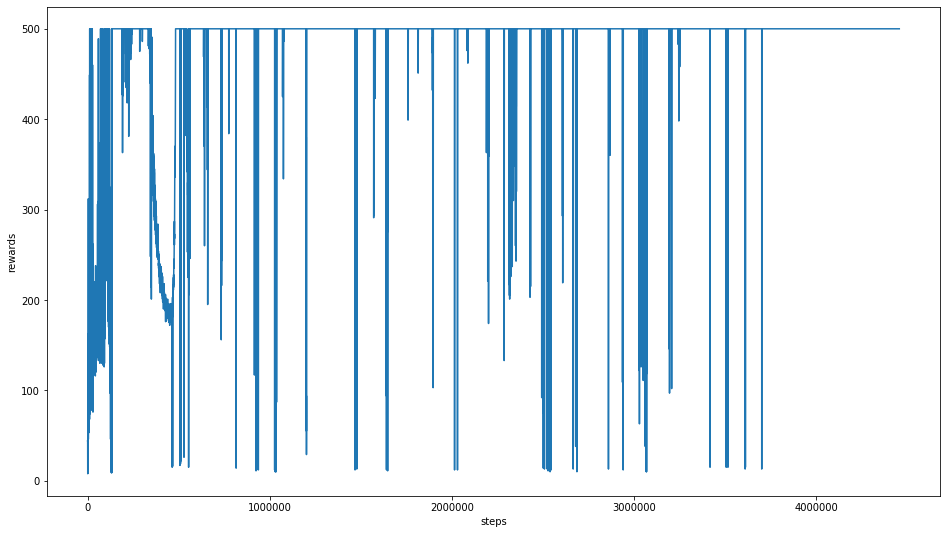

In [49]:
import seaborn as sns
sns.lineplot(train_stats['steps'], train_stats['rewards'])

### Storing results

In [50]:
torch.save(dqn.q.state_dict(), env_name+'_q.pt')
torch.save(dqn.tq.state_dict(), env_name+'_tq.pt')
torch.save(bq_nn1.state_dict(), env_name+'_bq.pt')
with open(env_name+'_stats.dat', 'wb') as ff:
    pickle.dump(train_stats, ff)

In [43]:
dqn.q.load_state_dict(torch.load(env_name+'_q.pt',map_location='cpu'))
dqn.tq.load_state_dict(torch.load(env_name+'_tq.pt',map_location='cpu'))
bq_nn1.load_state_dict(torch.load(env_name+'_bq.pt',map_location='cpu'))
with open(env_name+'_stats.dat', 'rb') as ff:
    train_stats = pickle.load(ff)

### Plotting results

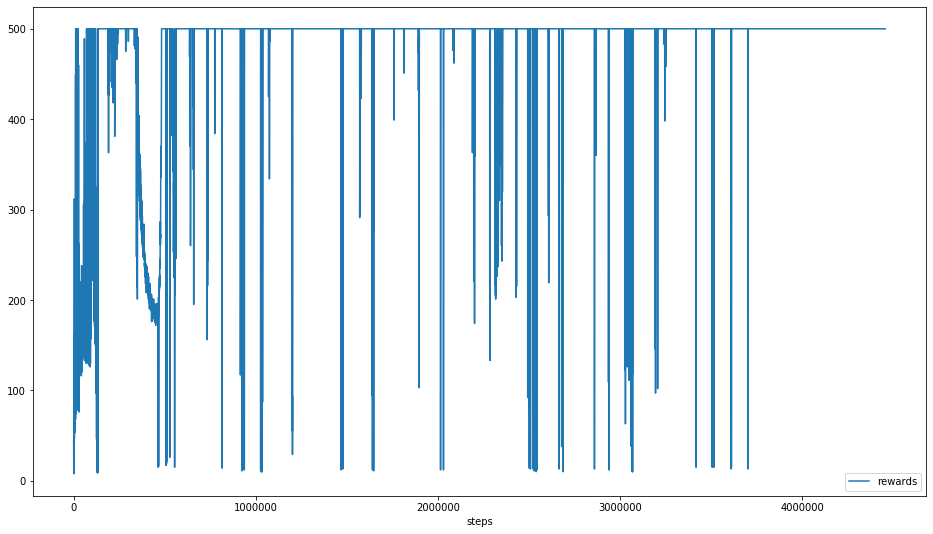

In [39]:
train_stats.plot(x='steps', y='rewards')

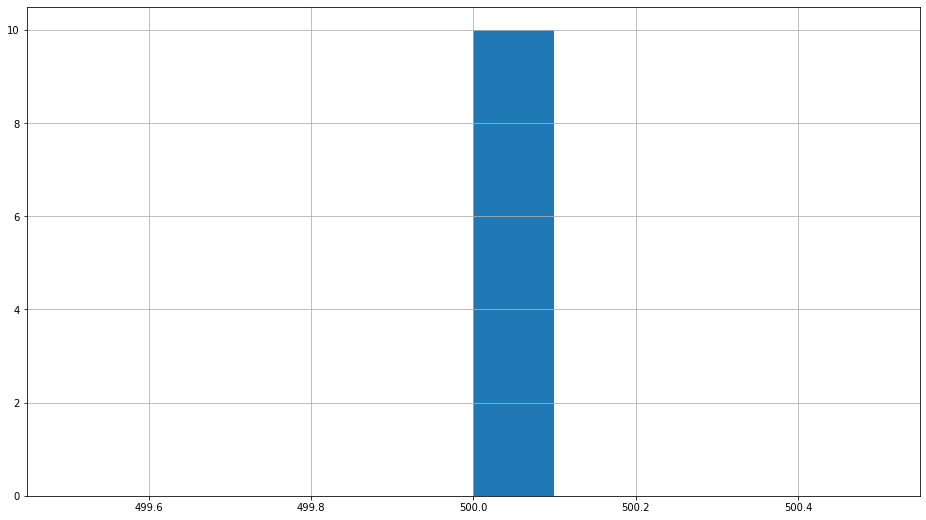

In [21]:
rew_stats = ag.sample_rewards(10)
pd.Series(rew_stats).hist(bins=10)

### Having a look

In [44]:
dqn.eps = 0.0 # we turn off the randomness
#dqn.q = bqnn1

In [45]:
sum(ag.play(max_steps=5000, render=True, episode=True, store=False)[0])

500.0

### Visualizing Q values

In [43]:
iter(ag)
r_tot = 0
fr_i = next(ag)
q_vals = [fr_i[4].cpu().numpy().squeeze()]
#q_vals[0] = q_vals[0]-np.mean(q_vals[0])

Action: tensor([1])
Reward: 1.0 Total: 1.0


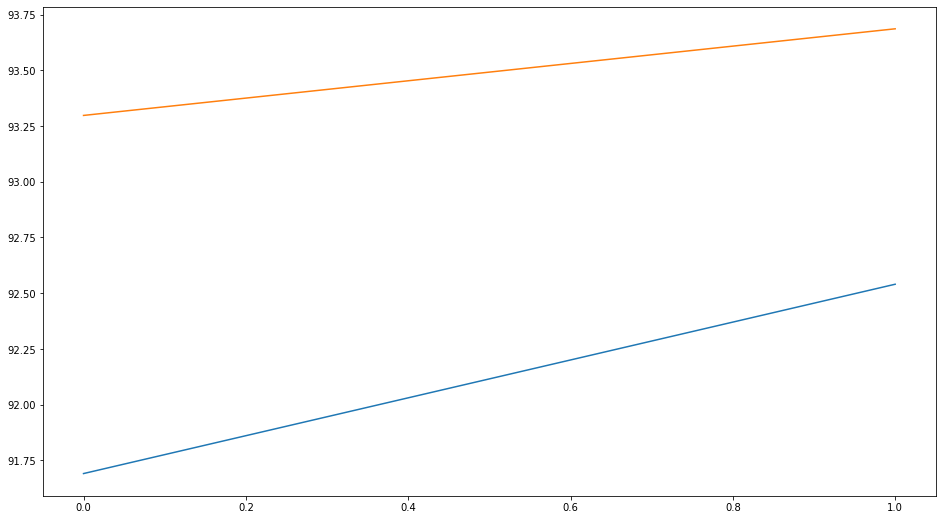

In [44]:
fr_i = next(ag)
r_tot += fr_i[2]
print('Action:', fr_i[1]) #, env_walk.act_dict[fr_i[1]])
print('Reward:', fr_i[2], 'Total:', r_tot)
ag.env.render()
#q_vals.append(fr_i[4].cpu().numpy().squeeze()-np.mean(fr_i[4].cpu().numpy().squeeze()))
q_vals.append(fr_i[4].cpu().numpy().squeeze())
plt.plot(np.stack(q_vals, axis=0));